In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import regex as re
import pickle as pkl
import seaborn as sns

from scipy import stats
from scipy.stats import cumfreq
import statsmodels.api as sm

from tabulate import tabulate
from scipy.stats import f

import os

In [66]:
os.chdir("/Users/avascharfstein/Desktop/Dartmouth/mds-final")

In [67]:
df = pd.read_csv('data/df_relabeled.csv')
with open('data/specific_stats.pkl', 'rb') as f:
    specific_stats = pkl.load(f)
with open('data/overall_stats.pkl', 'rb') as f:
    overall_stats = pkl.load(f)
with open('data/context_vars.pkl', 'rb') as f:
    context_vars = pkl.load(f)

stats_df = df.drop(columns = context_vars)

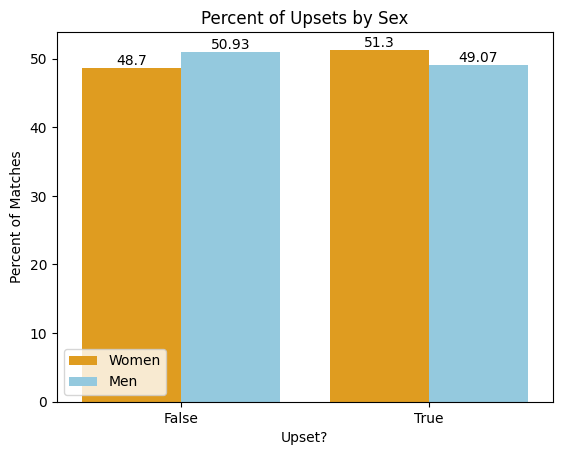

In [104]:
def upset_breakdown(df_, suptitle):
    breakdown = pd.DataFrame(df_.groupby('men')['upset'].value_counts(normalize = True)*100).reset_index().round(2)
    breakdown['men'] = breakdown['men'].apply(lambda x: "Men" if x==1 else "Women")
    fig, ax = plt.subplots()
    res = sns.barplot(ax = ax, data = breakdown, x = 'upset', y = 'proportion', hue = 'men', palette = {'Men':'skyblue','Women':'orange'})
    for container in res.containers:
        res.bar_label(container)
    plt.xlabel("Upset?")
    plt.ylabel("Percent of Matches")
    plt.title("Percent of Upsets by Sex")
    plt.suptitle(suptitle, fontsize = 10)
    plt.legend(loc='lower left')
    plt.show()

upset_breakdown(stats_df,"")

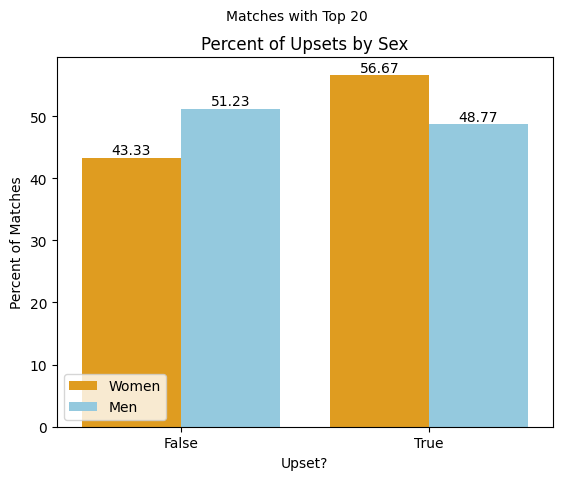

In [105]:
#stats_df['upset'] = (stats_df['upset']) & (stats_df['rs_diff']< -5.0) # defining upsets when there is at least a five rank difference between the players


top20 = stats_df[(stats_df['rs_home']<=20) | (stats_df['rs_away']<=20)] # match has at least 1 top 20 player
upset_breakdown(top20,"Matches with Top 20")

In [70]:
# upset = 
# sns.scatterplot(stats_df[['rs_diff', 'men','upset']])
# plt.xlabel('Ranking difference (Home-Away)')

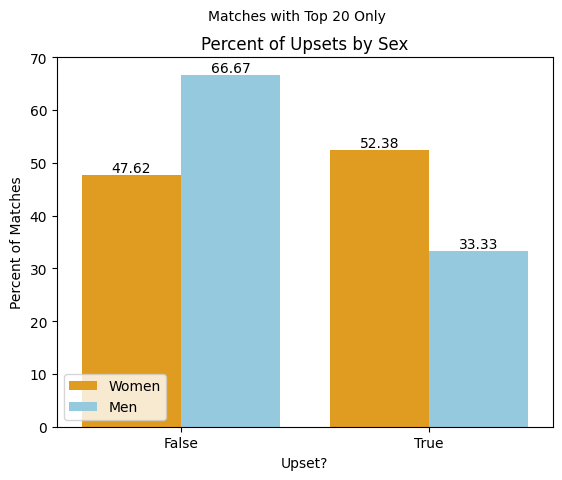

In [107]:
upset_breakdown(stats_df[(stats_df['rs_home']<=20) & (stats_df['rs_away']<=20)],"Matches with Top 20 Only")

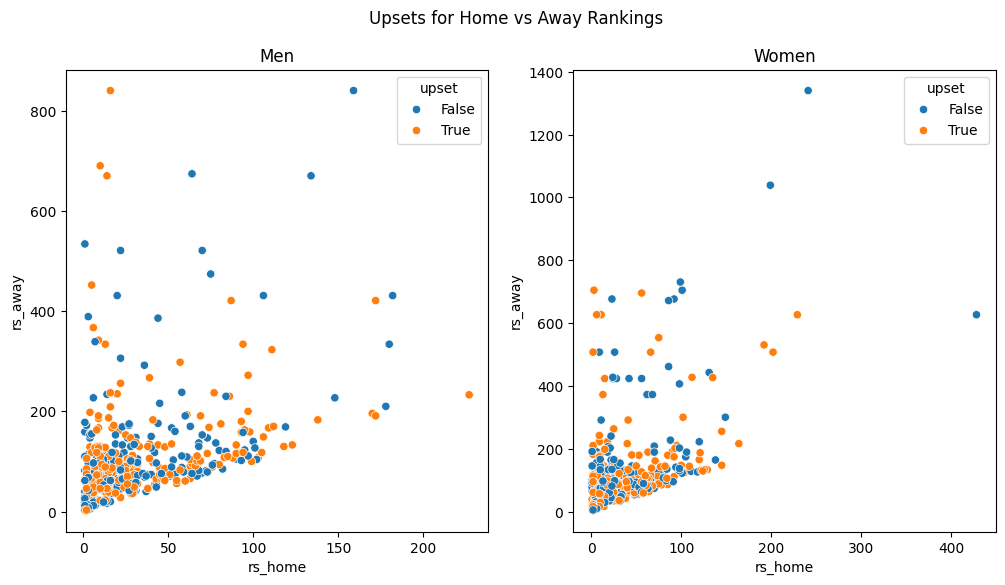

In [117]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax[0].set_title('Men')
sns.scatterplot(stats_df[stats_df['men']][['rs_home','rs_away','upset']], x='rs_home',y='rs_away',hue='upset', ax=ax[0])
ax[1].set_title('Women')
sns.scatterplot(stats_df[~stats_df['men']][['rs_home','rs_away','upset']], x='rs_home',y='rs_away',hue='upset', ax=ax[1])
plt.suptitle('Upsets for Home vs Away Rankings');

In [130]:
upsets = stats_df[stats_df['upset']]
expected = stats_df[~stats_df['upset']]

In [143]:
features_diff_df = pd.read_csv("data/features_diff_df.csv")
features_diff_df['upset'] = stats_df['upset']
features_diff_df['rs_diff'] = stats_df['rs_diff']

In [144]:
upsets = features_diff_df[features_diff_df['upset']]
expected = features_diff_df[~features_diff_df['upset']]

In [148]:
def dist_measures(dist):
    mean = np.mean(dist)
    median = np.median(dist)
    std = np.std(dist)
    if std==0:
        skew = 0
    else:
        skew = 3*(mean-median)/std
    return [mean, median, skew, std]

def plt_dist(df, var, xlabel= None):
    m_dist = df[df['men']][var]
    w_dist = df[~df['men']][var]
    [m_mean, m_median, m_skew, m_std] = dist_measures(m_dist)
    [w_mean, w_median, w_skew, w_std] = dist_measures(w_dist)
    metric = "Mean" # default metric is mean
    m_metric = m_mean
    w_metric = w_mean
    #Assume skewness is >0 since there will be no negative values (FOR NOW)
    if m_skew > .5 or w_skew >.5: # if one of the distributions is skewed heavily..
        metric = "Median"
        m_metric = m_median
        w_metric = w_median

    if xlabel is None:
        xlabel = var.replace("_"," ").title()

    sns.histplot(m_dist, alpha=0.6, label='Mens', color='skyblue',edgecolor='white')
    sns.histplot(w_dist, alpha=0.4, label='Womens', color='orange',edgecolor='white') 

    plt.axvline(m_metric, color='skyblue', linestyle='dashed', linewidth=3)
    plt.axvline(w_metric, color='orange', linestyle='dashed', linewidth=3)
    #plt.title("Dashed Line represents " + metric, fontsize=7)
    plt.suptitle("Histogram of " + var.replace("_", " ").title())
    plt.text(0.5, -0.15, f"Dashed Line represents {metric}", horizontalalignment='center', verticalalignment='center',
             transform=plt.gca().transAxes, fontdict={'fontsize': 8, 'fontstyle': 'italic'})
    plt.xlabel(xlabel)
    plt.ylabel("Matches")
    plt.legend(loc='upper right')
    plt.show()

def plt_ecdf(df, var, xlabel=None):
    m_dist = df[df['men']][var]
    w_dist = df[~df['men']][var]

    ks = stats.kstest(m_dist, w_dist)

    m_x, m_cf = np.sort(m_dist), np.arange(1, len(m_dist) + 1) / len(m_dist)
    w_x, w_cf = np.sort(w_dist), np.arange(1, len(w_dist) + 1) / len(w_dist)

    if xlabel is None:
        xlabel = var.replace("_", " ").title()

    plt.step(x=m_x, y=m_cf, label='Mens', color='skyblue')
    plt.step(x=w_x, y=w_cf, label='Womens', color='orange')

    plt.title("Empirical CDF of " + var.replace("_", " ").title())
    plt.xlabel(xlabel)
    plt.ylabel("Cumulative Probability")
    plt.legend(loc='lower right')
    # Display KS test statistic and p-value
    plt.text(0.5, -0.15, f"KS Statistic: {ks.statistic:.4f}, p-value: {ks.pvalue:.4f}", horizontalalignment='center', verticalalignment='center',
             transform=plt.gca().transAxes, fontdict={'fontsize': 8, 'fontstyle': 'italic'})
    
    plt.show()

def summarize(df, var):
    m_dist = df[df['men']][var]
    w_dist = df[~df['men']][var]
    m_results = stats.describe(m_dist)
    w_results = stats.describe(w_dist)
    
    summary_data = [
        ["Mean", m_results.mean, w_results.mean],
        ["Median", np.median(m_dist), np.median(w_dist)],
        ["Variance", m_results.variance, w_results.variance],
        ["Skewness", m_results.skewness, w_results.skewness],
        ["Kurtosis", m_results.kurtosis, w_results.kurtosis],
    ]

    significant = []

    # KS-Test for distributions
    ks_stat, ks_p_value = stats.kstest(m_dist, w_dist)
    if ks_p_value <.05:
        significant.append("KS-Test")

    # T-test for means
    t_stat, t_p_value = stats.ttest_ind(m_dist, w_dist)
    if t_p_value < .05:
        significant.append("T-test")

    # Mann-Whitney U test (non-parametric test for comparing distributions)
    u_stat, mw_p_value = stats.mannwhitneyu(m_dist, w_dist)
    if mw_p_value < .05:
        significant.append("Mann-Whitney U")

    # F-test for variances
    f_stat, f_p_value = stats.levene(m_dist, w_dist)
    if f_p_value < .05:
        significant.append("Levene")

    
    if m_results.skewness >= .5 or m_results.skewness <= -.5:
        significant.append("M-Skew")
    if w_results.skewness >= .5 or w_results.skewness <= -.5:
        significant.append("W-Skew")

    # Results table
    results_table = [
        ["KS-test (Distribution)", ks_stat, ks_p_value],
        ["T-test (Means)", t_stat, t_p_value],
        ["Mann-Whitney U", u_stat, mw_p_value],
        ["Levene-test (Variances)", f_stat, f_p_value],
    ]
    
    var_format = var.replace("_"," ")
    # Print the tables
    print(f"Summary Statistics for {var_format.title()}:")
    print(tabulate(summary_data, headers=["Statistic", "Men", "Women"], tablefmt="grid"))
    print(tabulate(results_table, headers=["Test", "Statistic", "P-value"], tablefmt="grid"))
    print("Tests that are statistically significant:"+str(significant))
    print('\n\n')

def plt_qq(df, var, name):
    m_dist = df[df['men']][var]
    w_dist = df[~df['men']][var]


    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    stats.probplot(m_dist, plot=axes[0])
    axes[0].set_title('Mens')
    axes[0].get_lines()[0].set_markeredgecolor('none')
    axes[0].get_lines()[0].set_markerfacecolor('skyblue')  # Set color for Men's QQ plot
    axes[0].get_lines()[1].set_color('black')  # Set color for the line


    stats.probplot(w_dist, plot=axes[1])
    axes[1].set_title('Womens')
    axes[1].get_lines()[0].set_markeredgecolor('none')
    axes[1].get_lines()[0].set_markerfacecolor('orange')  # Set color for Women's QQ plot
    axes[1].get_lines()[1].set_color('black')


    fig.suptitle(name)
    plt.show();

In [159]:
upsets['men'] = stats_df[stats_df['upset']]['men']
expected['men'] = stats_df[~stats_df['upset']]['men']

/var/folders/7_/mtdhgw6s63dc18509m14sztm0000gn/T/ipykernel_60050/3627994179.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  upsets['men'] = stats_df[stats_df['upset']]['men']
/var/folders/7_/mtdhgw6s63dc18509m14sztm0000gn/T/ipykernel_60050/3627994179.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expected['men'] = stats_df[~stats_df['upset']]['men']


Summary Statistics for Aces Diff:
+-------------+------------+----------+
| Statistic   |        Men |    Women |
+=============+============+==========+
| Mean        |  0.421409  | 0.441481 |
+-------------+------------+----------+
| Median      |  0.366667  | 0        |
+-------------+------------+----------+
| Variance    |  3.92503   | 1.73478  |
+-------------+------------+----------+
| Skewness    | -0.0887955 | 0.7376   |
+-------------+------------+----------+
| Kurtosis    |  0.927398  | 0.743944 |
+-------------+------------+----------+
+-------------------------+--------------+-------------+
| Test                    |    Statistic |     P-value |
+=========================+==============+=============+
| KS-test (Distribution)  |     0.131924 | 0.0296374   |
+-------------------------+--------------+-------------+
| T-test (Means)          |    -0.128242 | 0.898013    |
+-------------------------+--------------+-------------+
| Mann-Whitney U          | 28004        | 0.82

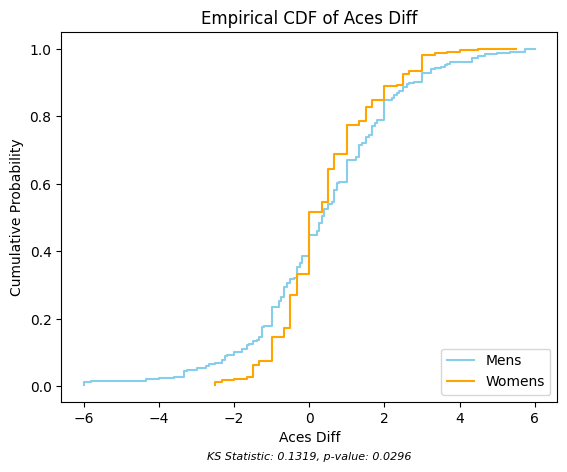

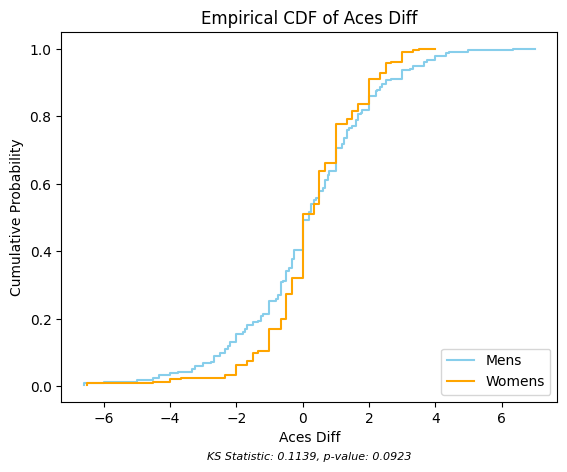

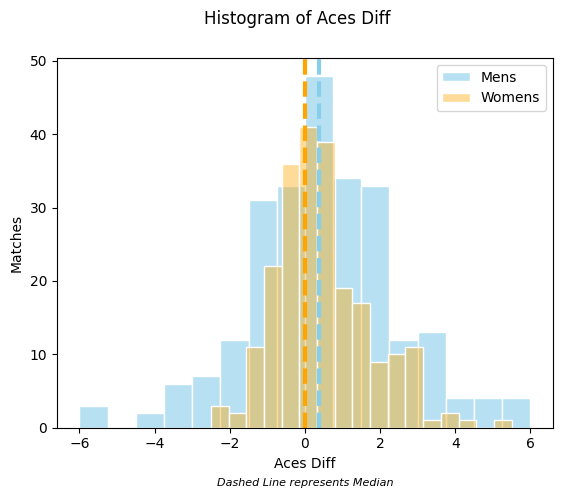

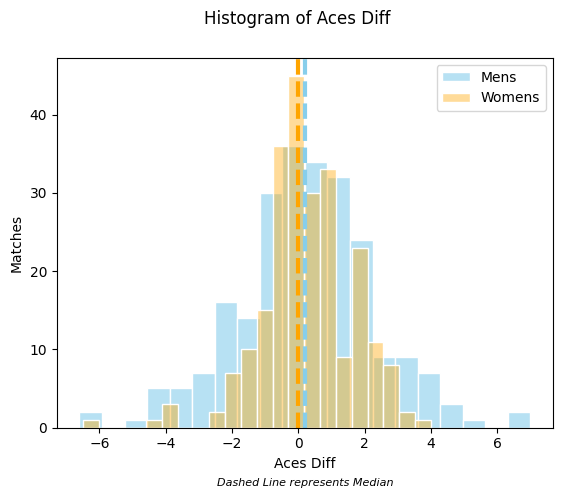

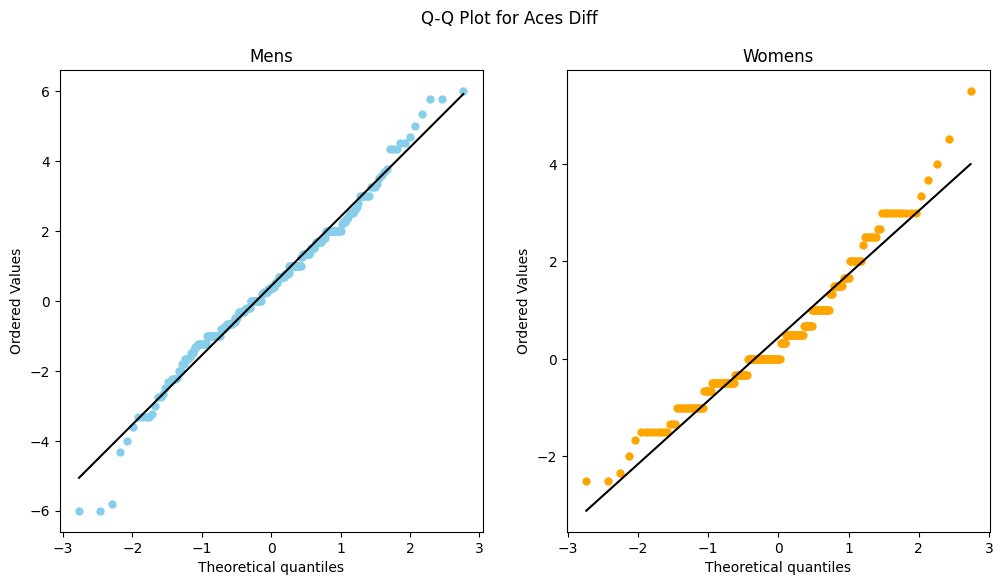

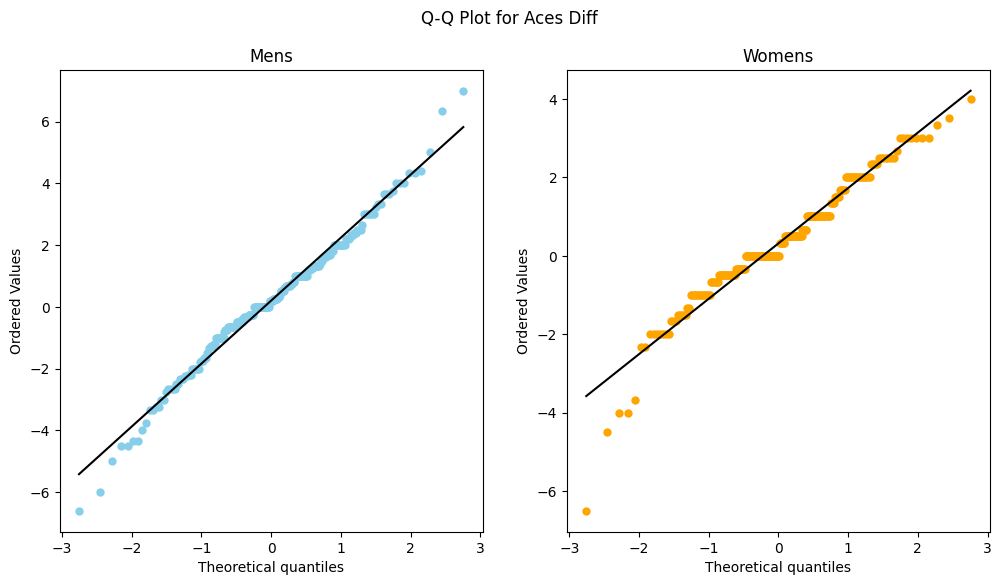

Summary Statistics for Avg Game Length:
+-------------+-----------+----------+
| Statistic   |       Men |    Women |
+=============+===========+==========+
| Mean        |  4.63581  | 4.77901  |
+-------------+-----------+----------+
| Median      |  4.63957  | 4.75     |
+-------------+-----------+----------+
| Variance    |  0.368097 | 0.402415 |
+-------------+-----------+----------+
| Skewness    |  0.180369 | 0.230237 |
+-------------+-----------+----------+
| Kurtosis    | -0.3271   | 0.333633 |
+-------------+-----------+----------+
+-------------------------+---------------+------------+
| Test                    |     Statistic |    P-value |
+=========================+===============+============+
| KS-test (Distribution)  |     0.150623  | 0.00837194 |
+-------------------------+---------------+------------+
| T-test (Means)          |    -2.50337   | 0.0126404  |
+-------------------------+---------------+------------+
| Mann-Whitney U          | 24023         | 0.0133328 

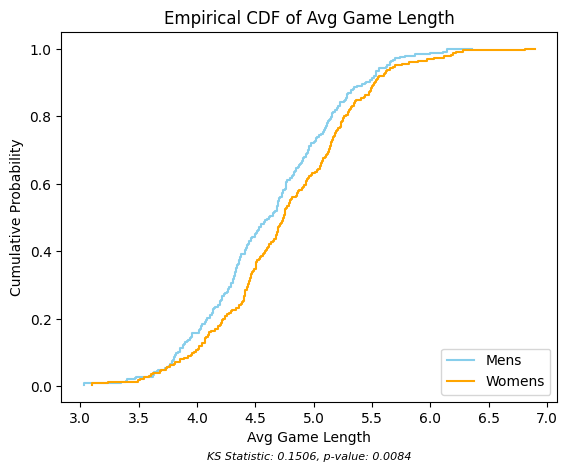

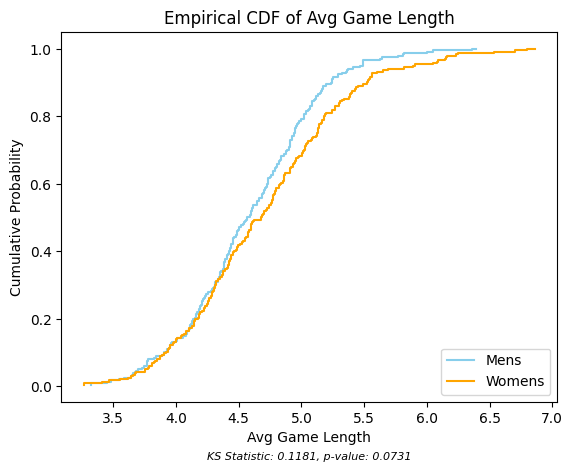

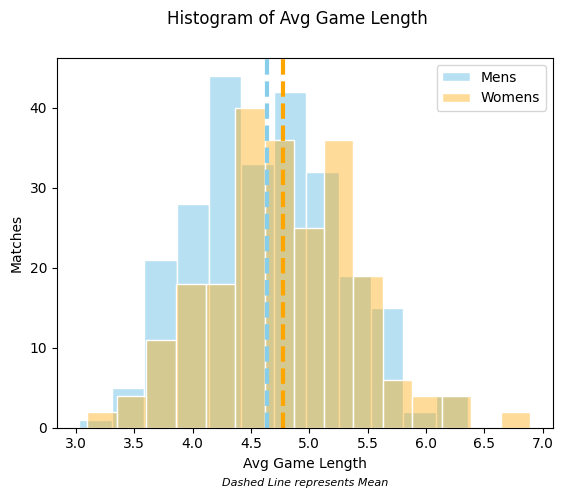

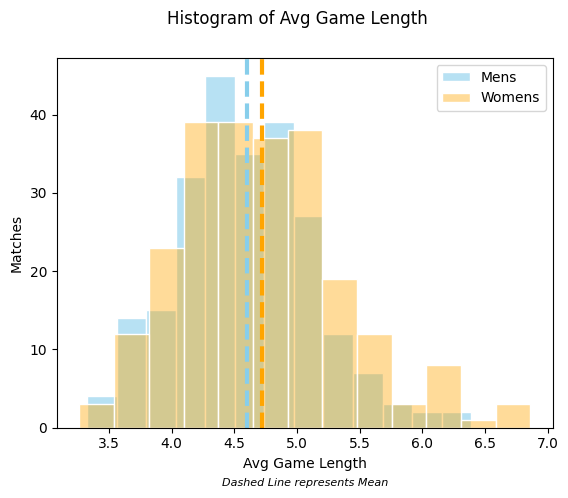

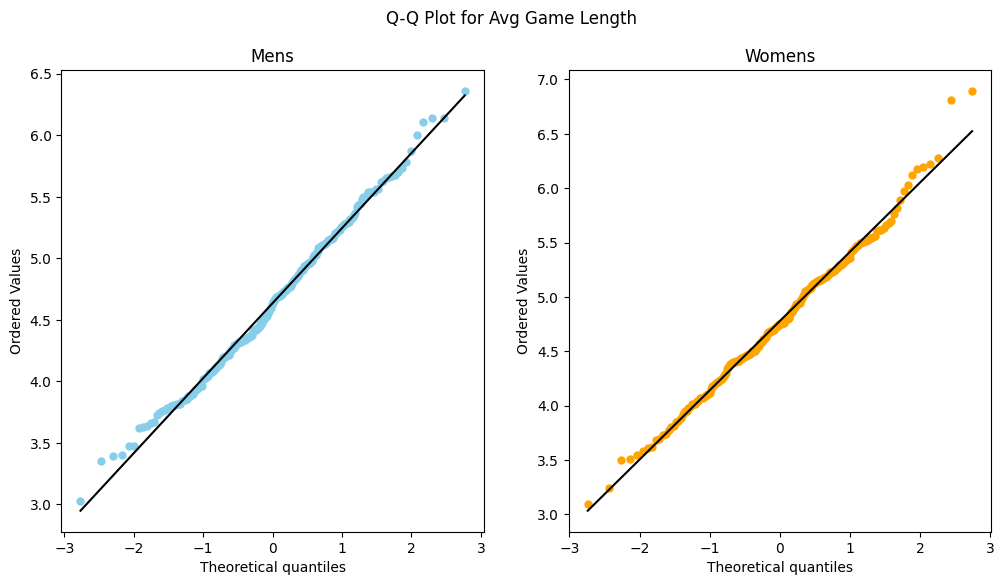

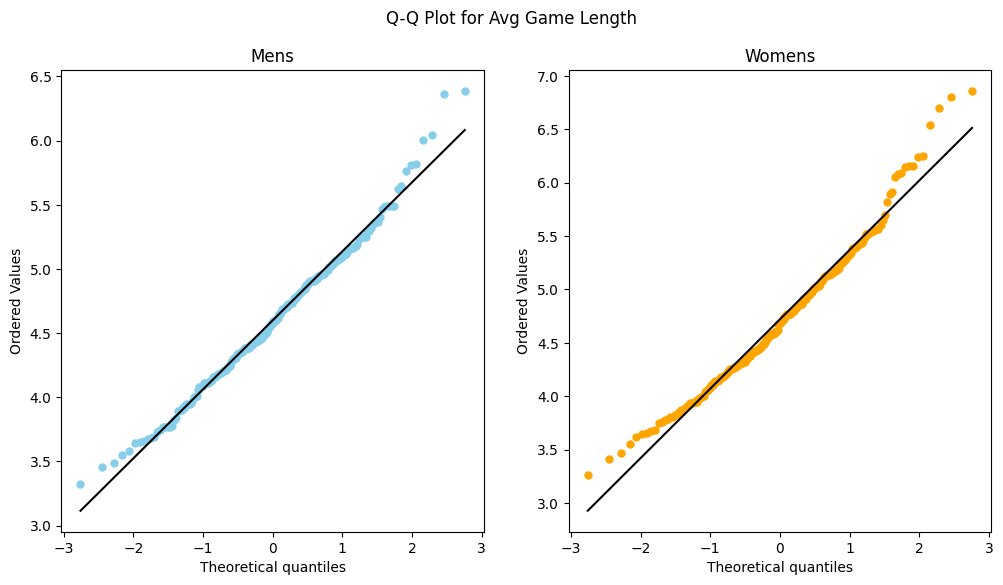

Summary Statistics for Avg Points Per Game:
+-------------+----------+----------+
| Statistic   |      Men |    Women |
+=============+==========+==========+
| Mean        | 6.34527  | 6.54854  |
+-------------+----------+----------+
| Median      | 6.27273  | 6.53846  |
+-------------+----------+----------+
| Variance    | 0.250106 | 0.345915 |
+-------------+----------+----------+
| Skewness    | 0.82618  | 0.25836  |
+-------------+----------+----------+
| Kurtosis    | 1.4015   | 0.397186 |
+-------------+----------+----------+
+-------------------------+--------------+-------------+
| Test                    |    Statistic |     P-value |
+=========================+==============+=============+
| KS-test (Distribution)  |     0.205041 | 8.10179e-05 |
+-------------------------+--------------+-------------+
| T-test (Means)          |    -4.05107  | 5.96603e-05 |
+-------------------------+--------------+-------------+
| Mann-Whitney U          | 21302        | 1.56789e-05 |
+-----

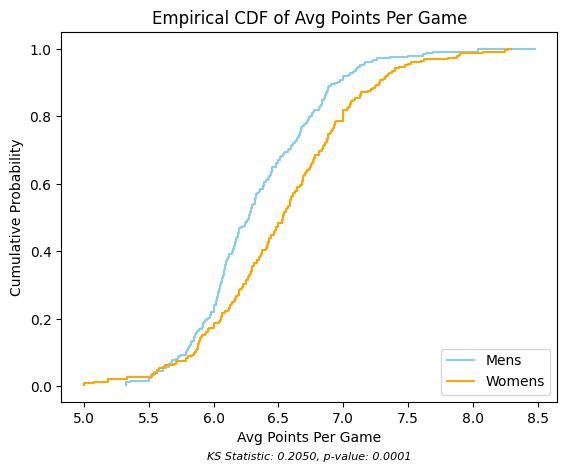

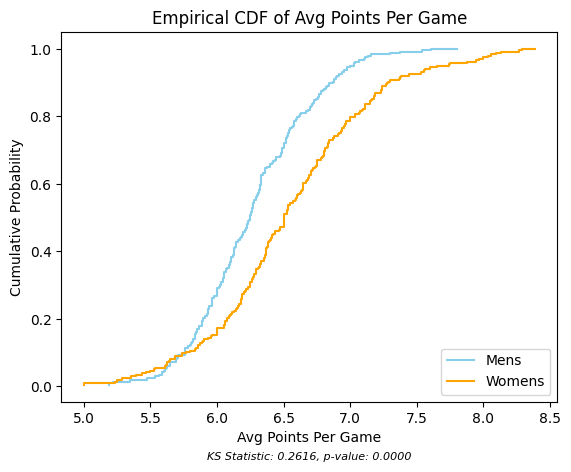

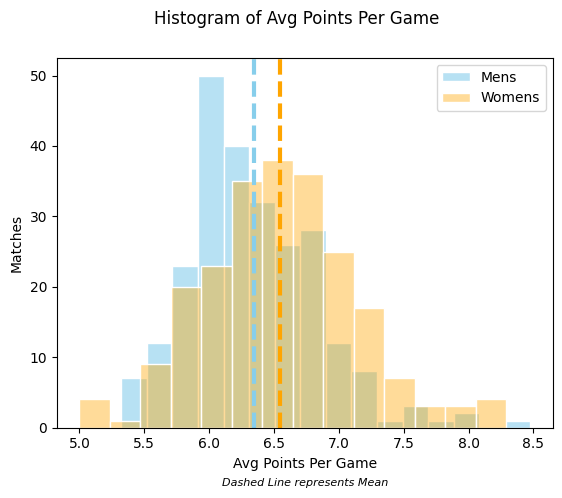

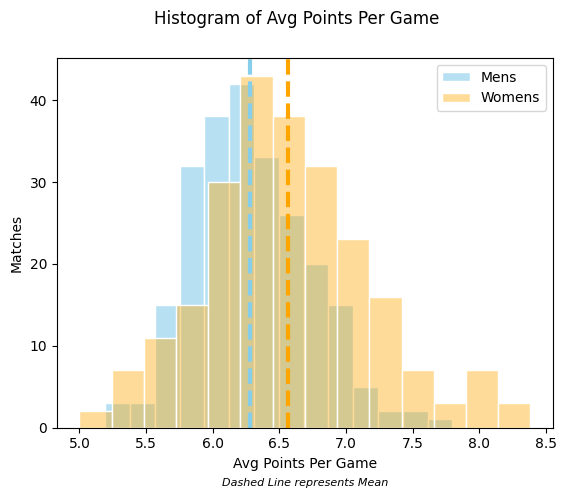

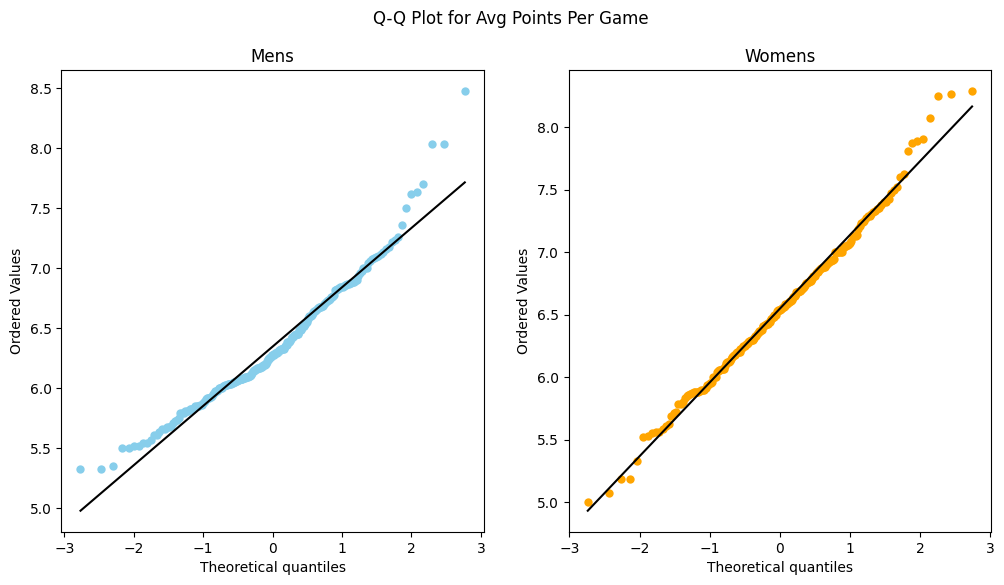

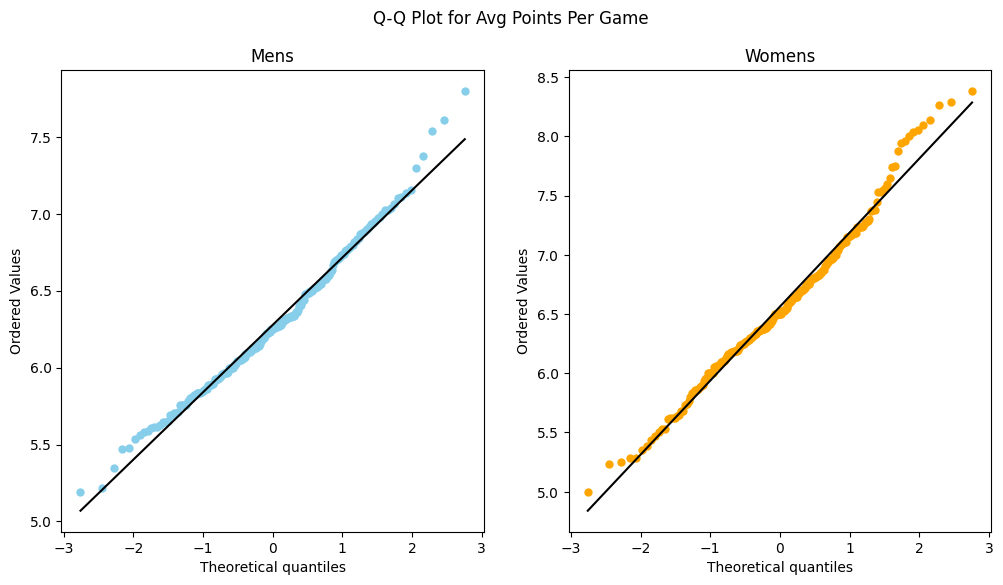

Summary Statistics for Avg Set Diff:
+-------------+-----------+-----------+
| Statistic   |       Men |     Women |
+=============+===========+===========+
| Mean        |  1.87344  |  2.49259  |
+-------------+-----------+-----------+
| Median      |  1.75     |  2.5      |
+-------------+-----------+-----------+
| Variance    |  1.46227  |  2.20456  |
+-------------+-----------+-----------+
| Skewness    |  0.115496 |  0.118707 |
+-------------+-----------+-----------+
| Kurtosis    | -0.410402 | -0.799765 |
+-------------+-----------+-----------+
+-------------------------+--------------+-------------+
| Test                    |    Statistic |     P-value |
+=========================+==============+=============+
| KS-test (Distribution)  |     0.227696 | 7.6653e-06  |
+-------------------------+--------------+-------------+
| T-test (Means)          |    -4.97957  | 8.97095e-07 |
+-------------------------+--------------+-------------+
| Mann-Whitney U          | 21198.5      | 1

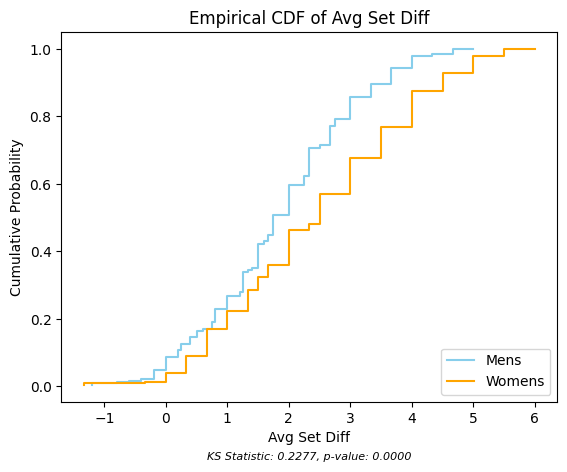

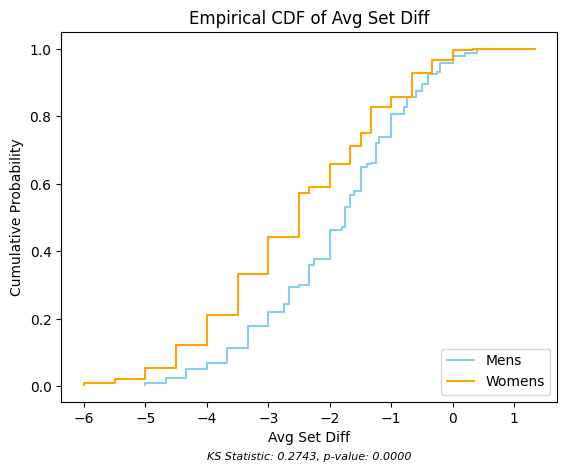

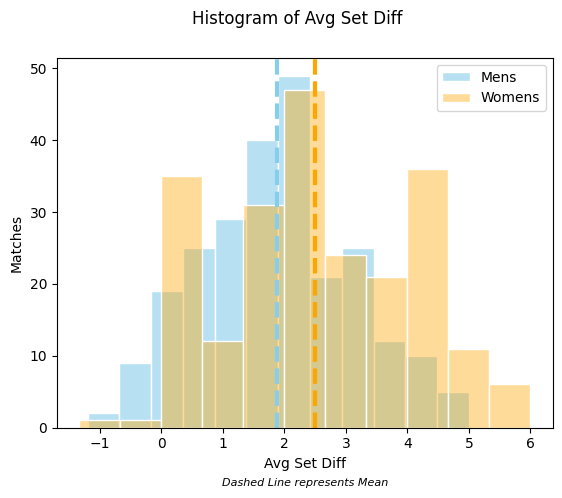

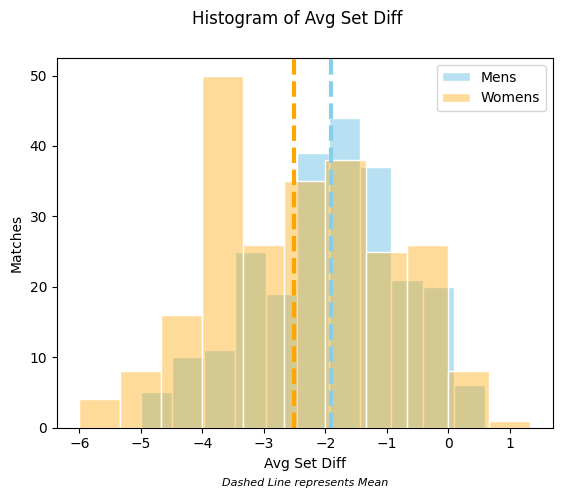

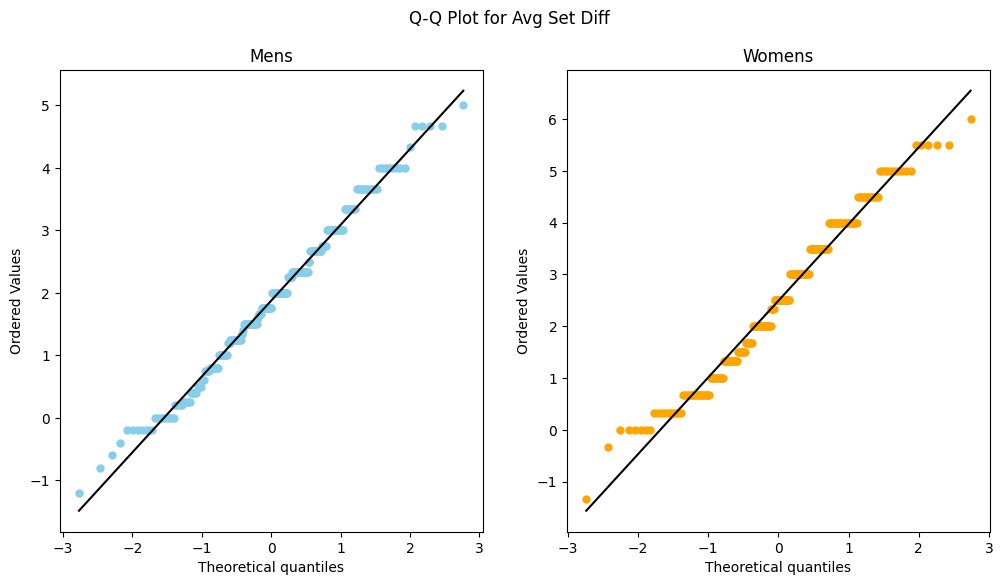

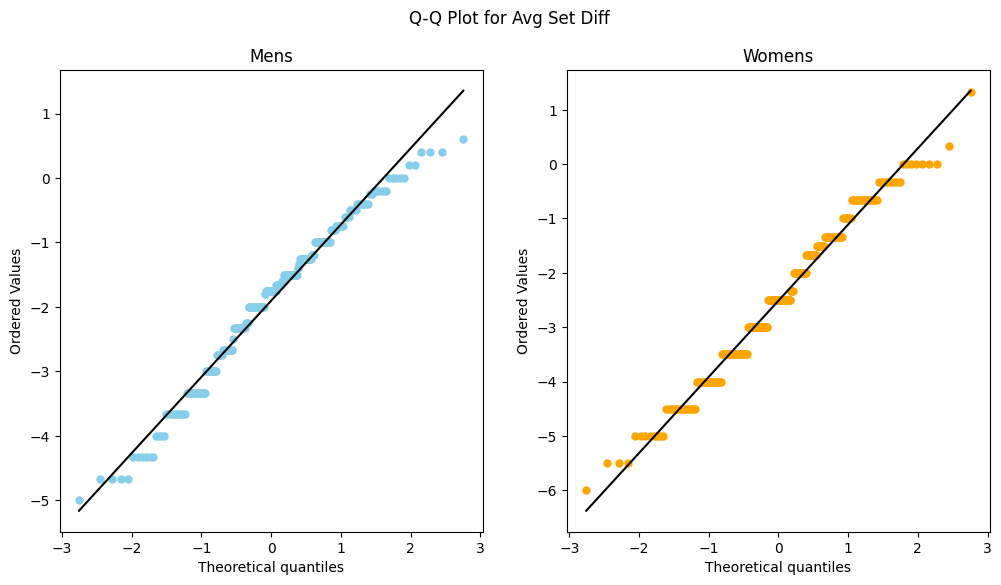

Summary Statistics for Avg Set Games:
+-------------+------------+-----------+
| Statistic   |        Men |     Women |
+=============+============+===========+
| Mean        |  9.71721   |  9.21407  |
+-------------+------------+-----------+
| Median      |  9.75      |  9        |
+-------------+------------+-----------+
| Variance    |  1.07728   |  1.97319  |
+-------------+------------+-----------+
| Skewness    | -0.0473403 |  0.291718 |
+-------------+------------+-----------+
| Kurtosis    | -0.127038  | -0.24915  |
+-------------+------------+-----------+
+-------------------------+--------------+-------------+
| Test                    |    Statistic |     P-value |
+=========================+==============+=============+
| KS-test (Distribution)  |     0.242981 | 1.35355e-06 |
+-------------------------+--------------+-------------+
| T-test (Means)          |     4.44569  | 1.09478e-05 |
+-------------------------+--------------+-------------+
| Mann-Whitney U          | 34

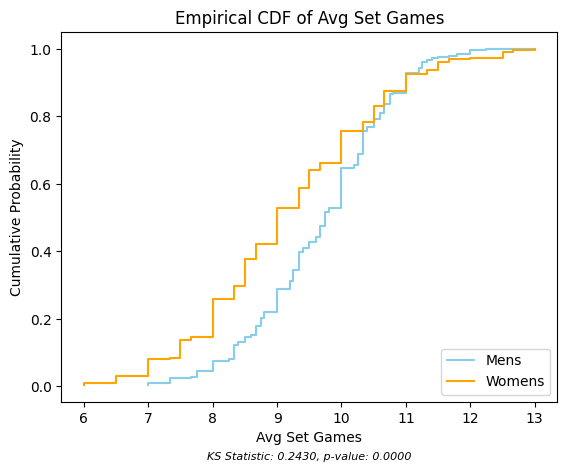

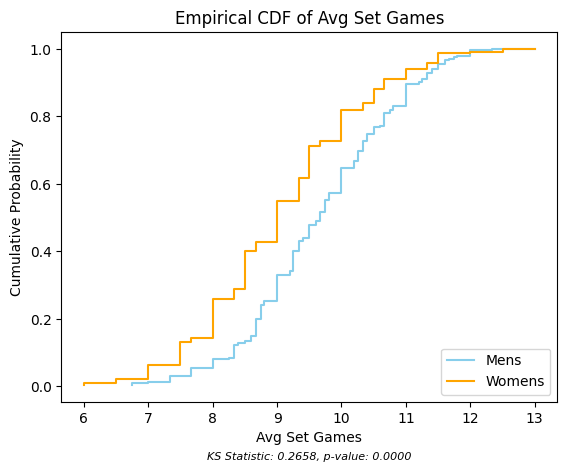

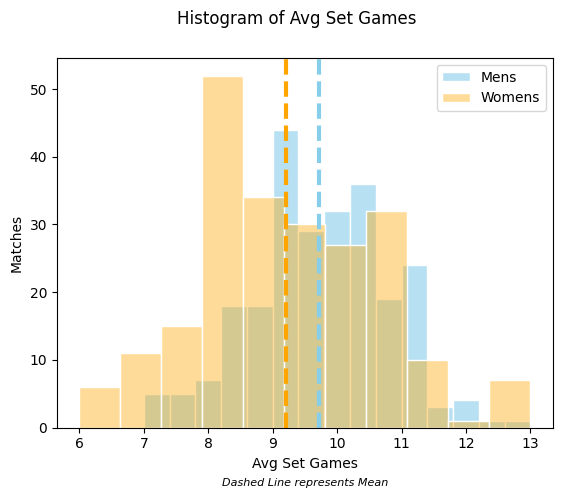

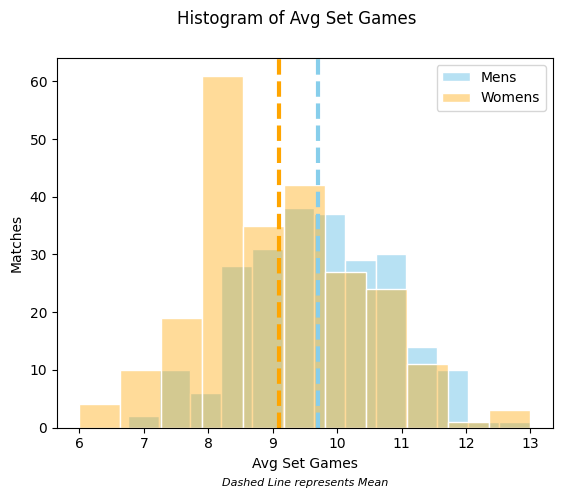

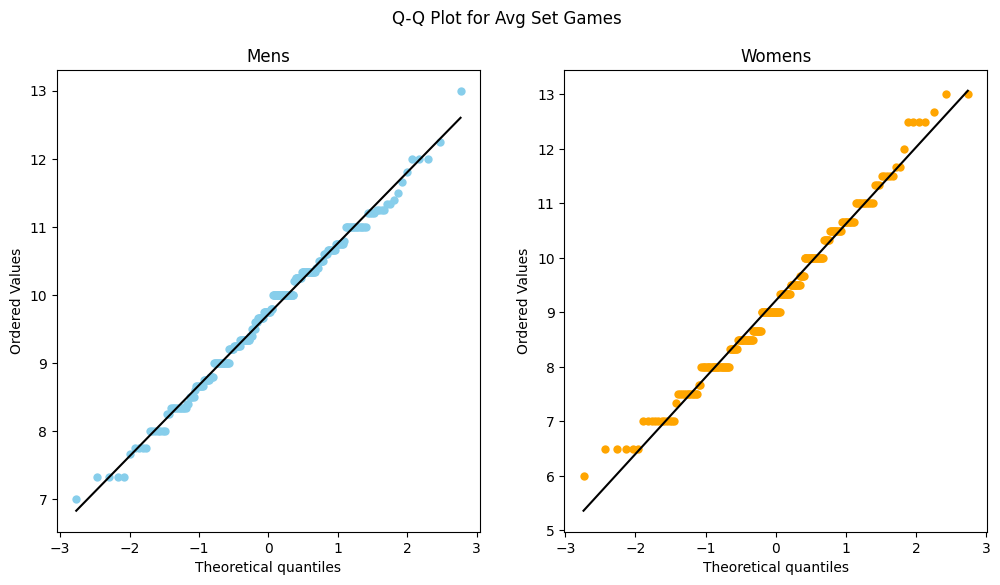

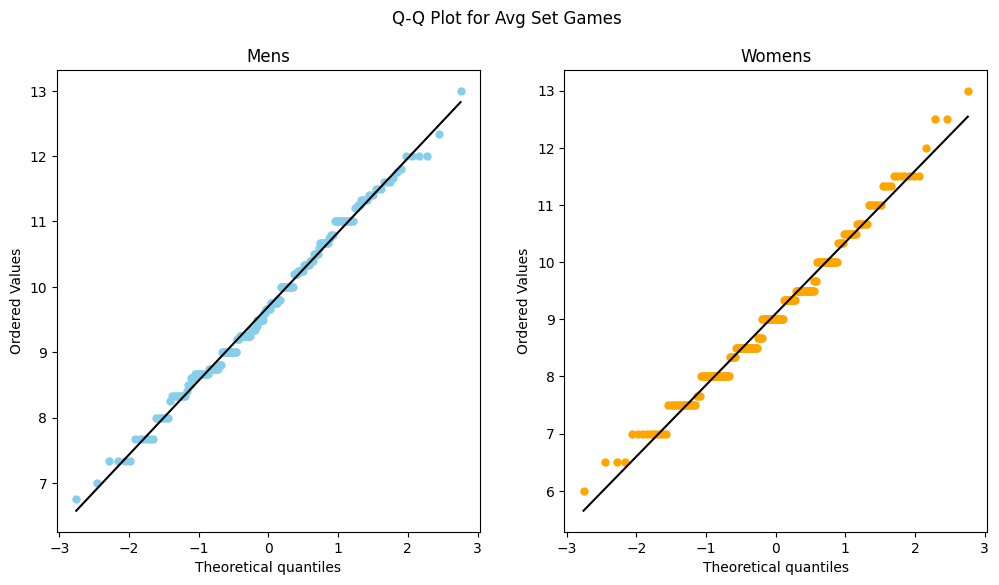

Summary Statistics for Avg Set Length:
+-------------+------------+------------+
| Statistic   |        Men |      Women |
+=============+============+============+
| Mean        | 44.889     |  44.2886   |
+-------------+------------+------------+
| Median      | 44.2694    |  43.8167   |
+-------------+------------+------------+
| Variance    | 59.4143    | 109.403    |
+-------------+------------+------------+
| Skewness    |  0.280211  |   0.622579 |
+-------------+------------+------------+
| Kurtosis    | -0.0822466 |   0.514054 |
+-------------+------------+------------+
+-------------------------+--------------+-------------+
| Test                    |    Statistic |     P-value |
+=========================+==============+=============+
| KS-test (Distribution)  |     0.137832 | 0.0202403   |
+-------------------------+--------------+-------------+
| T-test (Means)          |     0.713209 | 0.476071    |
+-------------------------+--------------+-------------+
| Mann-Whitney U

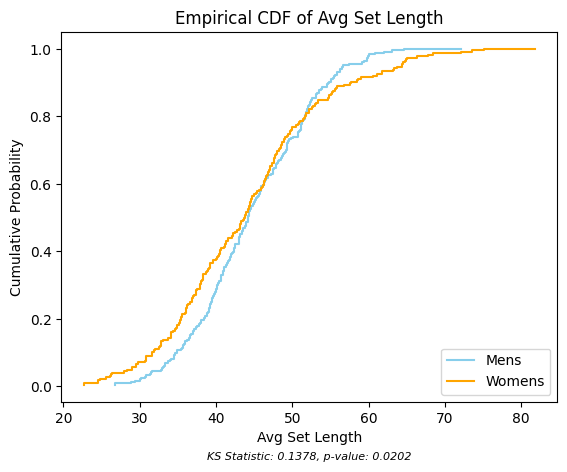

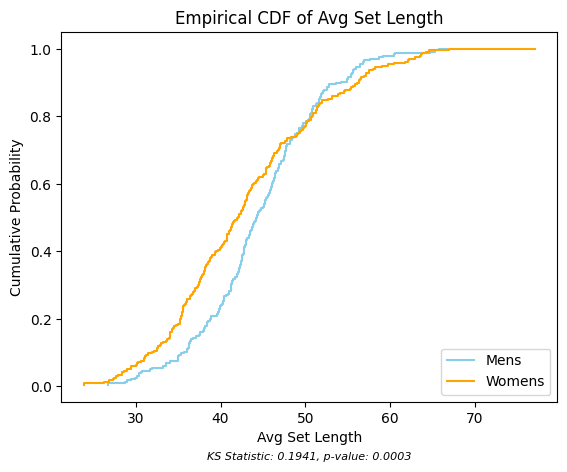

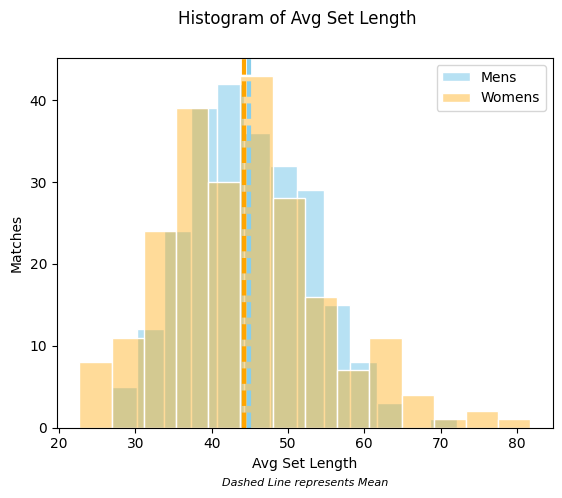

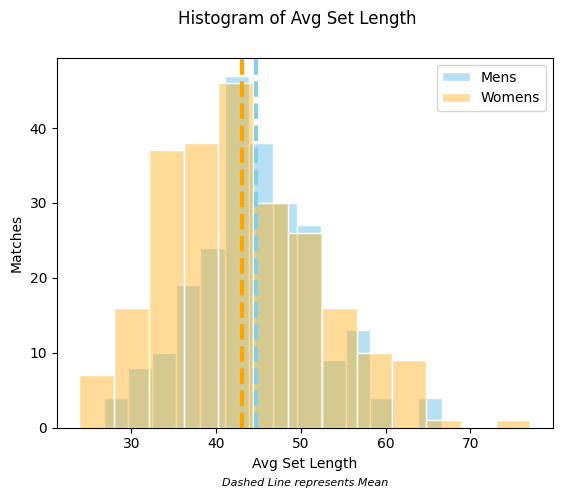

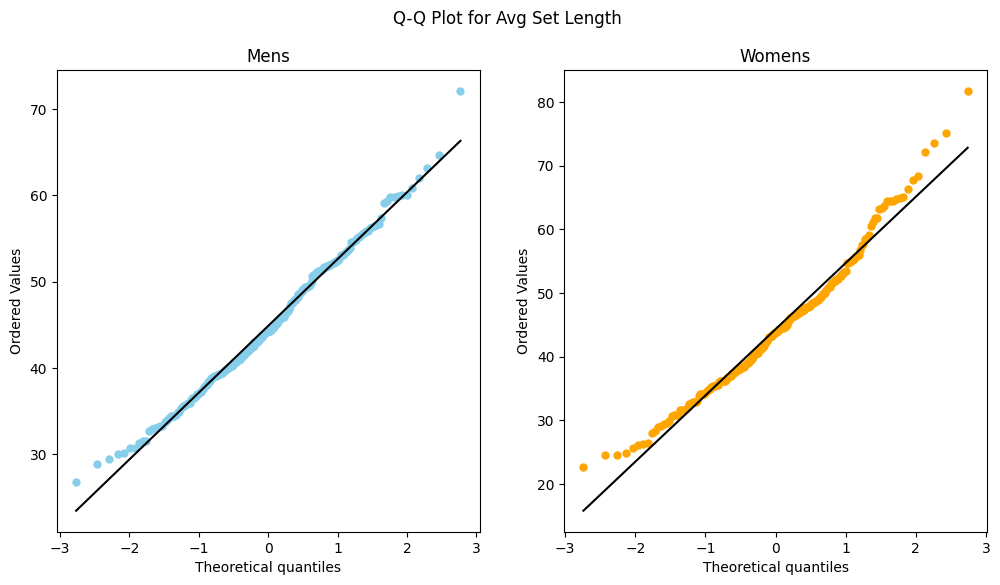

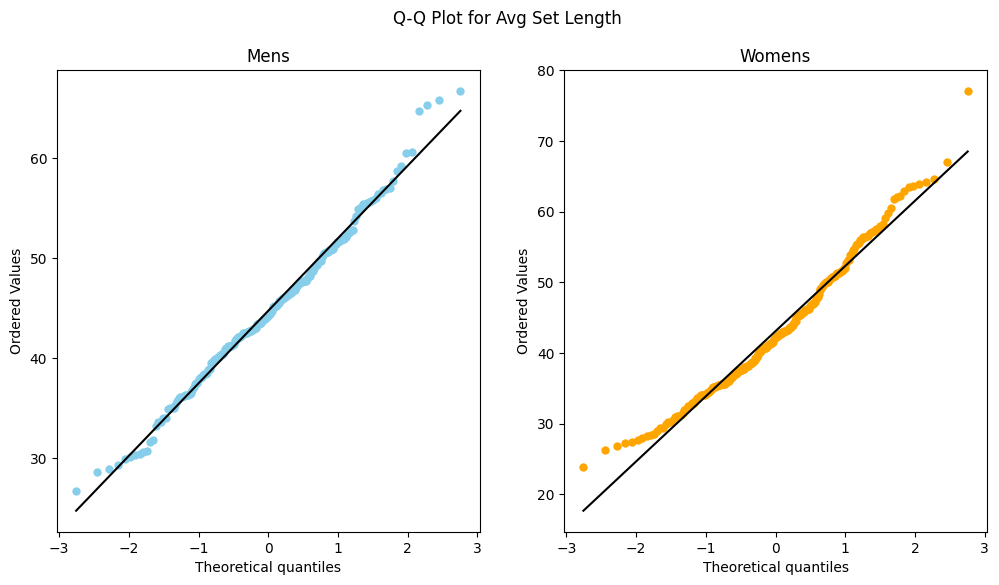

Summary Statistics for Breakpoints Won Diff:
+-------------+-----------+-----------+
| Statistic   |       Men |     Women |
+=============+===========+===========+
| Mean        |  0.452846 |  0.544444 |
+-------------+-----------+-----------+
| Median      |  0.6      |  0.666667 |
+-------------+-----------+-----------+
| Variance    |  0.916606 |  1.71379  |
+-------------+-----------+-----------+
| Skewness    | -0.489577 | -0.305697 |
+-------------+-----------+-----------+
| Kurtosis    | -0.172721 | -0.80534  |
+-------------+-----------+-----------+
+-------------------------+--------------+-------------+
| Test                    |    Statistic |     P-value |
+=========================+==============+=============+
| KS-test (Distribution)  |     0.219892 | 1.7783e-05  |
+-------------------------+--------------+-------------+
| T-test (Means)          |    -0.871786 | 0.383771    |
+-------------------------+--------------+-------------+
| Mann-Whitney U          | 25791.5 

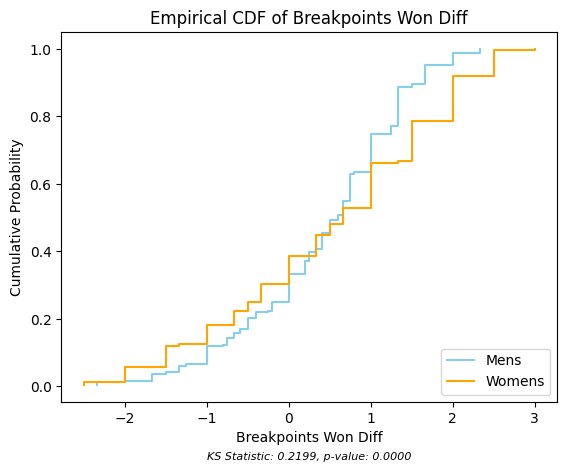

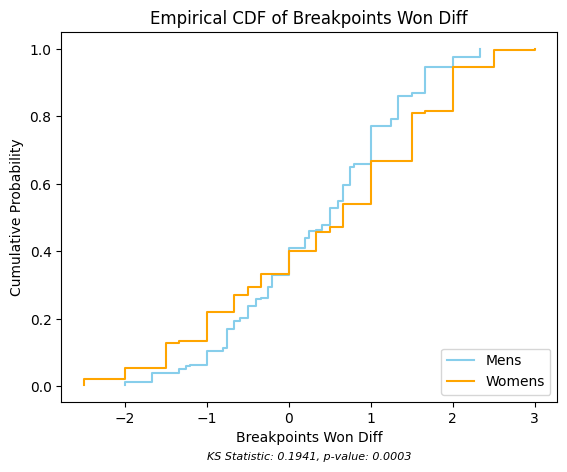

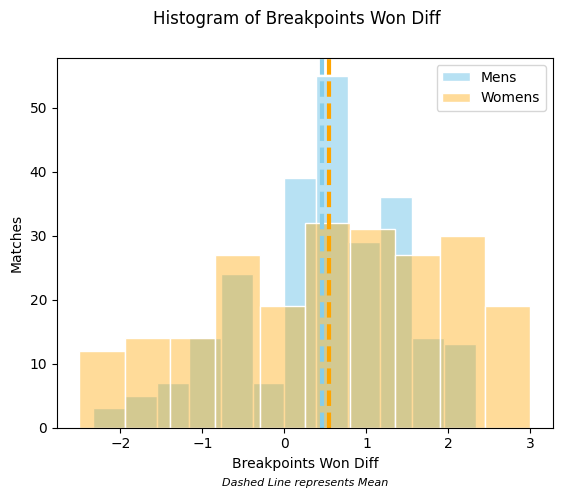

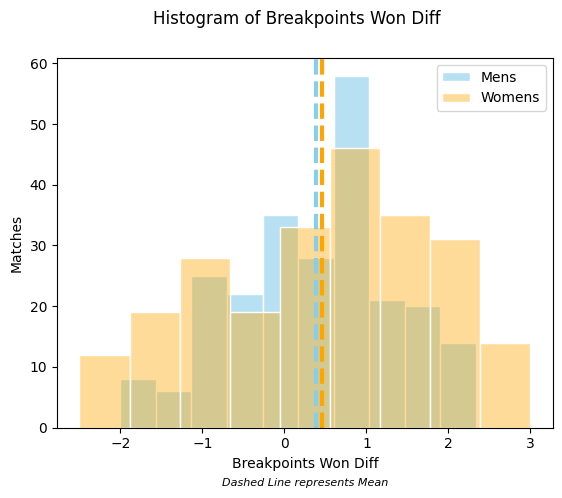

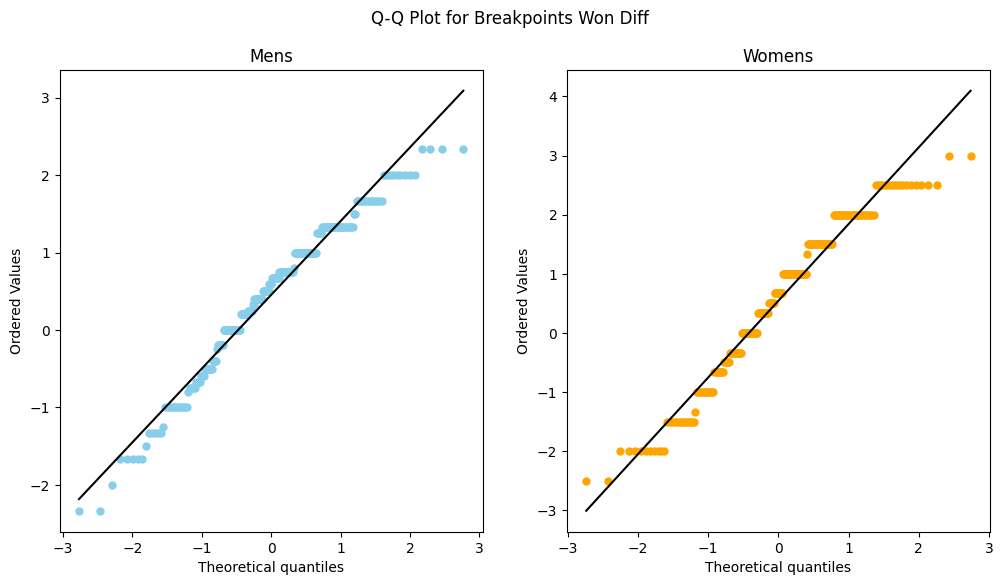

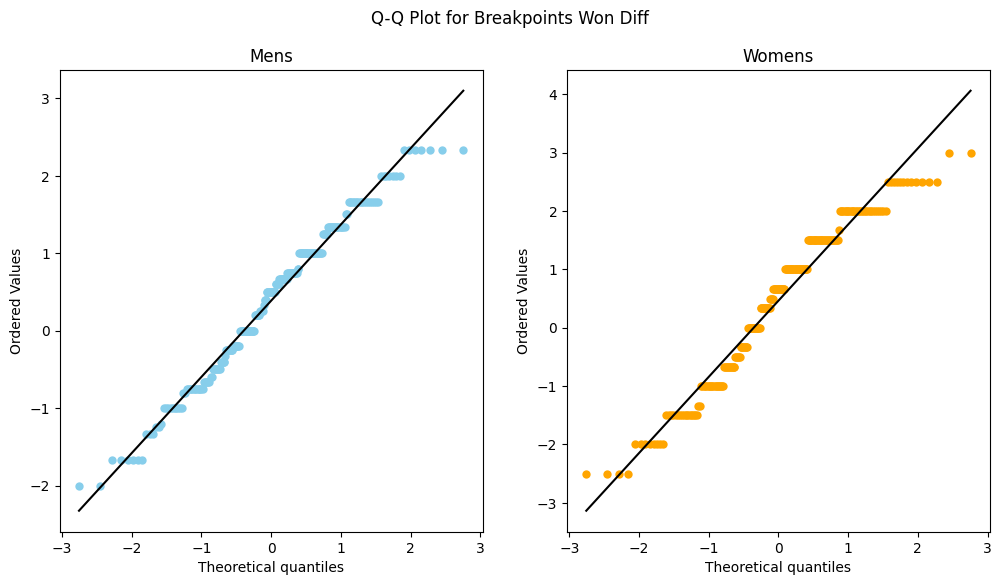

Summary Statistics for Double Faults Diff:
+-------------+-----------+------------+
| Statistic   |       Men |      Women |
+=============+===========+============+
| Mean        | -0.182182 | -0.0111111 |
+-------------+-----------+------------+
| Median      | -0.2      |  0         |
+-------------+-----------+------------+
| Variance    |  0.956998 |  2.07763   |
+-------------+-----------+------------+
| Skewness    | -0.186992 |  0.316988  |
+-------------+-----------+------------+
| Kurtosis    |  0.23164  |  0.554247  |
+-------------+-----------+------------+
+-------------------------+--------------+-------------+
| Test                    |    Statistic |     P-value |
+=========================+==============+=============+
| KS-test (Distribution)  |     0.135014 | 0.024333    |
+-------------------------+--------------+-------------+
| T-test (Means)          |    -1.51812  | 0.129658    |
+-------------------------+--------------+-------------+
| Mann-Whitney U         

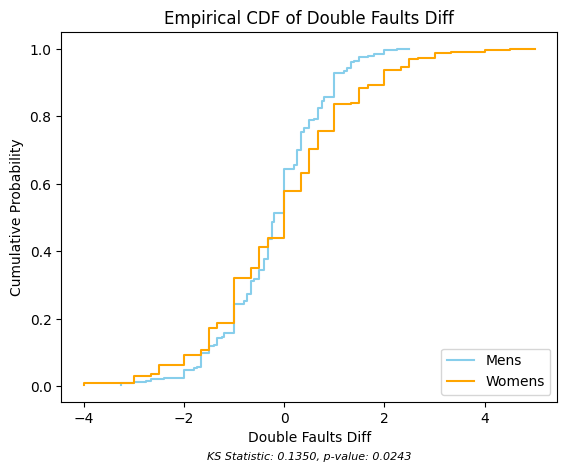

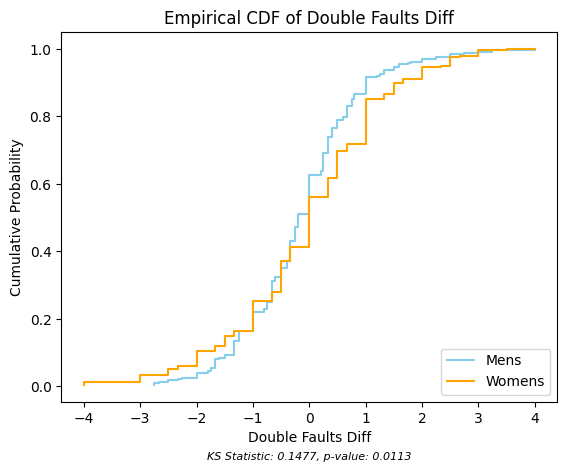

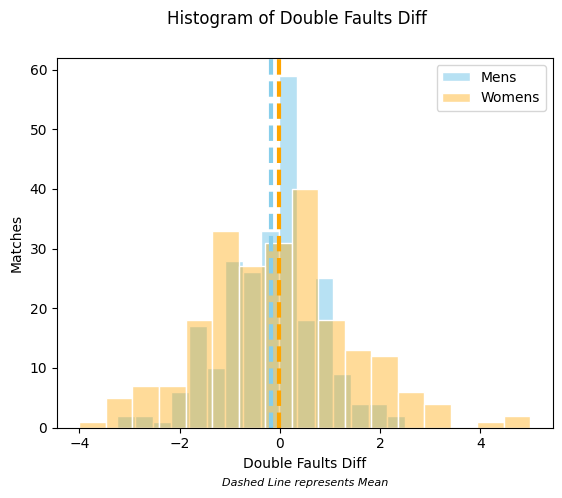

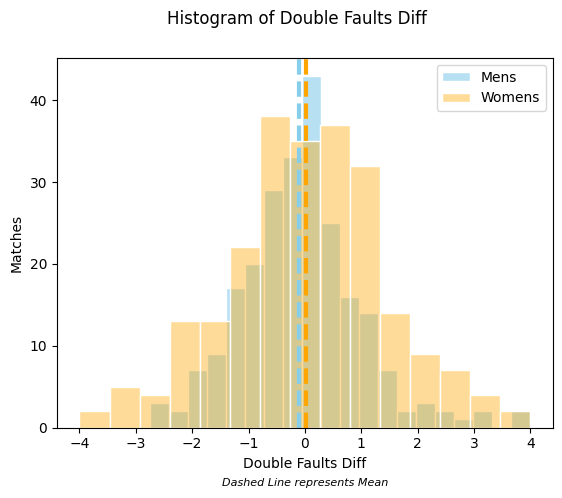

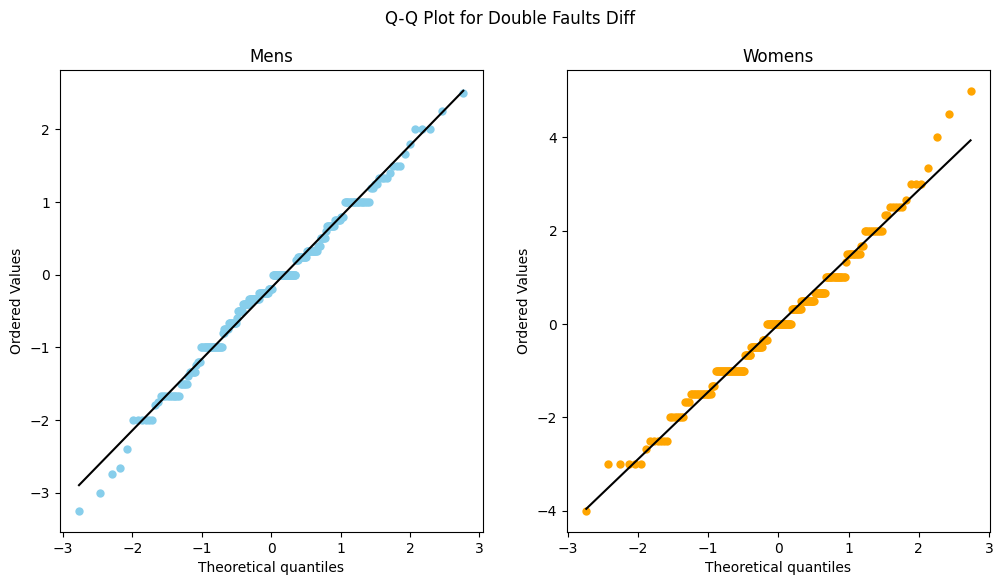

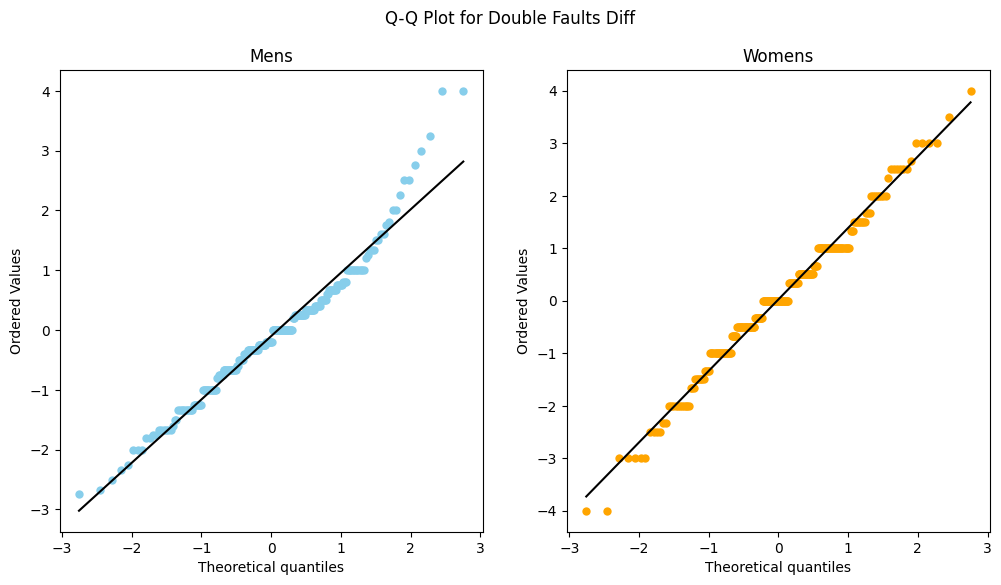

Summary Statistics for Errors Diff:
+-------------+-----------+-----------+
| Statistic   |       Men |     Women |
+=============+===========+===========+
| Mean        | -1.77547  | -1.58     |
+-------------+-----------+-----------+
| Median      | -2        | -2        |
+-------------+-----------+-----------+
| Variance    | 34.8273   | 41.2649   |
+-------------+-----------+-----------+
| Skewness    |  0.121342 |  0.398141 |
+-------------+-----------+-----------+
| Kurtosis    | -0.347624 |  0.31948  |
+-------------+-----------+-----------+
+-------------------------+---------------+-----------+
| Test                    |     Statistic |   P-value |
+=========================+===============+===========+
| KS-test (Distribution)  |     0.0670461 |  0.632745 |
+-------------------------+---------------+-----------+
| T-test (Means)          |    -0.344197  |  0.730852 |
+-------------------------+---------------+-----------+
| Mann-Whitney U          | 27581         |  0.94946

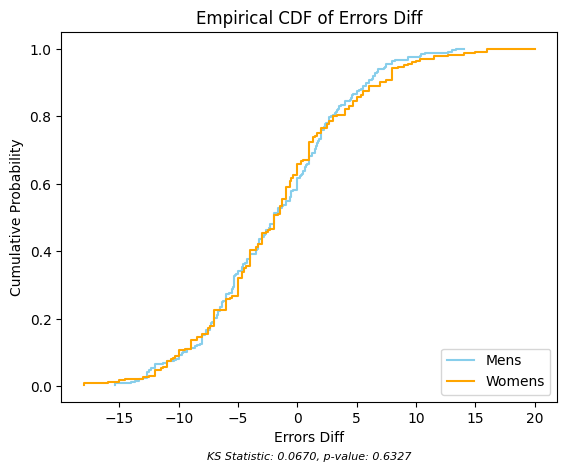

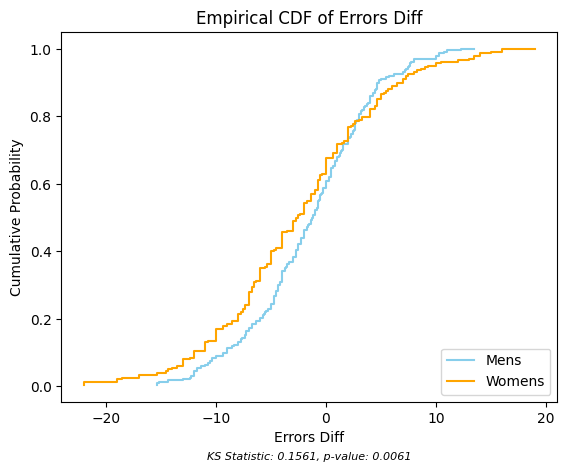

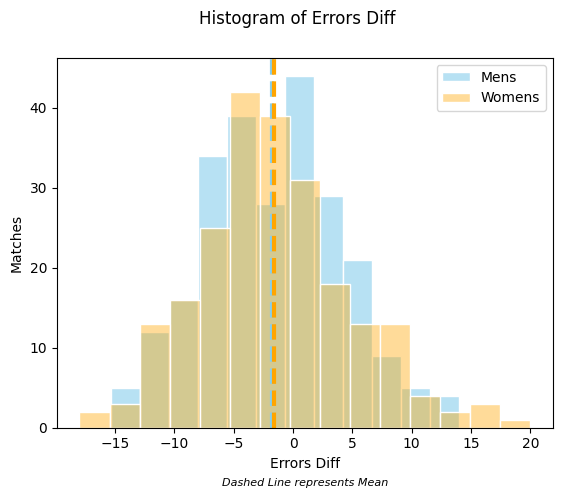

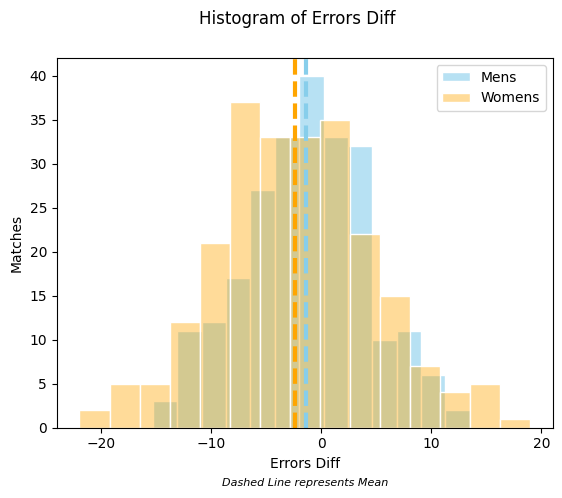

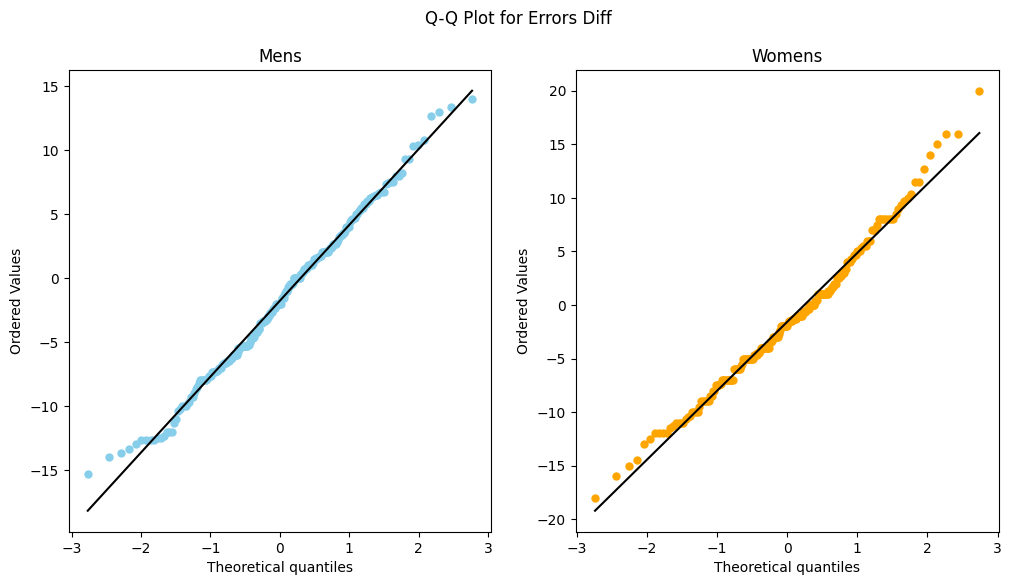

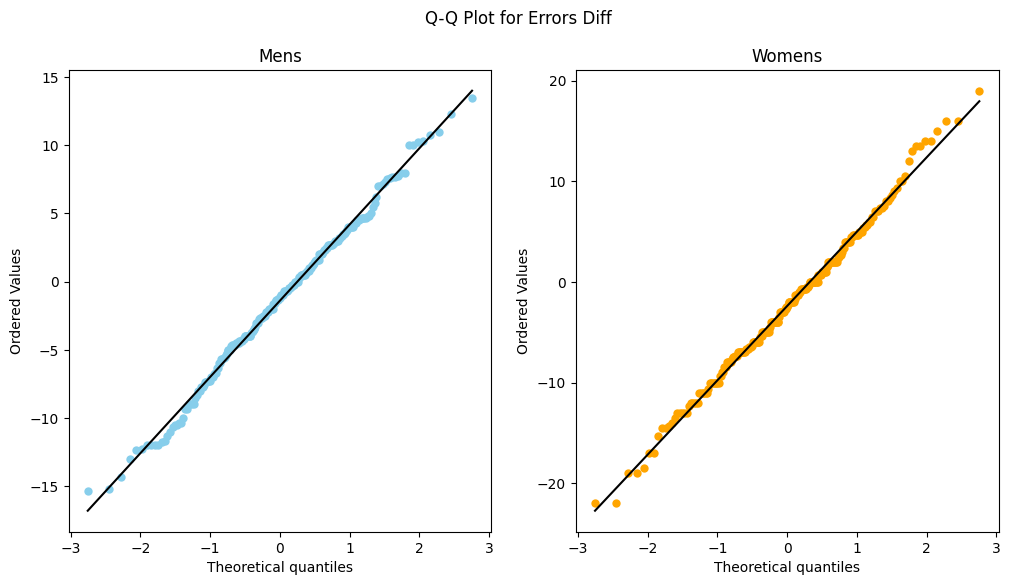

Summary Statistics for First Serve Points Won Diff:
+-------------+-------------+------------+
| Statistic   |         Men |      Women |
+=============+=============+============+
| Mean        |  0.713347   |  0.699259  |
+-------------+-------------+------------+
| Median      |  0.708333   |  1         |
+-------------+-------------+------------+
| Variance    |  8.41674    | 13.4905    |
+-------------+-------------+------------+
| Skewness    | -0.00690625 | -0.431756  |
+-------------+-------------+------------+
| Kurtosis    |  0.0281253  | -0.0870354 |
+-------------+-------------+------------+
+-------------------------+---------------+------------+
| Test                    |     Statistic |    P-value |
+=========================+===============+============+
| KS-test (Distribution)  |     0.116748  | 0.0731341  |
+-------------------------+---------------+------------+
| T-test (Means)          |     0.0463843 | 0.963024   |
+-------------------------+---------------+----

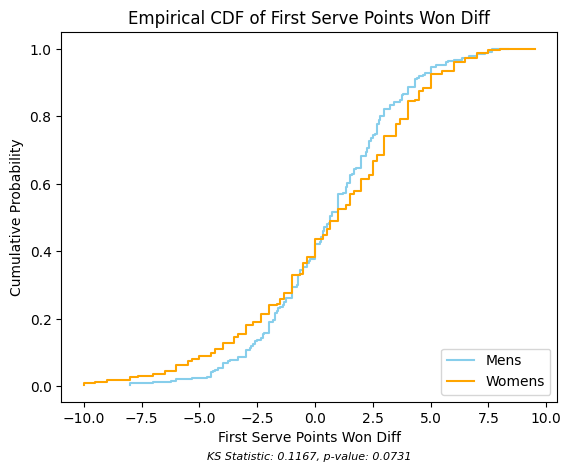

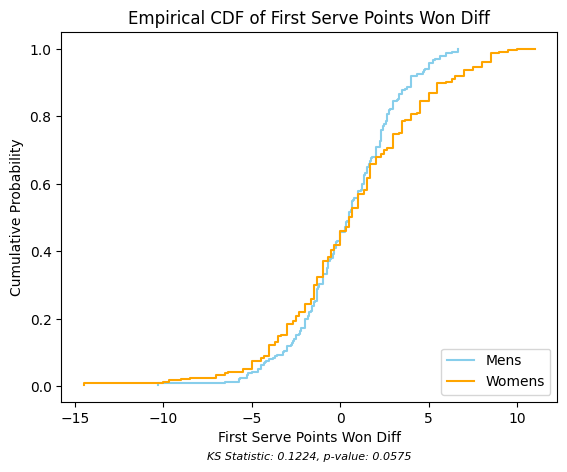

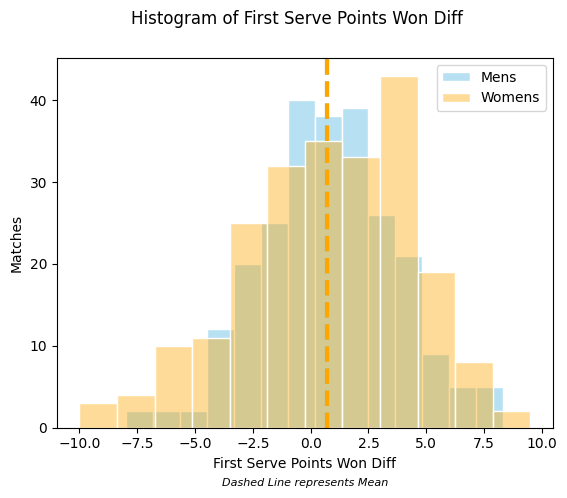

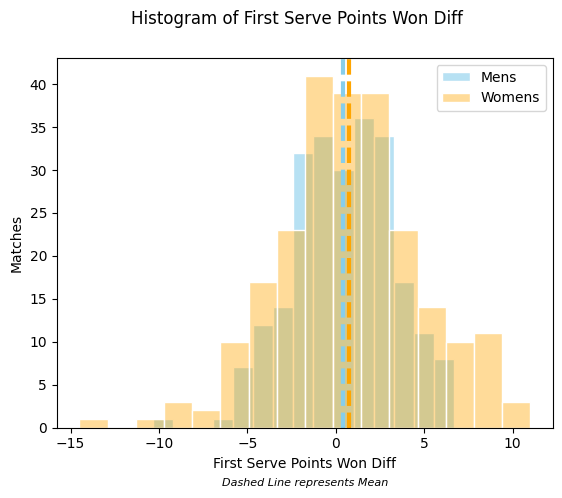

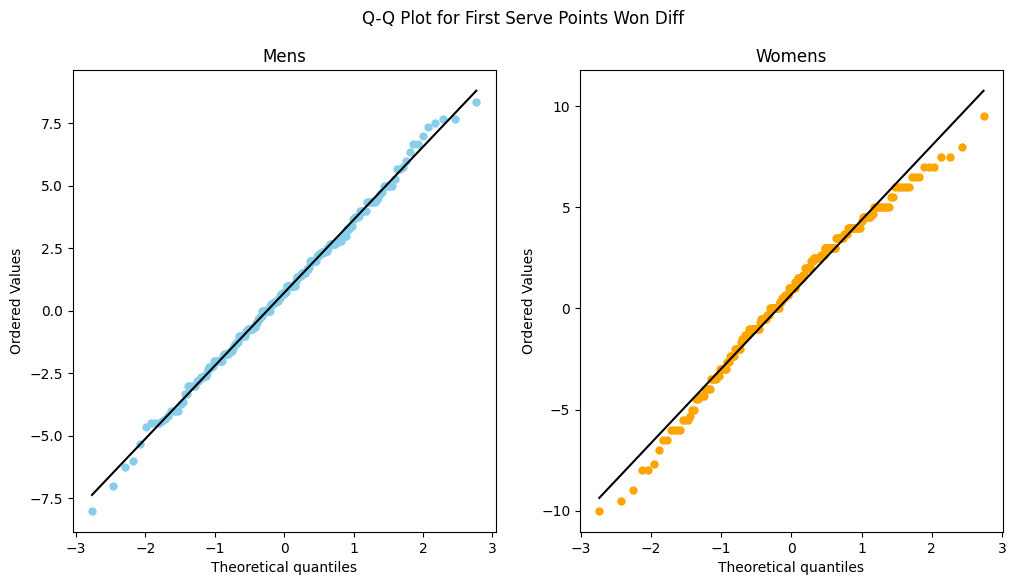

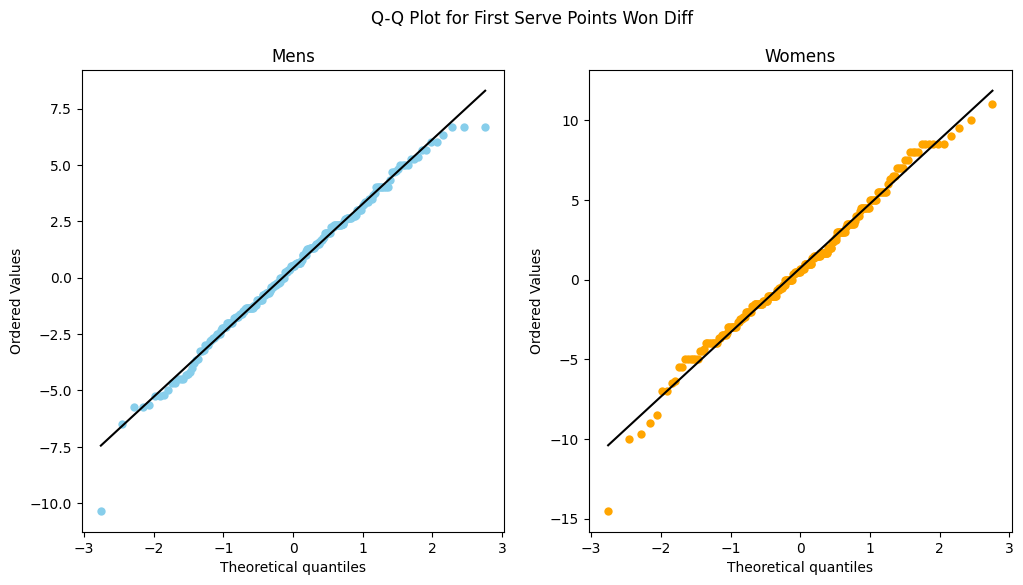

Summary Statistics for First Serve Successful Diff:
+-------------+-----------+------------+
| Statistic   |       Men |      Women |
+=============+===========+============+
| Mean        | -0.391938 | -0.658519  |
+-------------+-----------+------------+
| Median      |  0        | -0.5       |
+-------------+-----------+------------+
| Variance    | 15.7095   | 22.0695    |
+-------------+-----------+------------+
| Skewness    | -0.134963 | -0.0961546 |
+-------------+-----------+------------+
| Kurtosis    |  0.283321 |  0.655648  |
+-------------+-----------+------------+
+-------------------------+---------------+-----------+
| Test                    |     Statistic |   P-value |
+=========================+===============+===========+
| KS-test (Distribution)  |     0.0771816 | 0.455352  |
+-------------------------+---------------+-----------+
| T-test (Means)          |     0.667437  | 0.504821  |
+-------------------------+---------------+-----------+
| Mann-Whitney U       

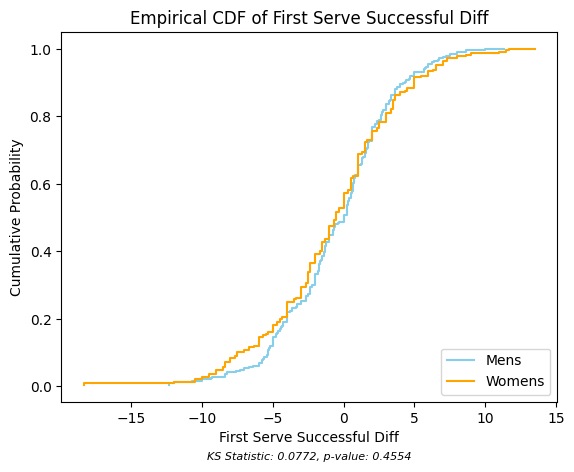

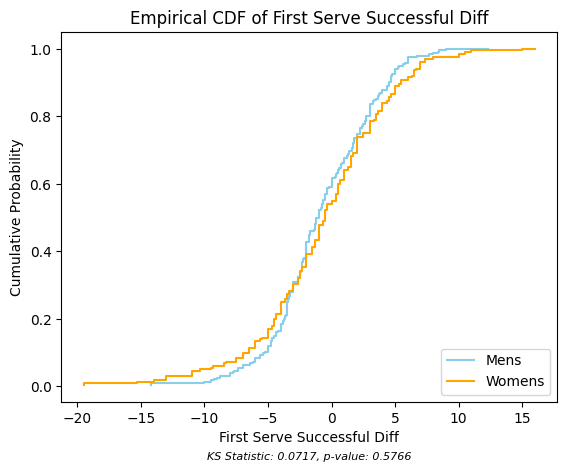

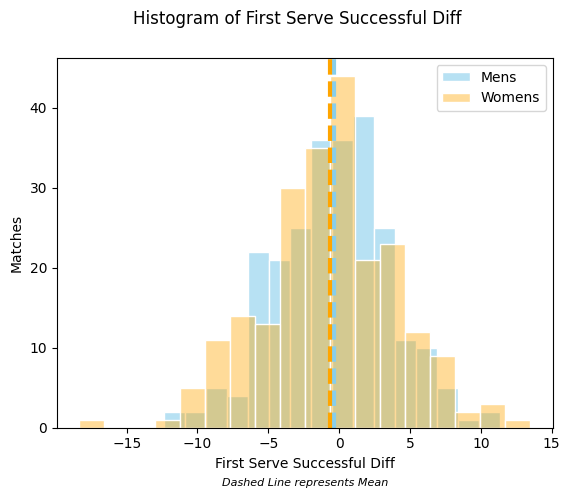

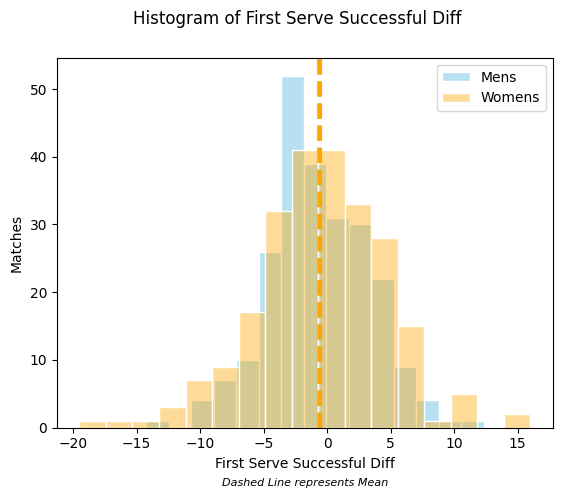

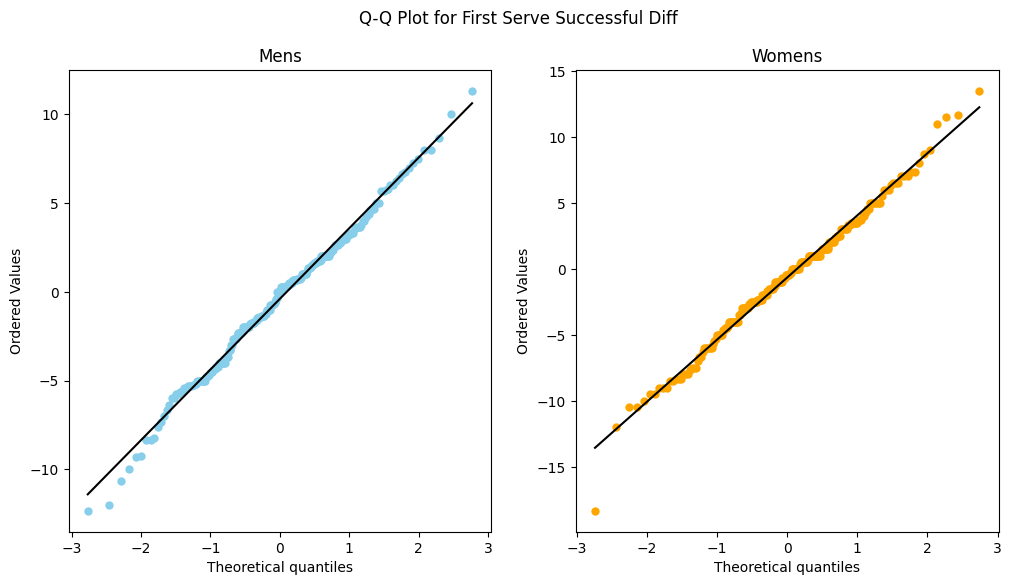

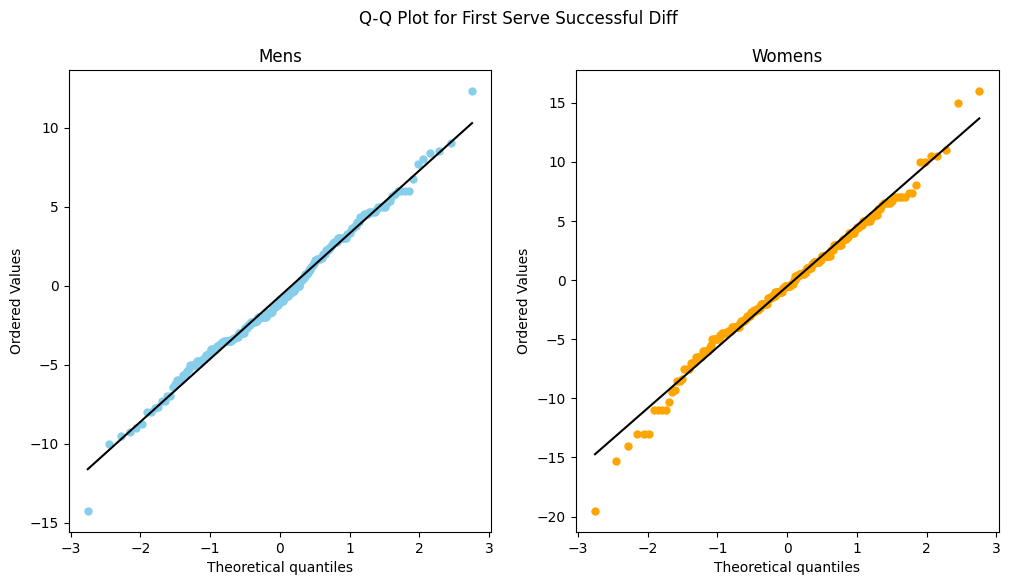

Summary Statistics for Games Won Diff:
+-------------+-----------+-----------+
| Statistic   |       Men |     Women |
+=============+===========+===========+
| Mean        |  0.953726 |  1.10222  |
+-------------+-----------+-----------+
| Median      |  1.41667  |  1.5      |
+-------------+-----------+-----------+
| Variance    |  4.06834  |  7.06143  |
+-------------+-----------+-----------+
| Skewness    | -0.517992 | -0.347119 |
+-------------+-----------+-----------+
| Kurtosis    | -0.371775 | -0.877419 |
+-------------+-----------+-----------+
+-------------------------+--------------+-------------+
| Test                    |    Statistic |     P-value |
+=========================+==============+=============+
| KS-test (Distribution)  |     0.160163 | 0.00411742  |
+-------------------------+--------------+-------------+
| T-test (Means)          |    -0.686539 | 0.492712    |
+-------------------------+--------------+-------------+
| Mann-Whitney U          | 25882.5      |

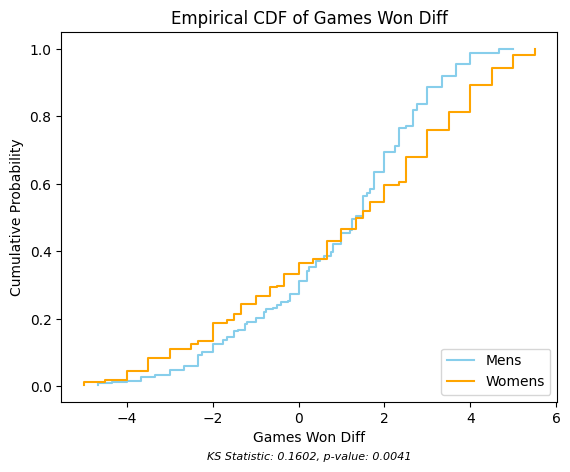

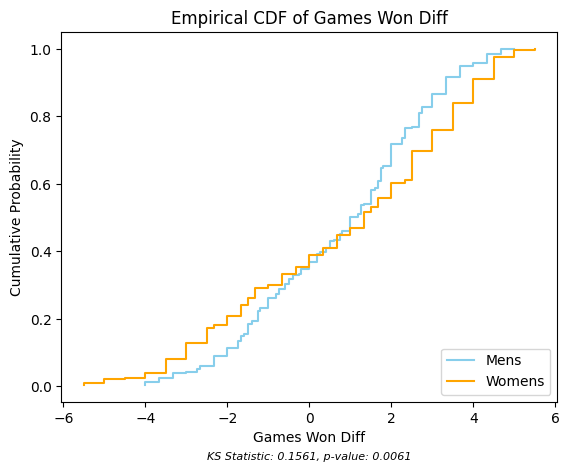

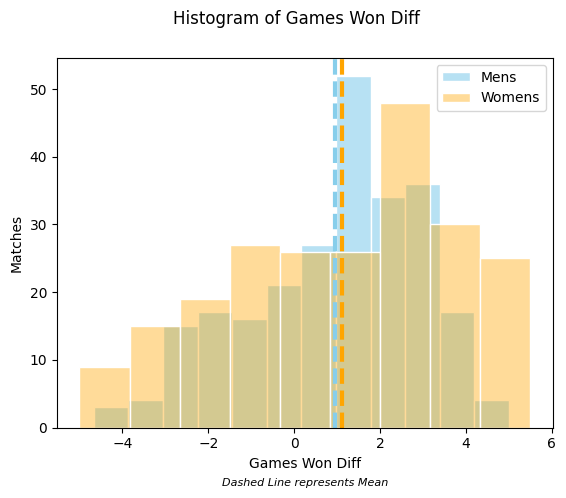

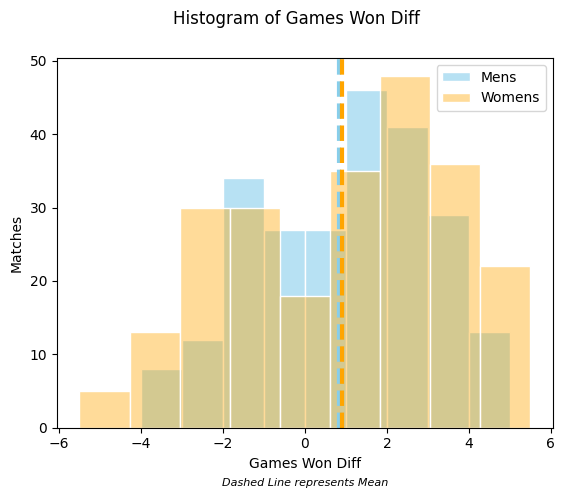

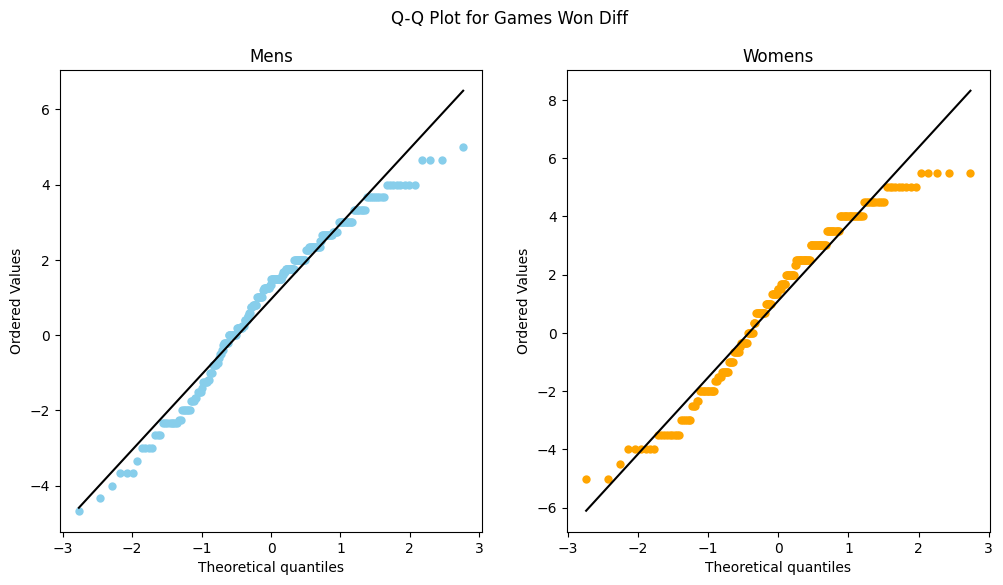

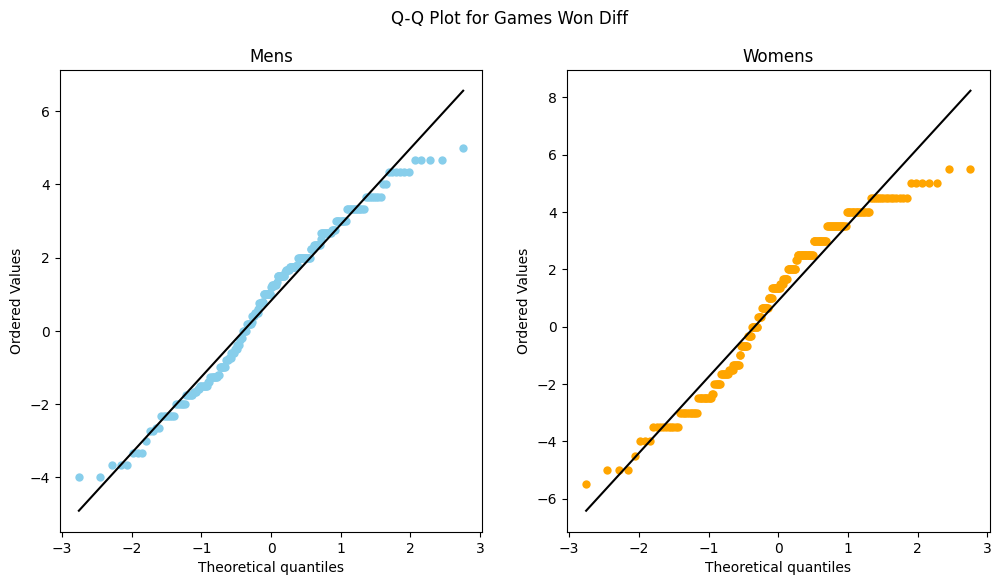

Summary Statistics for Max Games In A Row Diff:
+-------------+------------+-----------+
| Statistic   |        Men |     Women |
+=============+============+===========+
| Mean        |  1.10569   |  1.14222  |
+-------------+------------+-----------+
| Median      |  1         |  1        |
+-------------+------------+-----------+
| Variance    |  8.21736   |  9.60468  |
+-------------+------------+-----------+
| Skewness    | -0.0647006 | -0.108916 |
+-------------+------------+-----------+
| Kurtosis    |  1.08285   |  0.373446 |
+-------------+------------+-----------+
+-------------------------+---------------+-----------+
| Test                    |     Statistic |   P-value |
+=========================+===============+===========+
| KS-test (Distribution)  |     0.0450407 |  0.958716 |
+-------------------------+---------------+-----------+
| T-test (Means)          |    -0.132894  |  0.894334 |
+-------------------------+---------------+-----------+
| Mann-Whitney U          |

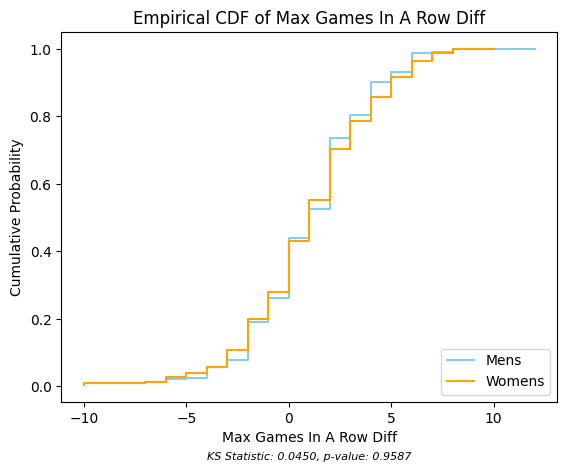

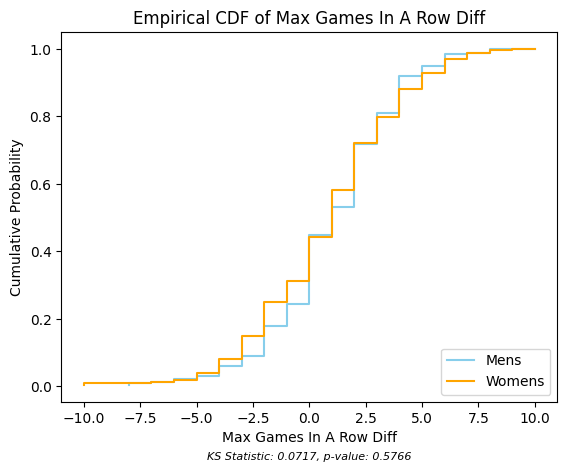

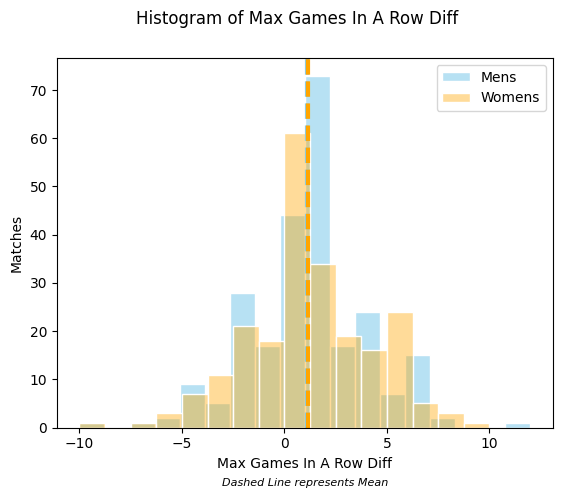

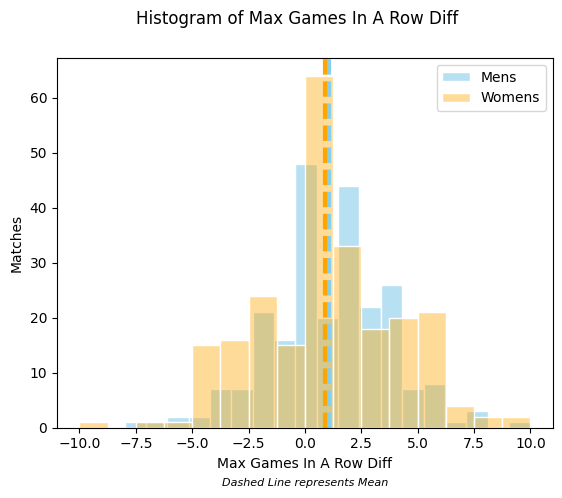

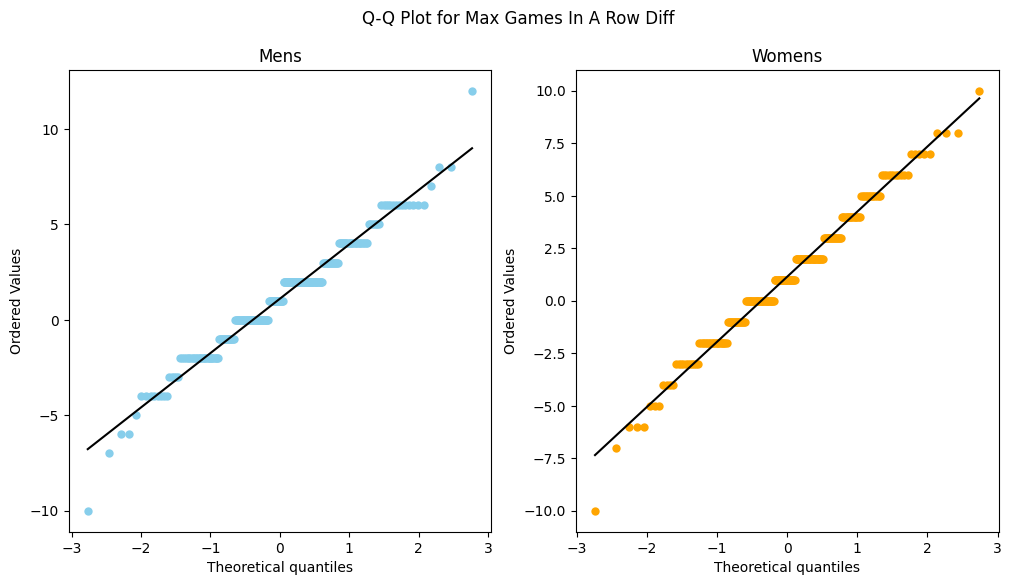

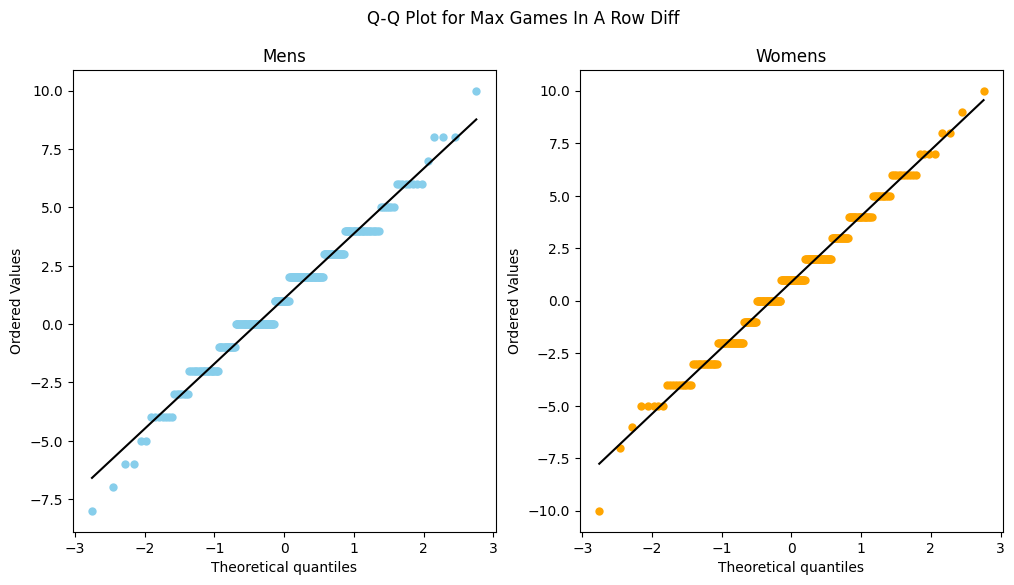

Summary Statistics for Max Points In A Row Diff:
+-------------+-------------+-----------+
| Statistic   |         Men |     Women |
+=============+=============+===========+
| Mean        |  1.02033    |  1.03556  |
+-------------+-------------+-----------+
| Median      |  1          |  1        |
+-------------+-------------+-----------+
| Variance    |  9.13836    | 11.2398   |
+-------------+-------------+-----------+
| Skewness    | -0.00348224 |  0.353053 |
+-------------+-------------+-----------+
| Kurtosis    |  1.88457    |  1.66747  |
+-------------+-------------+-----------+
+-------------------------+---------------+-----------+
| Test                    |     Statistic |   P-value |
+=========================+===============+===========+
| KS-test (Distribution)  |     0.0607588 |  0.746912 |
+-------------------------+---------------+-----------+
| T-test (Means)          |    -0.0518437 |  0.958675 |
+-------------------------+---------------+-----------+
| Mann-Whitne

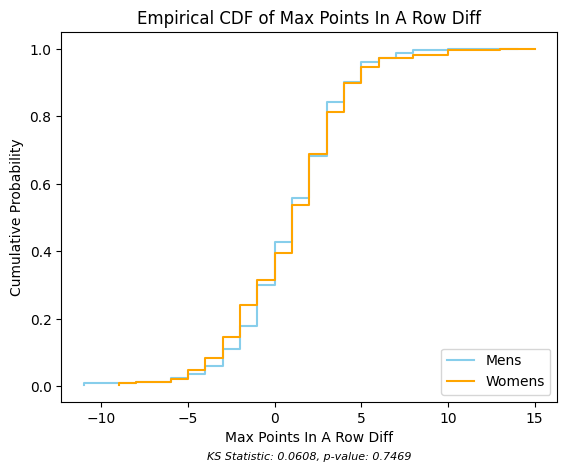

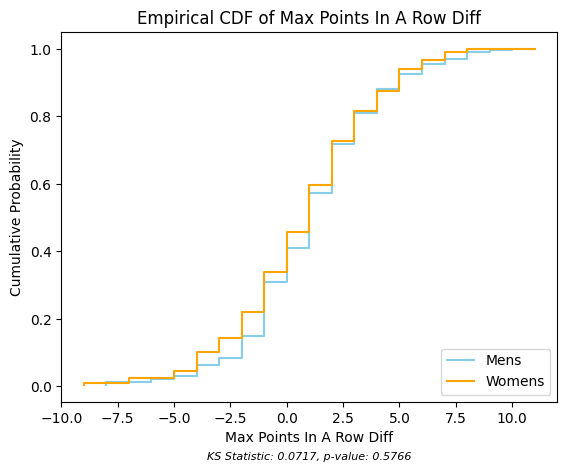

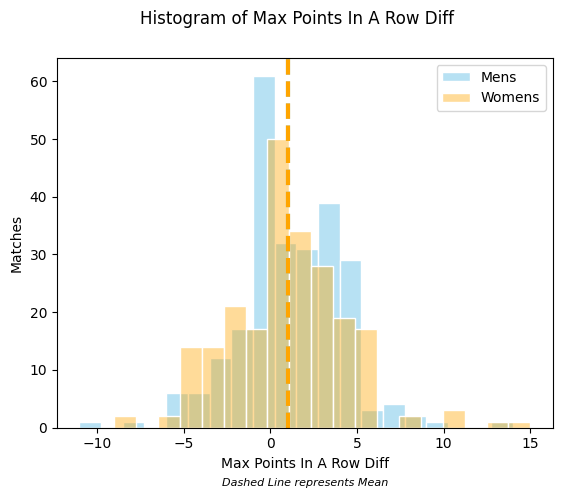

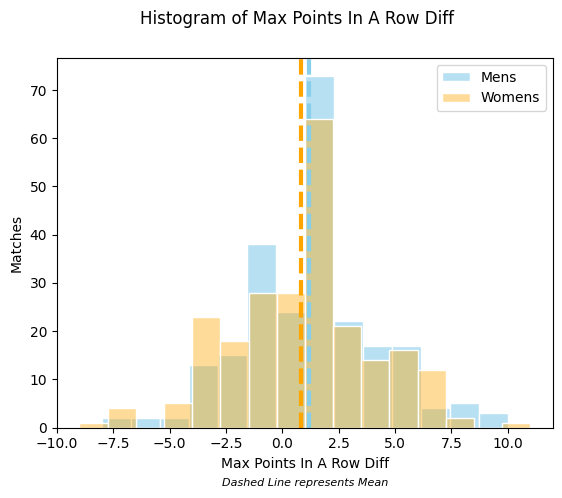

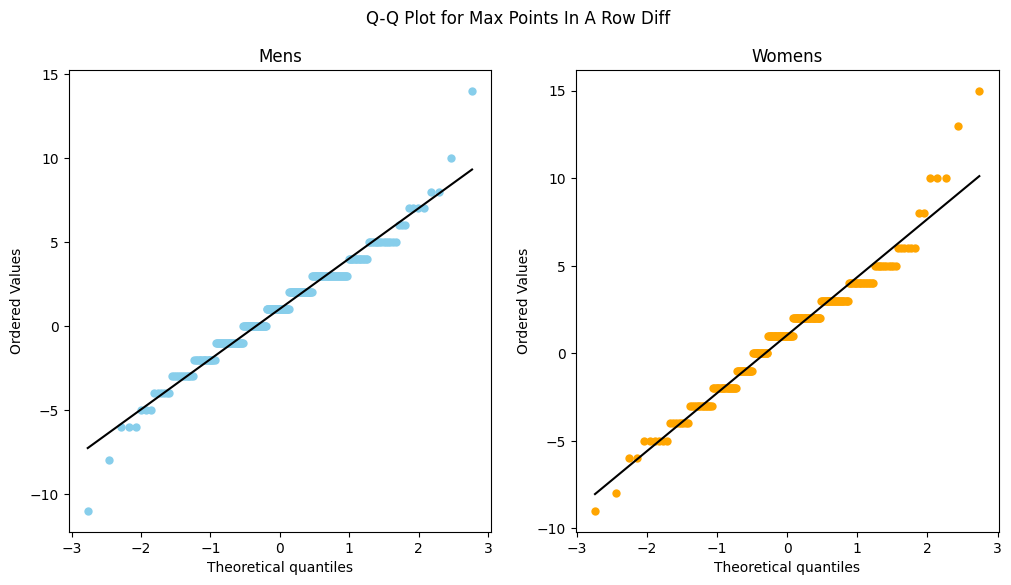

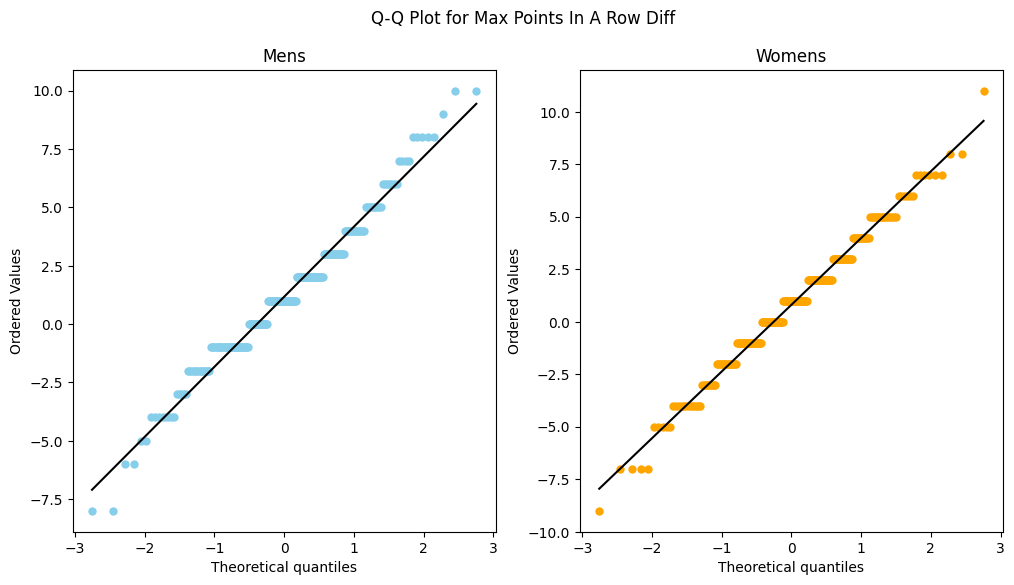

/var/folders/7_/mtdhgw6s63dc18509m14sztm0000gn/T/ipykernel_60050/3024563390.py:70: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  m_results = stats.describe(m_dist)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1383: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  sk = skew(a, axis, bias=bias)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1384: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt = kurtosis(a, axis, bias=bias)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-pack

Summary Statistics for Men:
+-------------+-------+---------+
| Statistic   |   Men |   Women |
+=============+=======+=========+
| Mean        |     1 |       0 |
+-------------+-------+---------+
| Median      |     1 |       0 |
+-------------+-------+---------+
| Variance    |     0 |       0 |
+-------------+-------+---------+
| Skewness    |   nan |     nan |
+-------------+-------+---------+
| Kurtosis    |   nan |     nan |
+-------------+-------+---------+
+-------------------------+-------------+----------------+
| Test                    |   Statistic |        P-value |
+=========================+=============+================+
| KS-test (Distribution)  |           1 |   1.42448e-140 |
+-------------------------+-------------+----------------+
| T-test (Means)          |         inf |   0            |
+-------------------------+-------------+----------------+
| Mann-Whitney U          |       55350 |   3.23195e-104 |
+-------------------------+-------------+----------------+

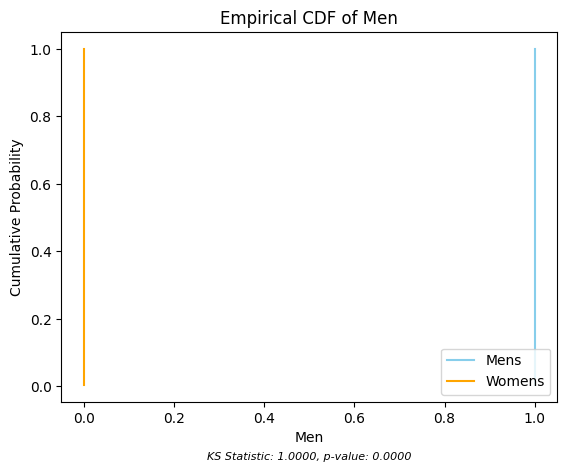

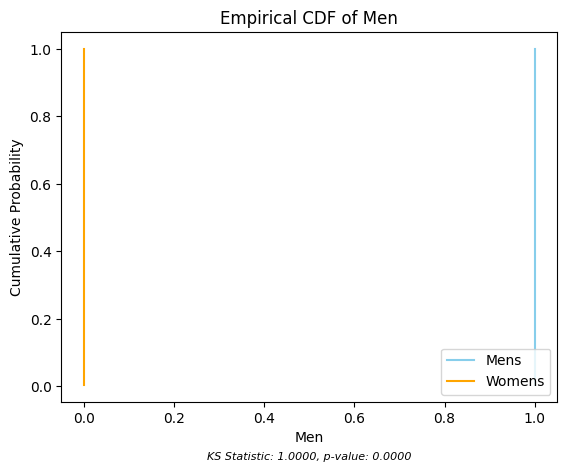

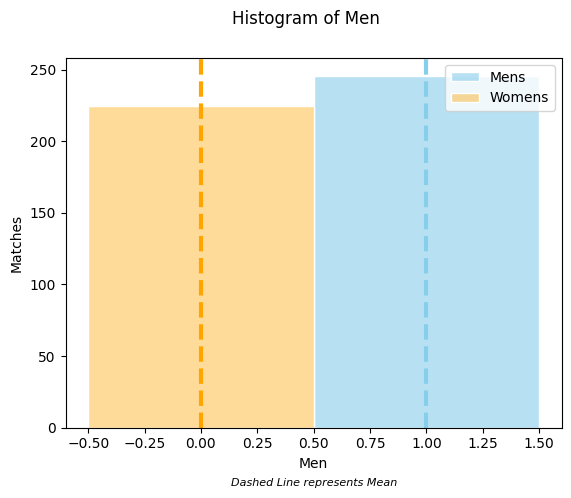

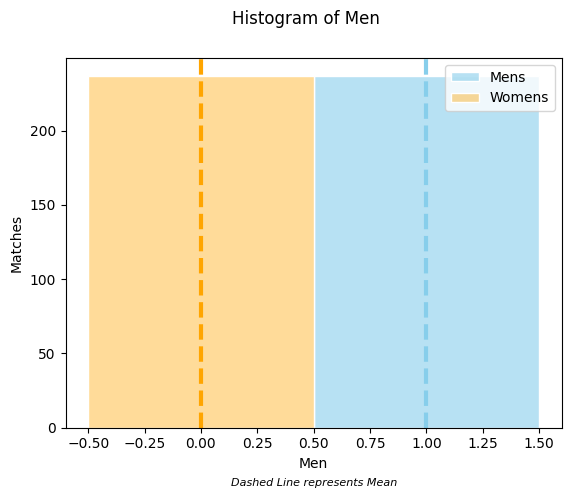

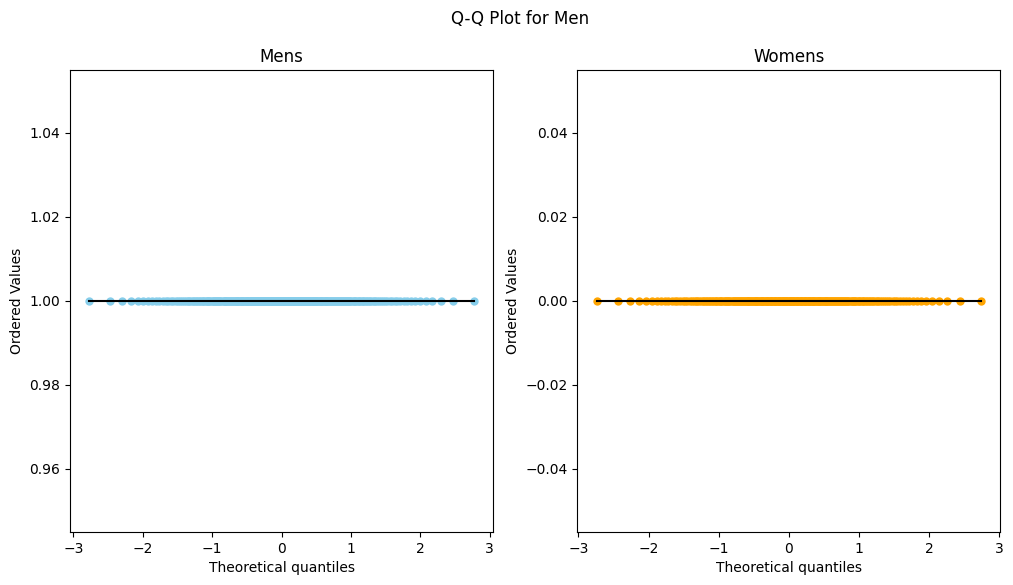

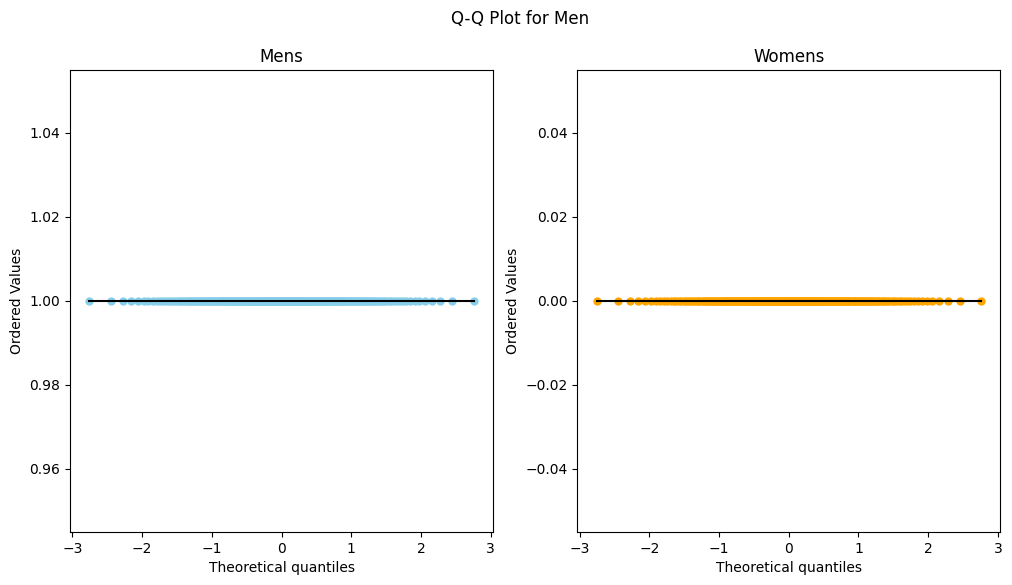

Summary Statistics for Points Won Diff:
+-------------+-----------+-----------+
| Statistic   |       Men |     Women |
+=============+===========+===========+
| Mean        |  2.83848  |  3.14519  |
+-------------+-----------+-----------+
| Median      |  4.2      |  4.66667  |
+-------------+-----------+-----------+
| Variance    | 34.0068   | 54.2159   |
+-------------+-----------+-----------+
| Skewness    | -0.497739 | -0.390227 |
+-------------+-----------+-----------+
| Kurtosis    | -0.537876 | -0.765674 |
+-------------+-----------+-----------+
+-------------------------+--------------+-------------+
| Test                    |    Statistic |     P-value |
+=========================+==============+=============+
| KS-test (Distribution)  |     0.135176 | 0.0240735   |
+-------------------------+--------------+-------------+
| T-test (Means)          |    -0.503187 | 0.615069    |
+-------------------------+--------------+-------------+
| Mann-Whitney U          | 26138        

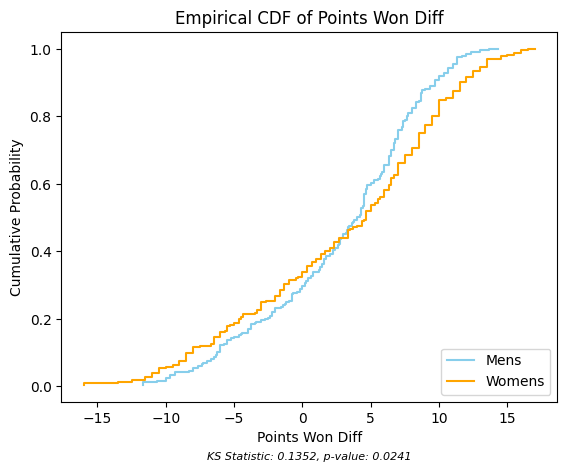

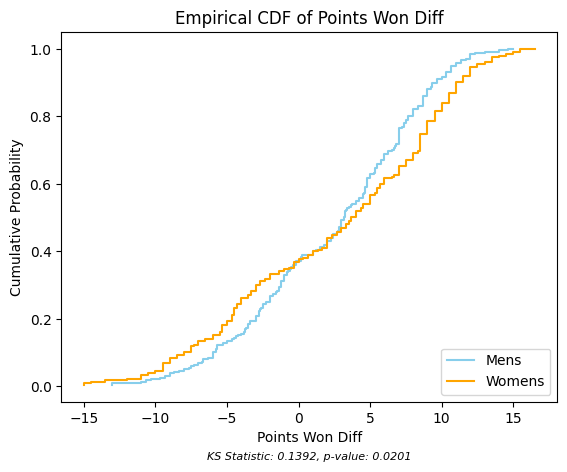

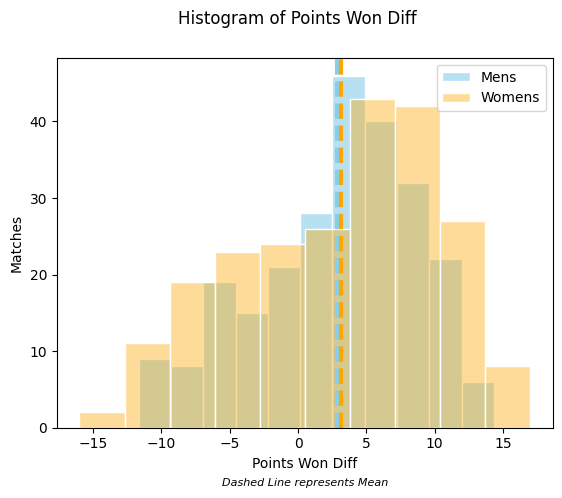

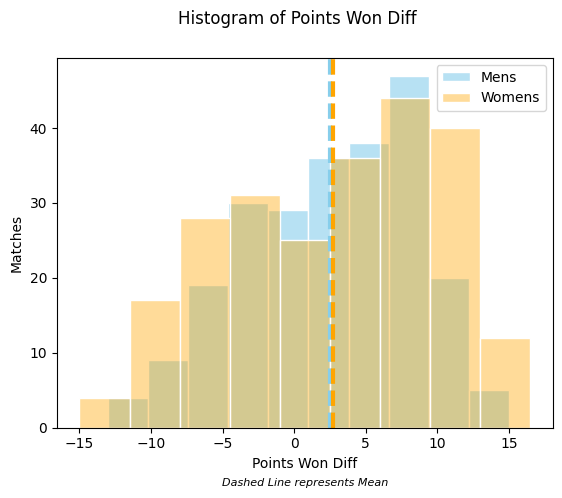

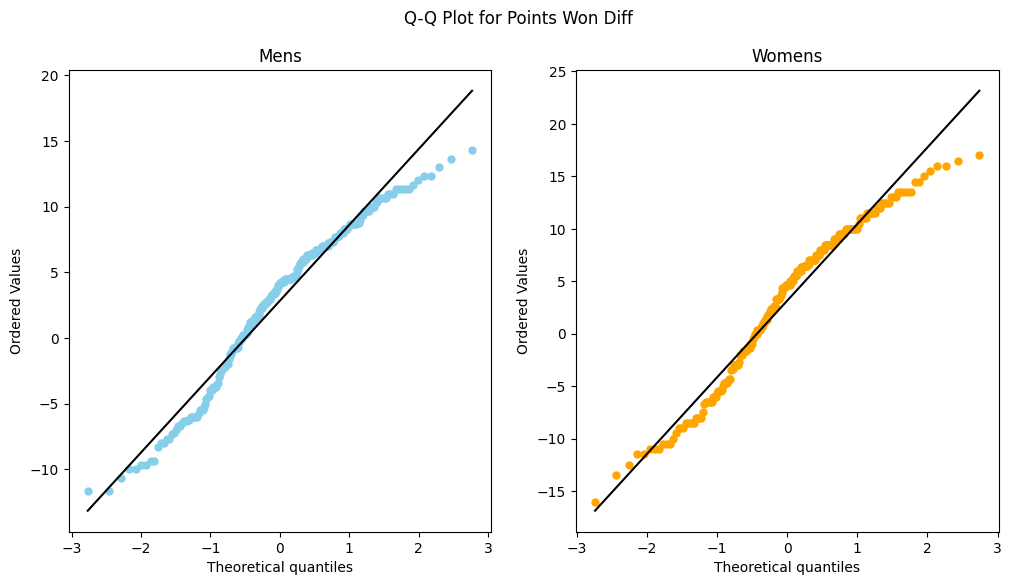

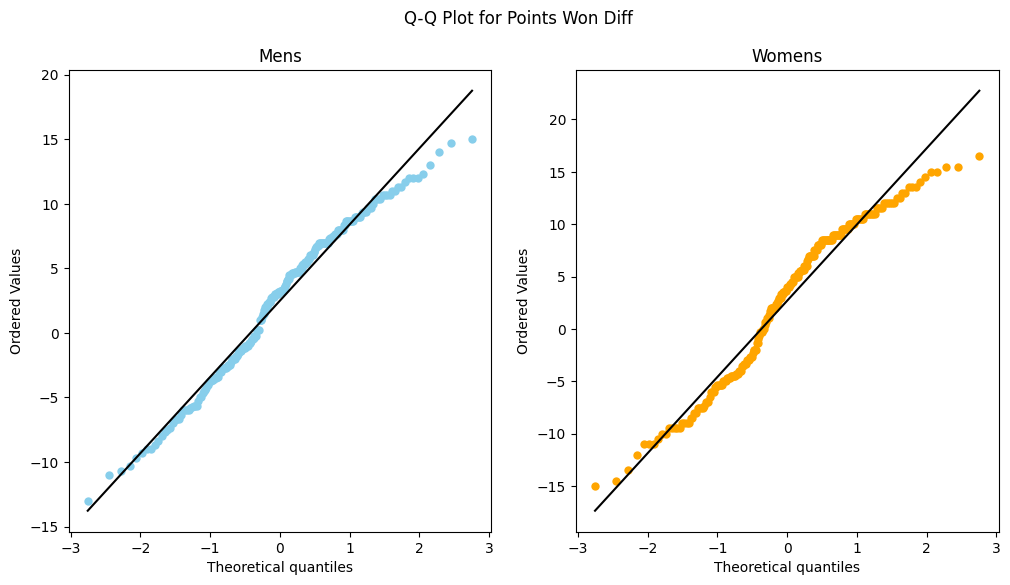

Summary Statistics for Points Won From Last 10 Diff:
+-------------+-----------+-----------+
| Statistic   |       Men |     Women |
+=============+===========+===========+
| Mean        |  0.34458  |  0.52     |
+-------------+-----------+-----------+
| Median      |  0.5      |  1        |
+-------------+-----------+-----------+
| Variance    |  1.12441  |  3.56421  |
+-------------+-----------+-----------+
| Skewness    | -0.333218 | -0.376425 |
+-------------+-----------+-----------+
| Kurtosis    | -0.321776 | -0.272555 |
+-------------+-----------+-----------+
+-------------------------+--------------+-------------+
| Test                    |    Statistic |     P-value |
+=========================+==============+=============+
| KS-test (Distribution)  |     0.251274 | 5.04614e-07 |
+-------------------------+--------------+-------------+
| T-test (Means)          |    -1.25672  | 0.20948     |
+-------------------------+--------------+-------------+
| Mann-Whitney U          | 

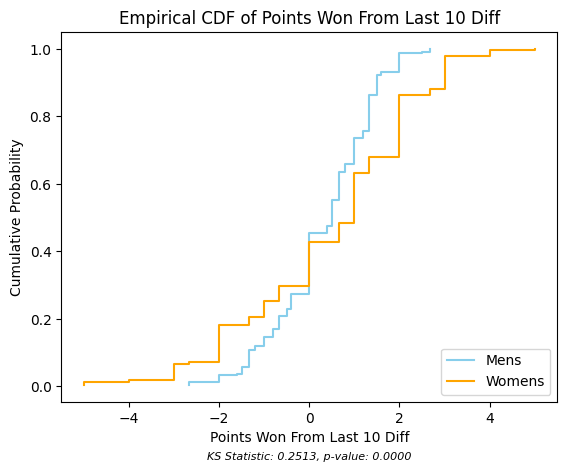

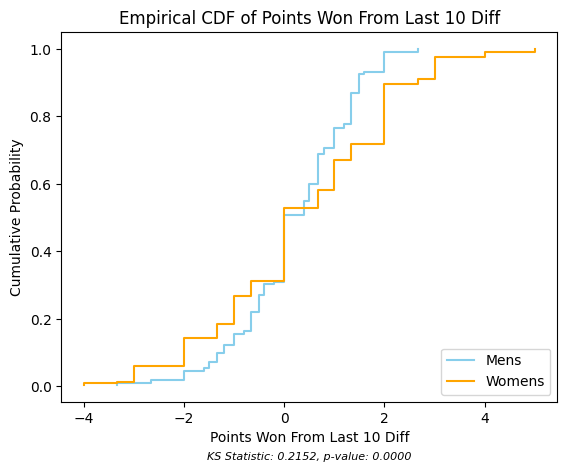

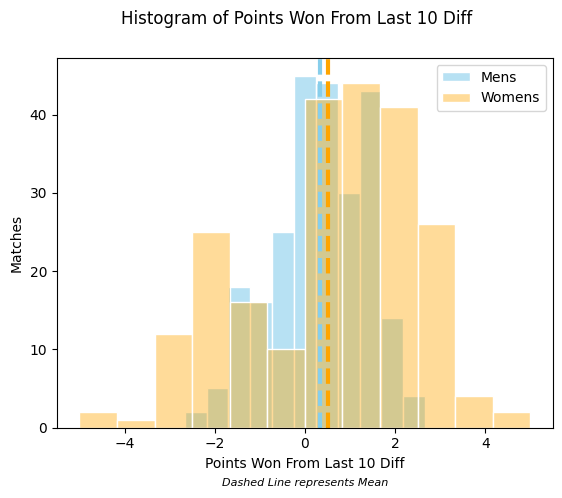

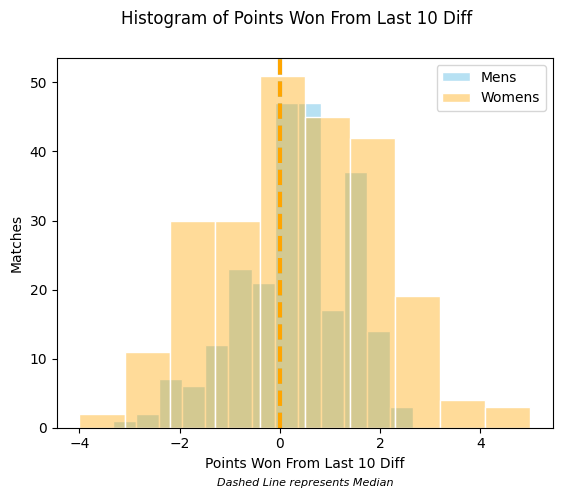

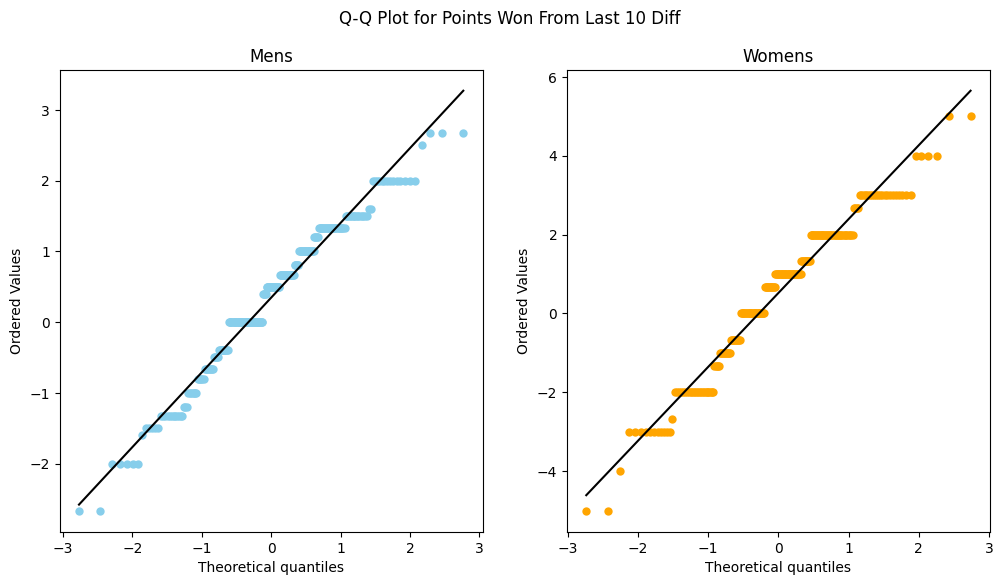

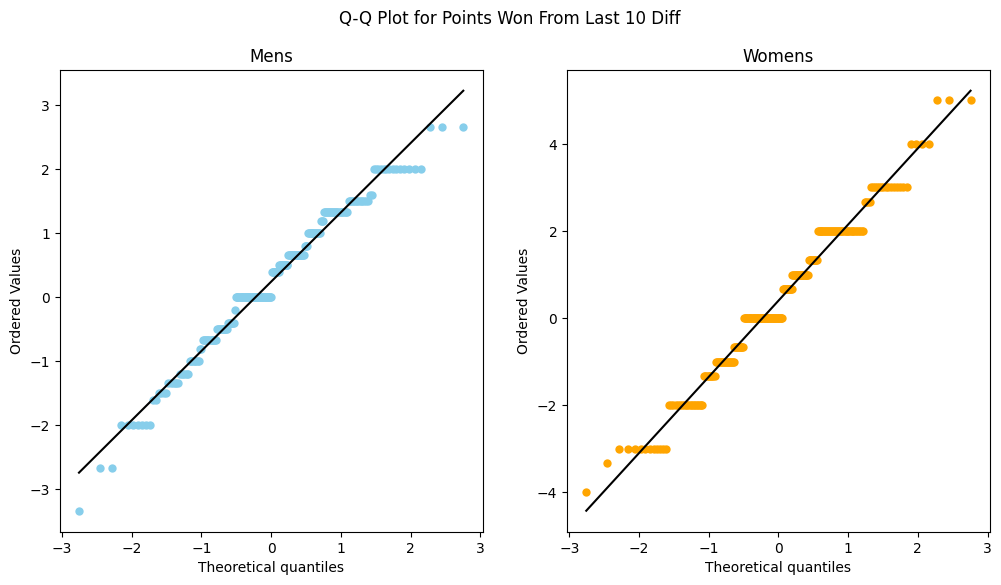

Summary Statistics for Rs Diff:
+-------------+-------------+-------------+
| Statistic   |         Men |       Women |
+=============+=============+=============+
| Mean        |   -78.9431  |   -96.0756  |
+-------------+-------------+-------------+
| Median      |   -49       |   -48       |
+-------------+-------------+-------------+
| Variance    | 10397.3     | 20745.2     |
+-------------+-------------+-------------+
| Skewness    |    -3.23611 |    -3.58517 |
+-------------+-------------+-------------+
| Kurtosis    |    12.0938  |    15.5961  |
+-------------+-------------+-------------+
+-------------------------+---------------+-----------+
| Test                    |     Statistic |   P-value |
+=========================+===============+===========+
| KS-test (Distribution)  |     0.0536585 |  0.862551 |
+-------------------------+---------------+-----------+
| T-test (Means)          |     1.49955   |  0.134403 |
+-------------------------+---------------+-----------+
| Ma

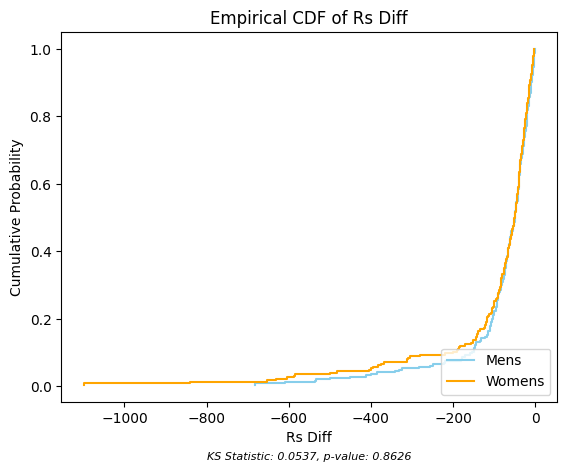

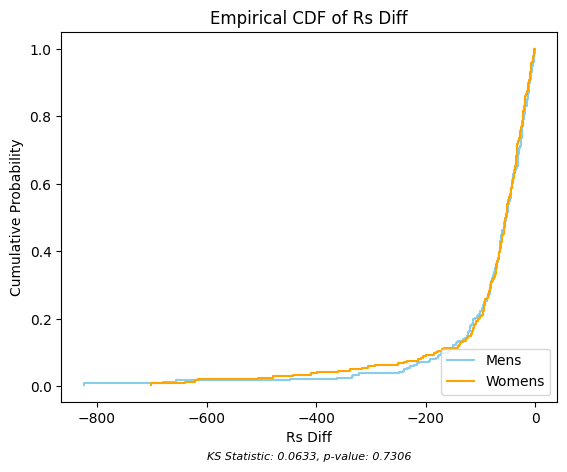

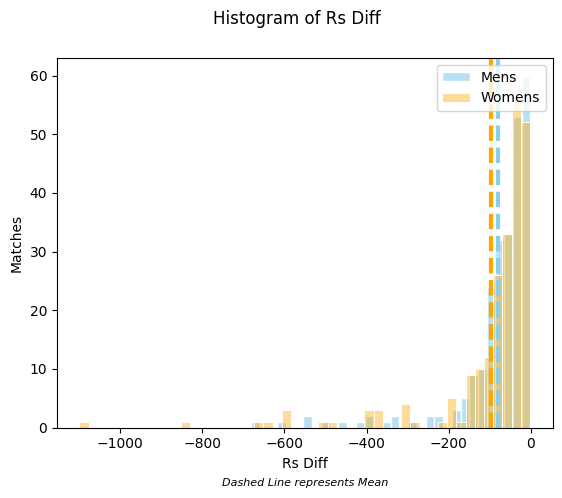

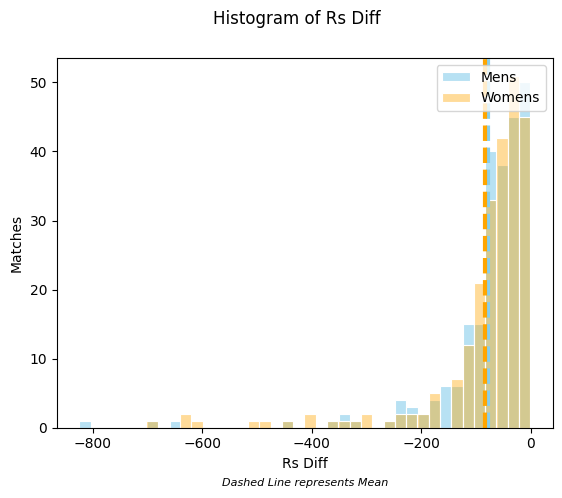

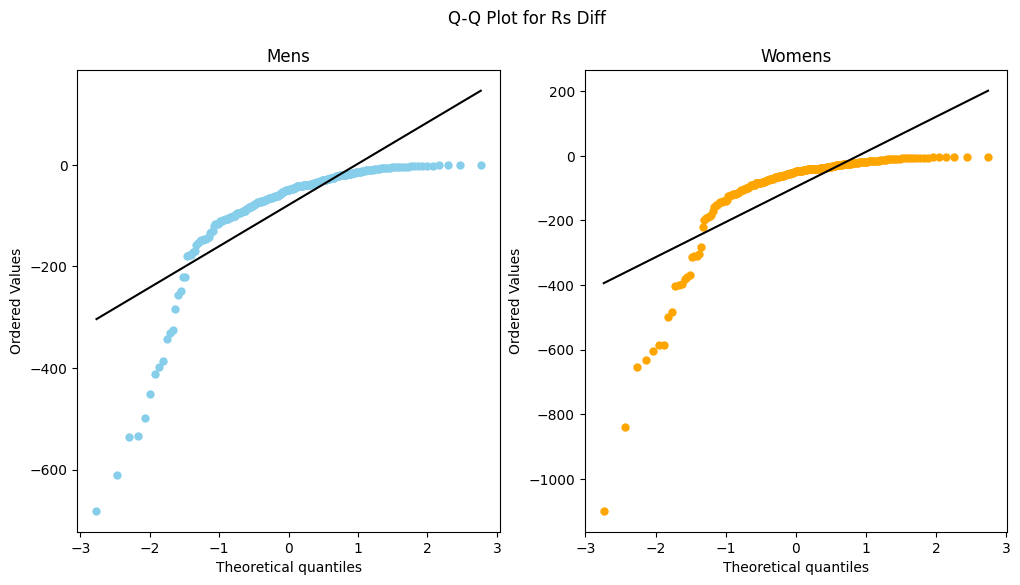

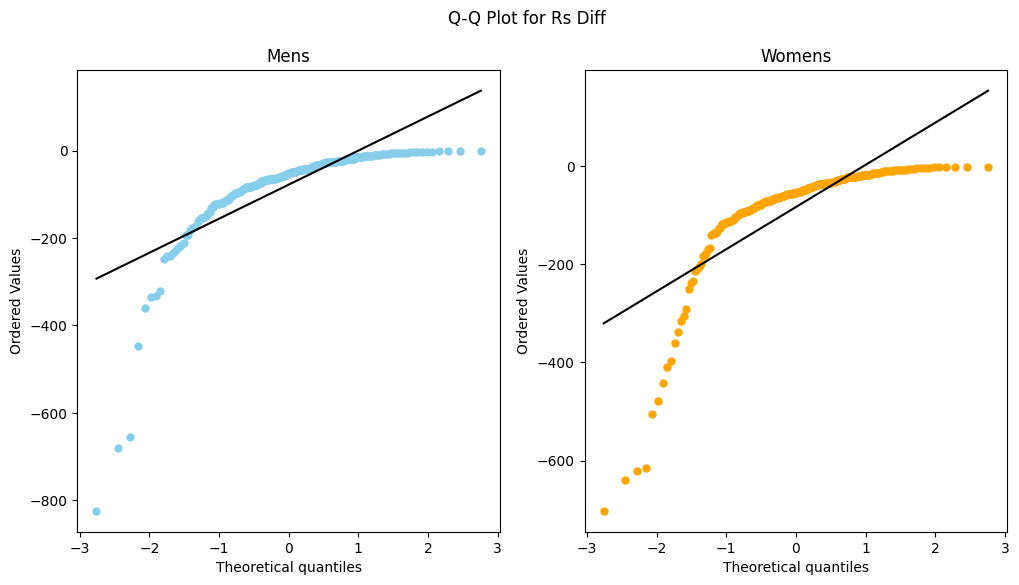

Summary Statistics for Second Serve Points Won Diff:
+-------------+------------+-----------+
| Statistic   |        Men |     Women |
+=============+============+===========+
| Mean        |  0.0361789 |  0.582222 |
+-------------+------------+-----------+
| Median      |  0         |  0.5      |
+-------------+------------+-----------+
| Variance    |  3.81635   |  5.55311  |
+-------------+------------+-----------+
| Skewness    |  0.0219715 | -0.164306 |
+-------------+------------+-----------+
| Kurtosis    | -0.158731  | -0.244813 |
+-------------+------------+-----------+
+-------------------------+--------------+------------+
| Test                    |    Statistic |    P-value |
+=========================+==============+============+
| KS-test (Distribution)  |     0.136802 | 0.0216592  |
+-------------------------+--------------+------------+
| T-test (Means)          |    -2.74627  | 0.00625953 |
+-------------------------+--------------+------------+
| Mann-Whitney U      

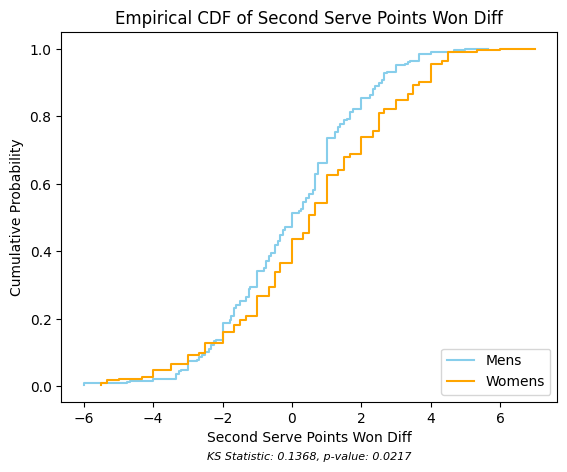

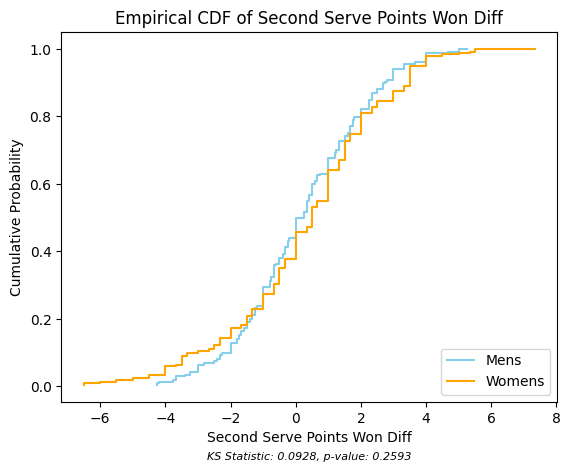

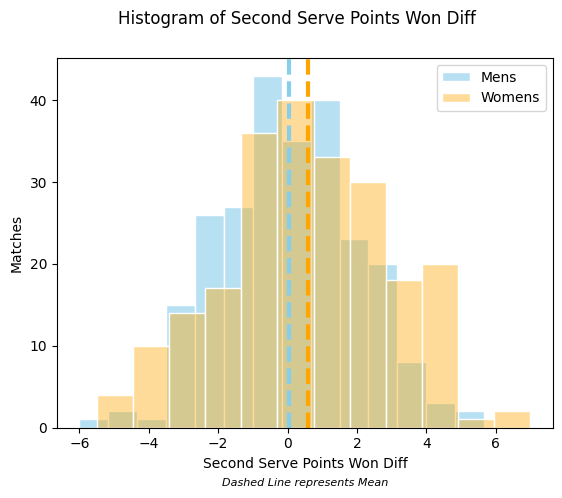

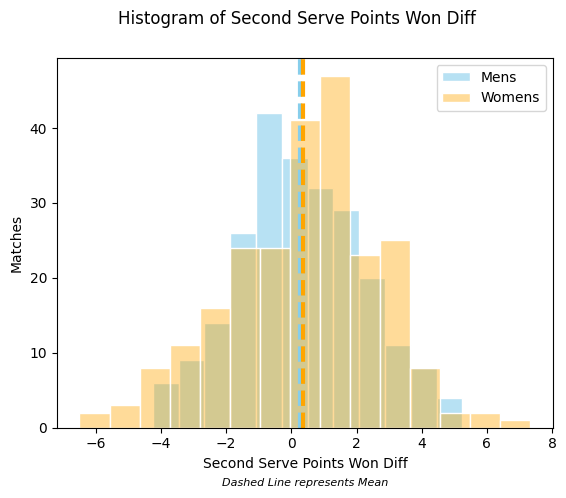

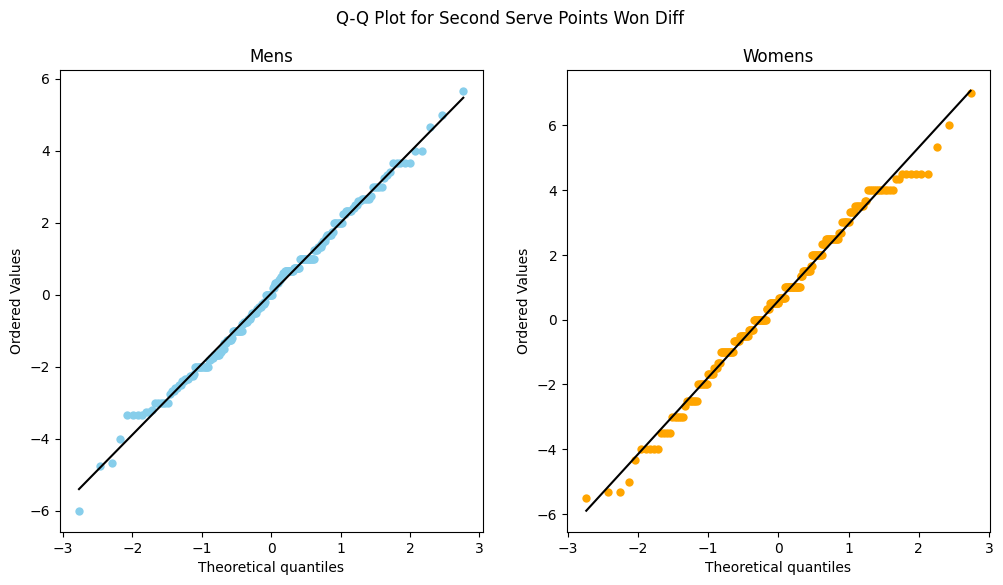

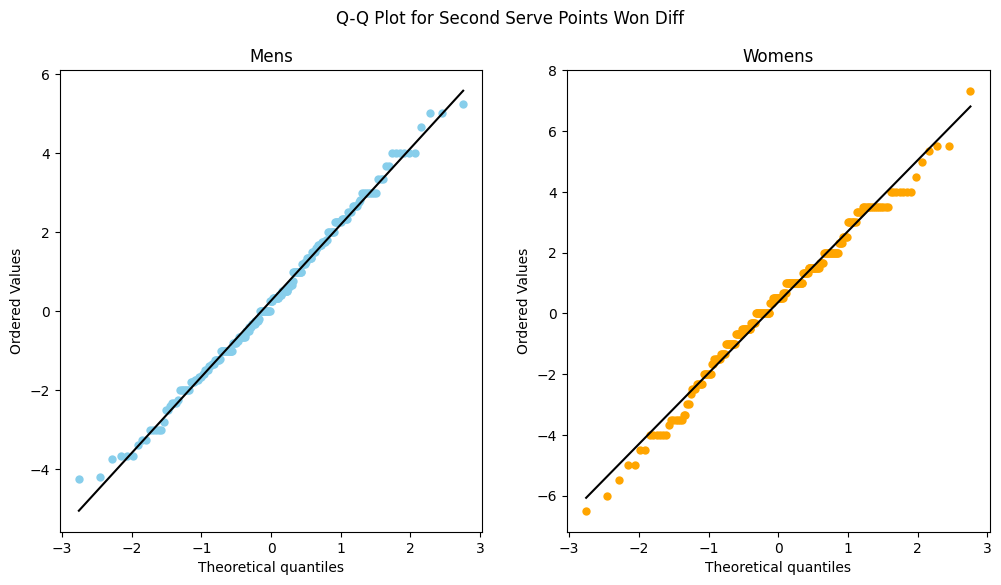

Summary Statistics for Second Serve Successful Diff:
+-------------+-----------+-----------+
| Statistic   |       Men |     Women |
+=============+===========+===========+
| Mean        | -0.728252 |  0.214815 |
+-------------+-----------+-----------+
| Median      | -0.75     |  0        |
+-------------+-----------+-----------+
| Variance    |  7.52482  | 13.1315   |
+-------------+-----------+-----------+
| Skewness    |  0.167872 | -0.276316 |
+-------------+-----------+-----------+
| Kurtosis    | -0.453561 |  0.707912 |
+-------------+-----------+-----------+
+-------------------------+--------------+-------------+
| Test                    |    Statistic |     P-value |
+=========================+==============+=============+
| KS-test (Distribution)  |     0.166992 | 0.00241153  |
+-------------------------+--------------+-------------+
| T-test (Means)          |    -3.20063  | 0.00146434  |
+-------------------------+--------------+-------------+
| Mann-Whitney U          | 

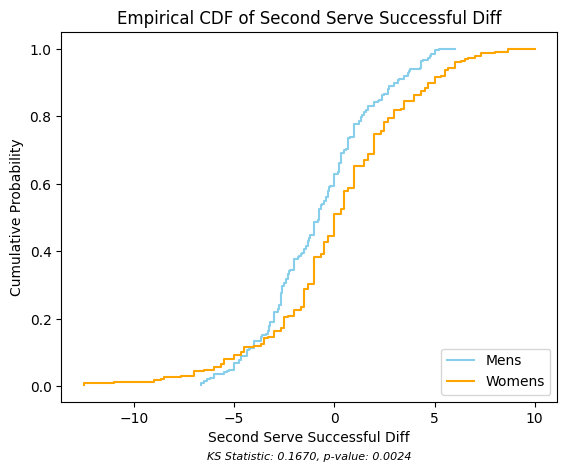

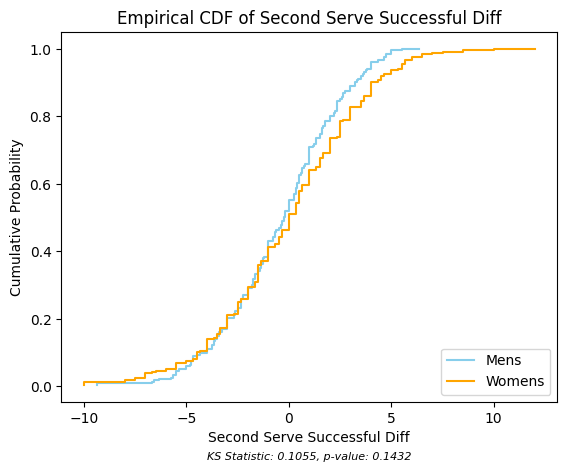

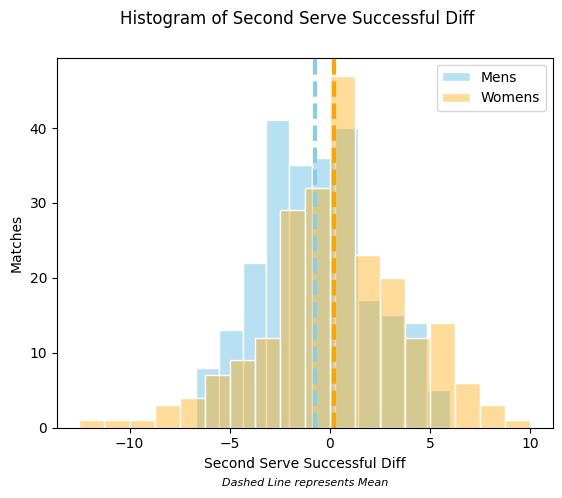

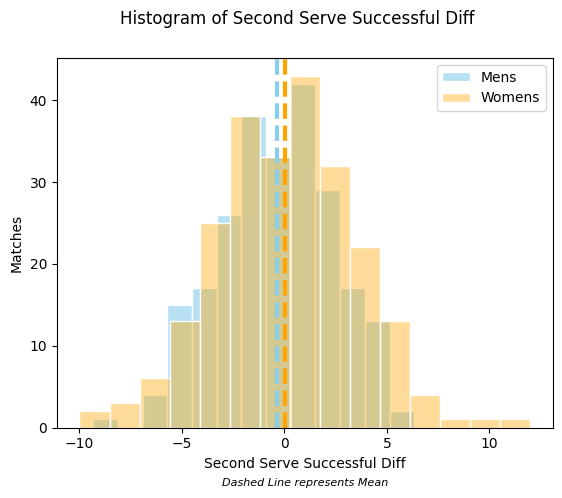

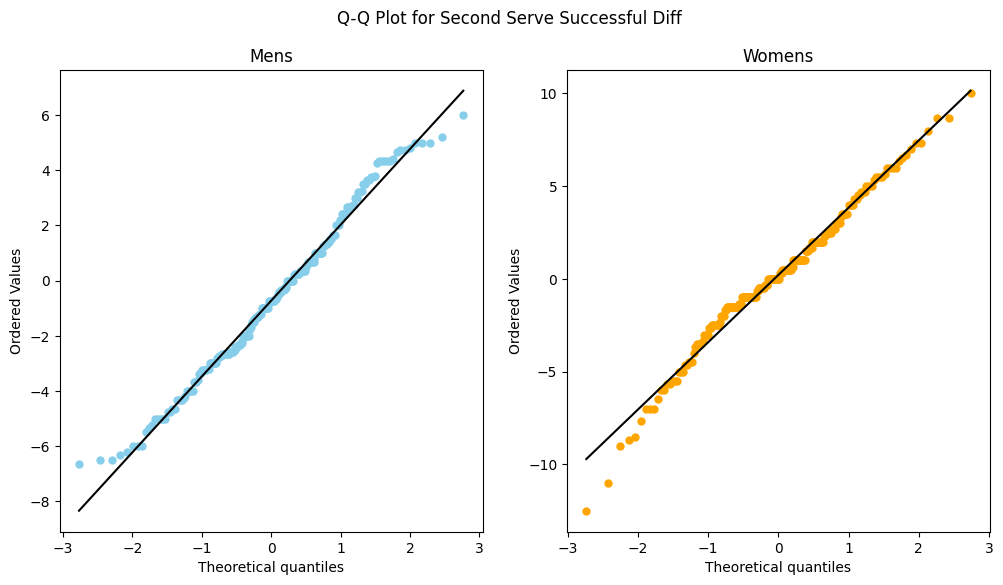

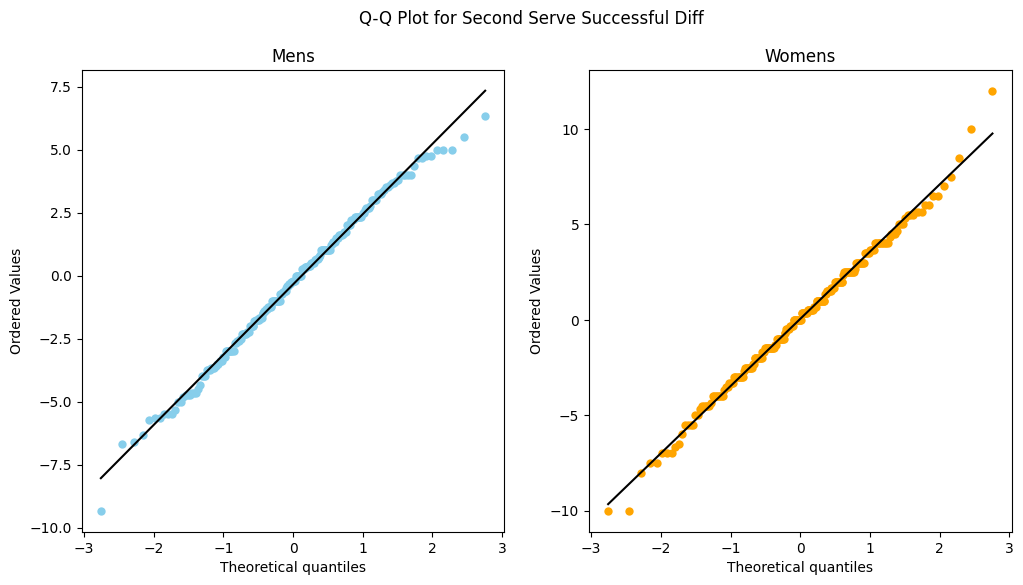

Summary Statistics for Service Games Won Diff:
+-------------+-----------+-----------+
| Statistic   |       Men |     Women |
+=============+===========+===========+
| Mean        |  0.477439 |  0.571852 |
+-------------+-----------+-----------+
| Median      |  0.75     |  0.666667 |
+-------------+-----------+-----------+
| Variance    |  1.04965  |  1.81488  |
+-------------+-----------+-----------+
| Skewness    | -0.479034 | -0.323274 |
+-------------+-----------+-----------+
| Kurtosis    | -0.403924 | -0.730218 |
+-------------+-----------+-----------+
+-------------------------+--------------+-------------+
| Test                    |    Statistic |     P-value |
+=========================+==============+=============+
| KS-test (Distribution)  |     0.175935 | 0.00115691  |
+-------------------------+--------------+-------------+
| T-test (Means)          |    -0.860361 | 0.39003     |
+-------------------------+--------------+-------------+
| Mann-Whitney U          | 26099 

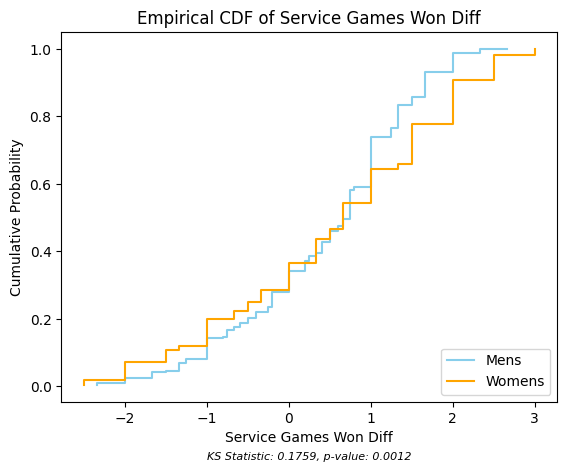

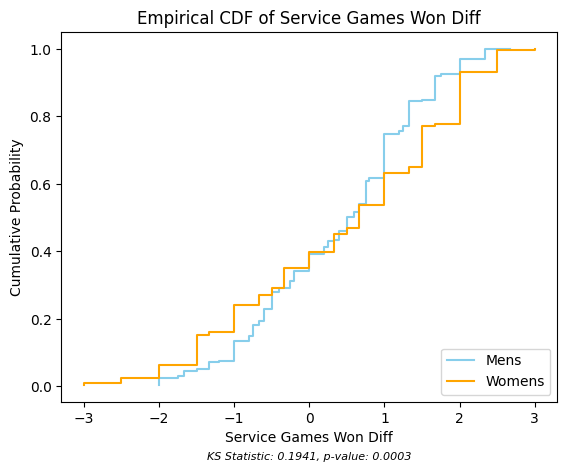

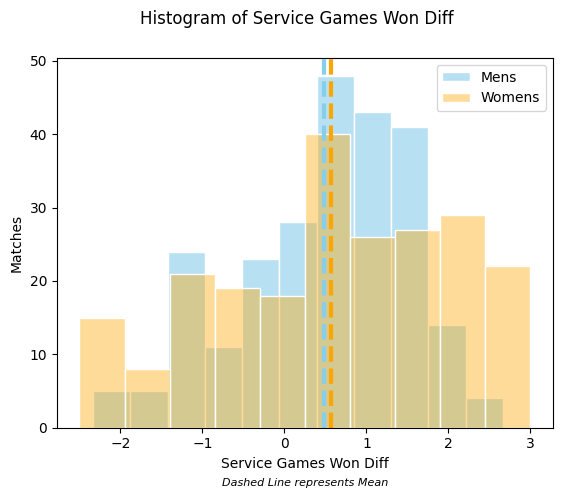

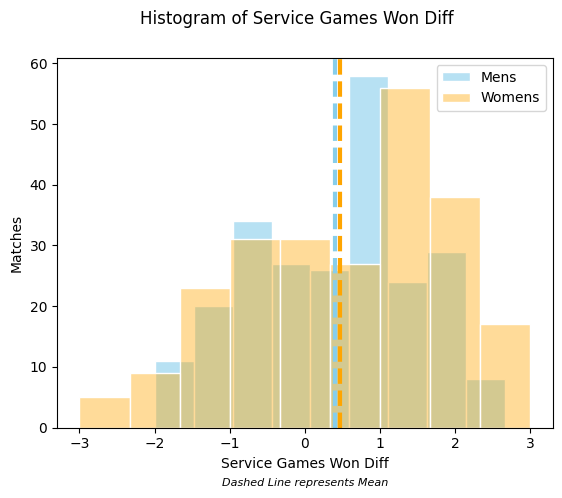

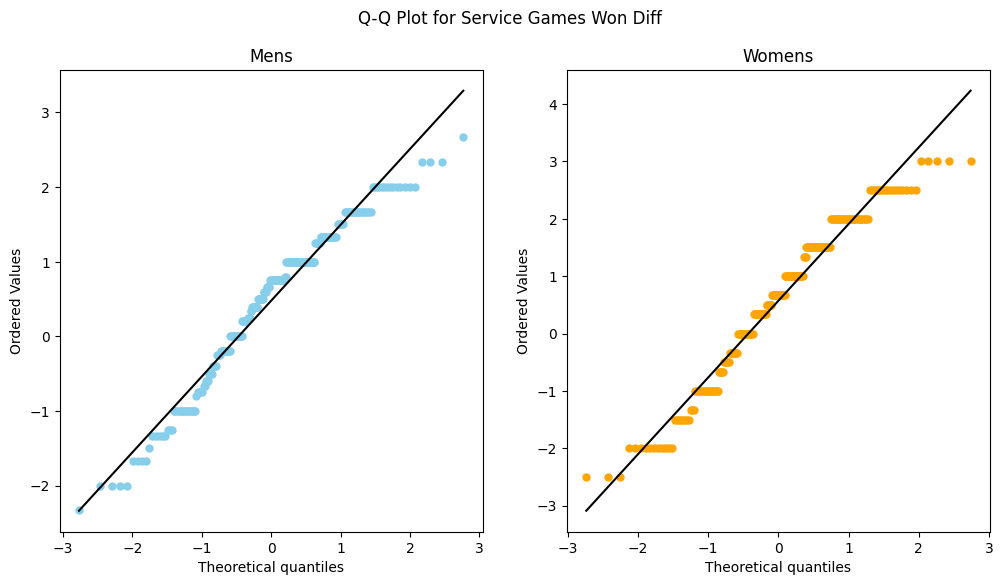

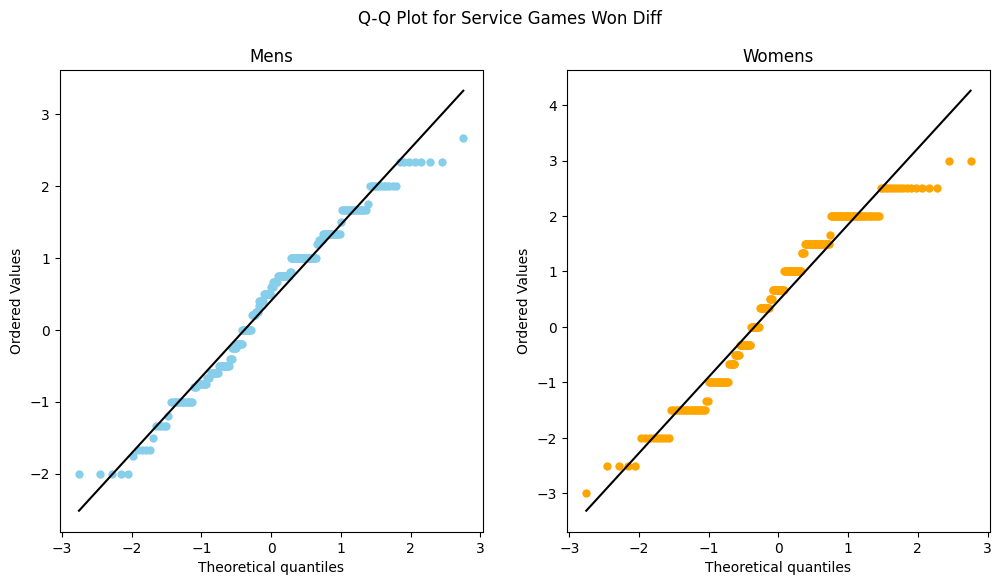

Summary Statistics for Service Points Lost Diff:
+-------------+------------+-----------+
| Statistic   |        Men |     Women |
+=============+============+===========+
| Mean        | -2.09668   | -1.78074  |
+-------------+------------+-----------+
| Median      | -2.63333   | -2        |
+-------------+------------+-----------+
| Variance    | 19.1065    | 23.0212   |
+-------------+------------+-----------+
| Skewness    |  0.272279  |  0.138091 |
+-------------+------------+-----------+
| Kurtosis    | -0.0376139 | -0.613091 |
+-------------+------------+-----------+
+-------------------------+---------------+-----------+
| Test                    |     Statistic |   P-value |
+=========================+===============+===========+
| KS-test (Distribution)  |     0.0693225 | 0.591353  |
+-------------------------+---------------+-----------+
| T-test (Means)          |    -0.747806  | 0.454952  |
+-------------------------+---------------+-----------+
| Mann-Whitney U          

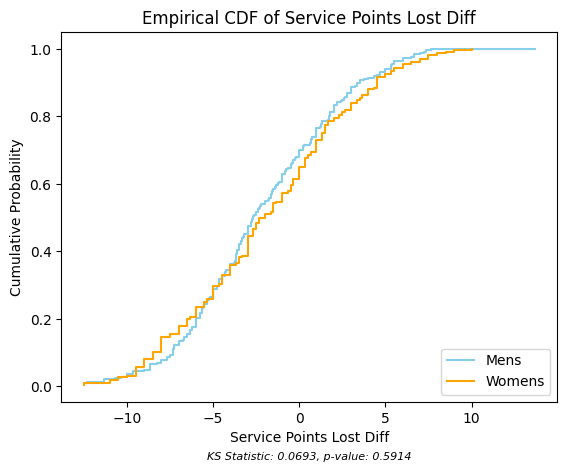

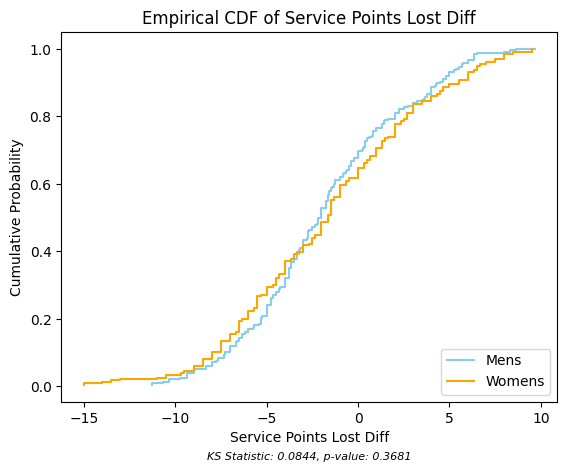

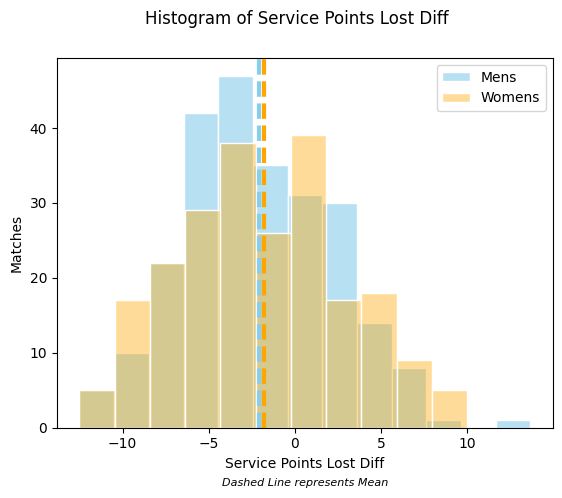

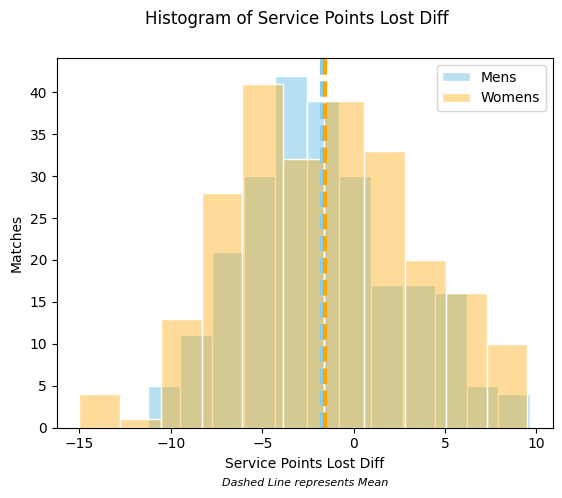

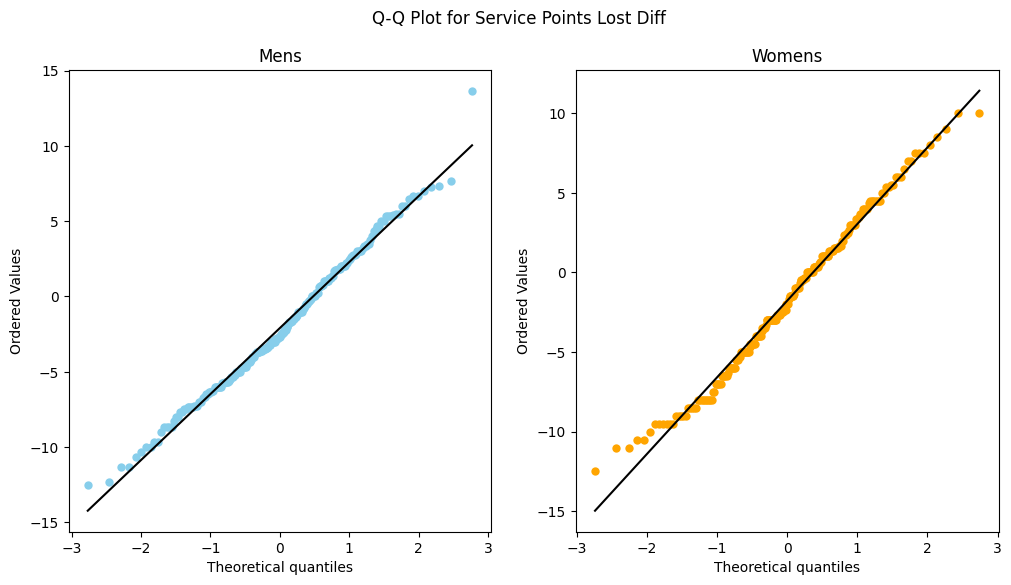

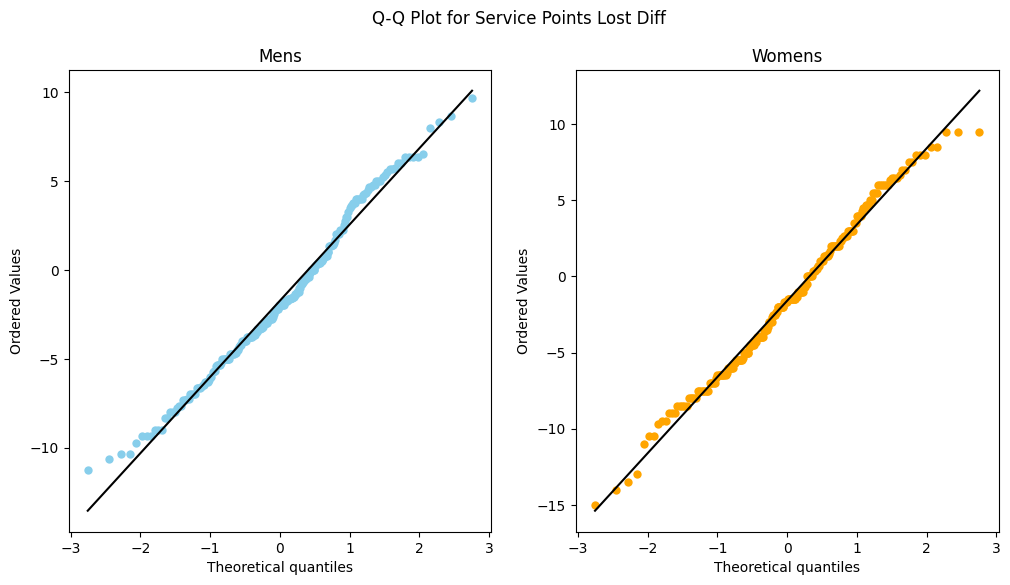

Summary Statistics for Service Points Won Diff:
+-------------+------------+-----------+
| Statistic   |        Men |     Women |
+=============+============+===========+
| Mean        |  0.772425  |  1.28296  |
+-------------+------------+-----------+
| Median      |  1         |  1.66667  |
+-------------+------------+-----------+
| Variance    |  9.39119   | 19.5223   |
+-------------+------------+-----------+
| Skewness    | -0.0741534 | -0.316834 |
+-------------+------------+-----------+
| Kurtosis    | -0.0424741 | -0.627189 |
+-------------+------------+-----------+
+-------------------------+--------------+-------------+
| Test                    |    Statistic |     P-value |
+=========================+==============+=============+
| KS-test (Distribution)  |     0.200325 | 0.000128148 |
+-------------------------+--------------+-------------+
| T-test (Means)          |    -1.46715  | 0.143005    |
+-------------------------+--------------+-------------+
| Mann-Whitney U    

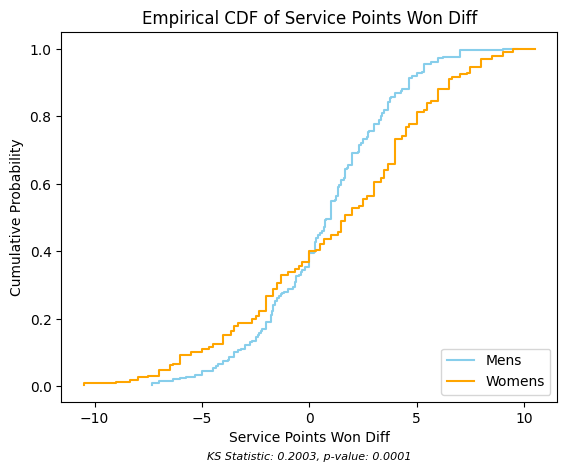

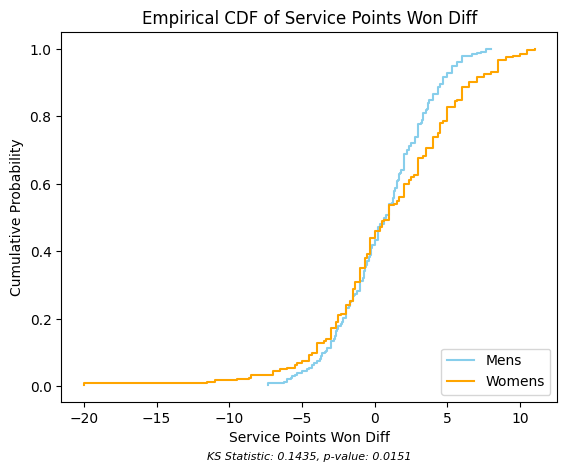

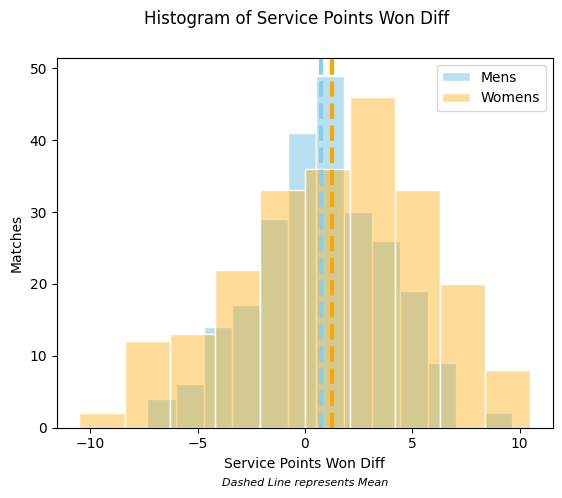

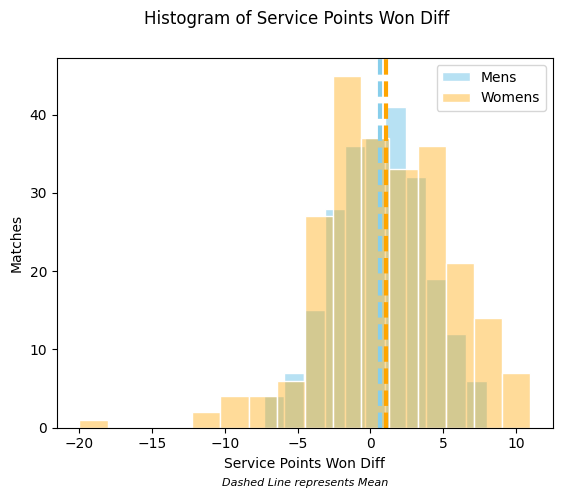

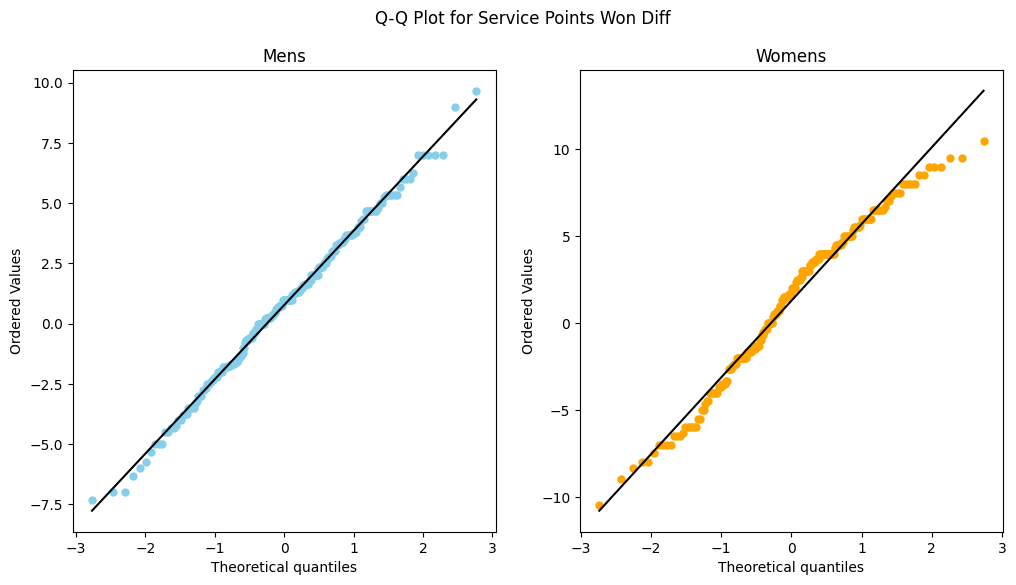

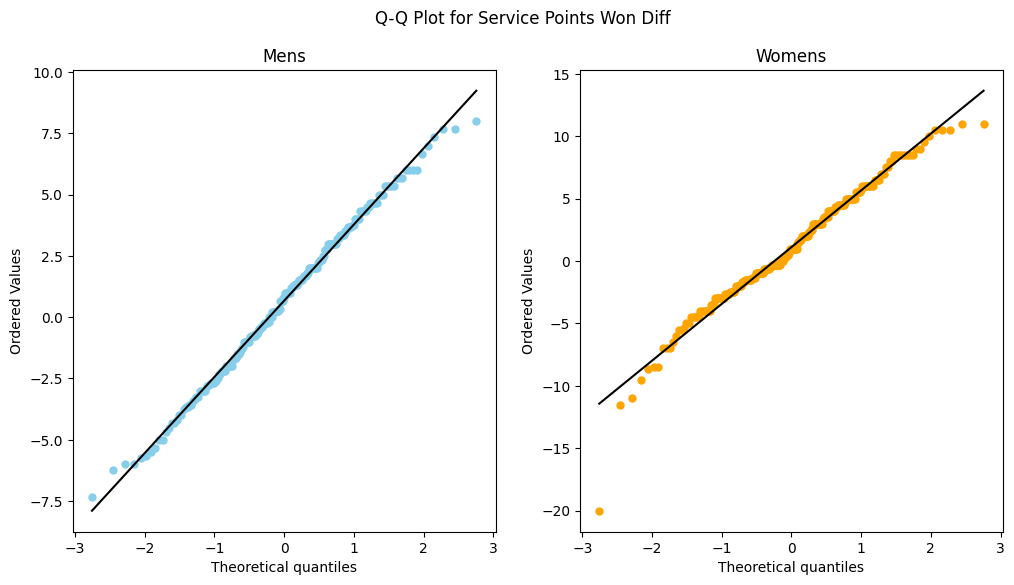

Summary Statistics for Total Breakpoints Diff:
+-------------+------------+-----------+
| Statistic   |        Men |     Women |
+=============+============+===========+
| Mean        |  0.928049  |  0.642963 |
+-------------+------------+-----------+
| Median      |  0.8       |  0.666667 |
+-------------+------------+-----------+
| Variance    |  4.23477   |  5.54383  |
+-------------+------------+-----------+
| Skewness    | -0.0236861 | -0.204826 |
+-------------+------------+-----------+
| Kurtosis    | -0.183368  | -0.342904 |
+-------------+------------+-----------+
+-------------------------+---------------+-----------+
| Test                    |     Statistic |   P-value |
+=========================+===============+===========+
| KS-test (Distribution)  |     0.0795664 | 0.417401  |
+-------------------------+---------------+-----------+
| T-test (Means)          |     1.40186   | 0.161617  |
+-------------------------+---------------+-----------+
| Mann-Whitney U          | 

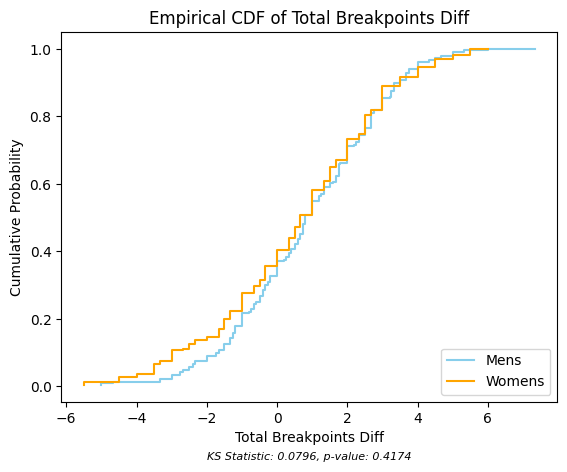

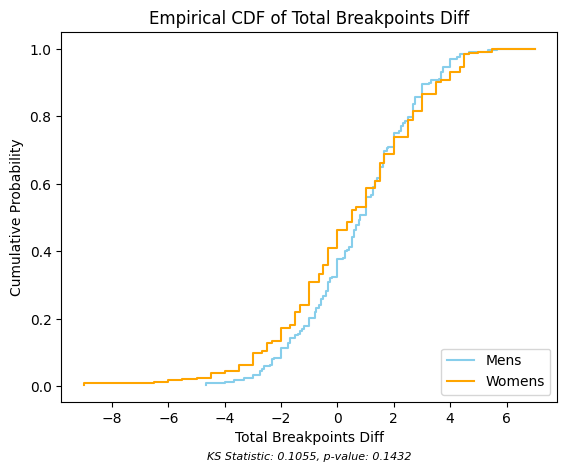

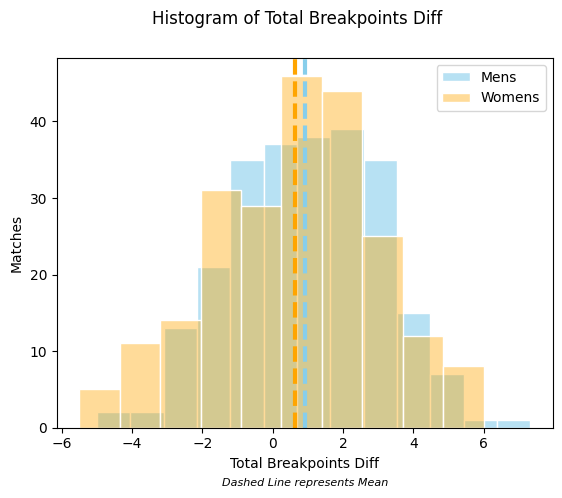

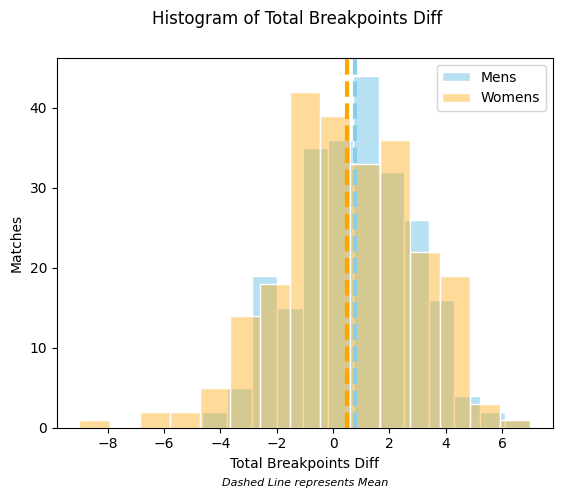

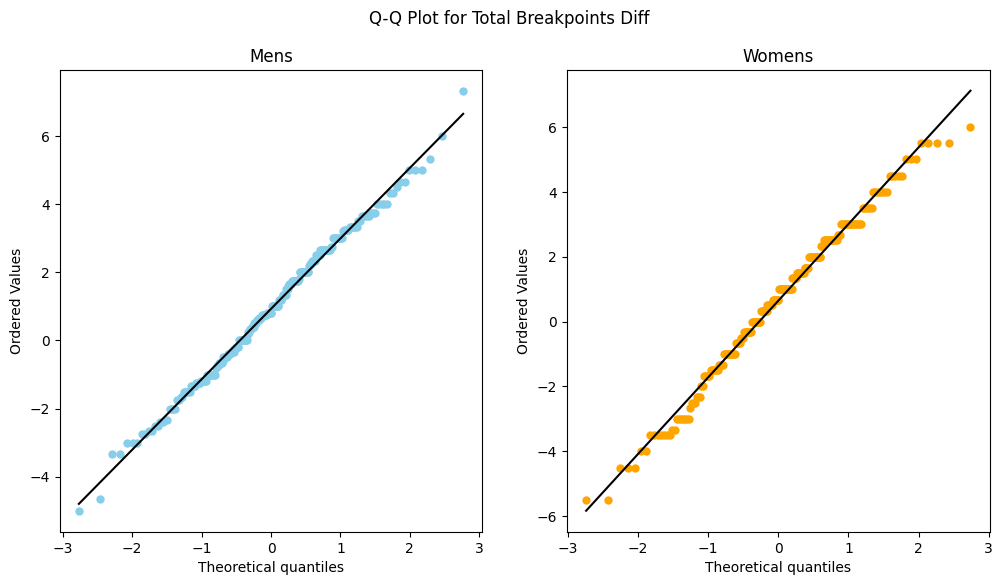

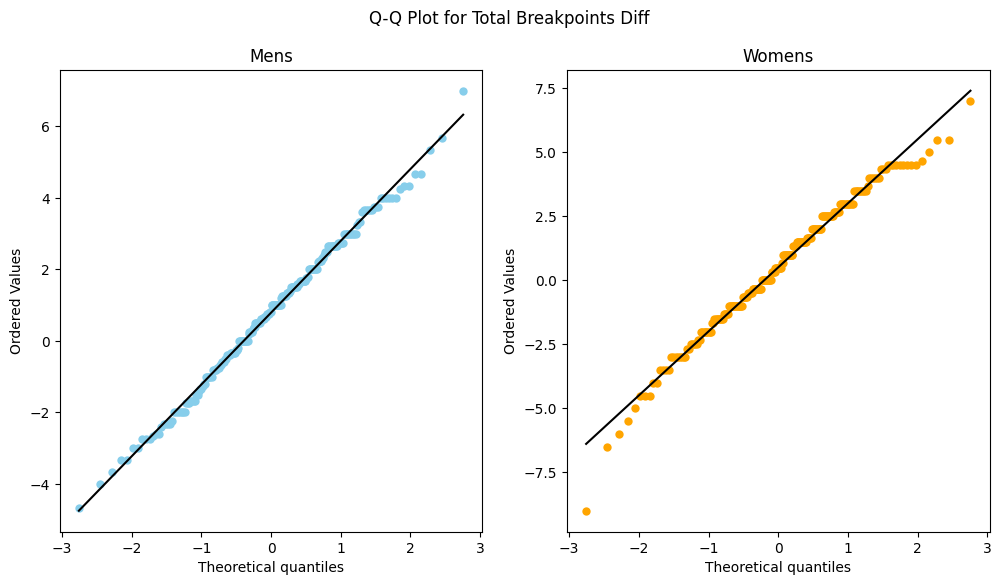

Summary Statistics for Unforced Errors Diff:
+-------------+------------+------------+
| Statistic   |        Men |      Women |
+=============+============+============+
| Mean        | -1.00129   |  -0.272593 |
+-------------+------------+------------+
| Median      | -1.1       |  -1        |
+-------------+------------+------------+
| Variance    | 63.0909    | 141.251    |
+-------------+------------+------------+
| Skewness    |  0.111331  |   0.21377  |
+-------------+------------+------------+
| Kurtosis    |  0.0721614 |   0.173384 |
+-------------+------------+------------+
+-------------------------+--------------+-------------+
| Test                    |    Statistic |     P-value |
+=========================+==============+=============+
| KS-test (Distribution)  |     0.131653 | 0.0301438   |
+-------------------------+--------------+-------------+
| T-test (Means)          |    -0.788282 | 0.43093     |
+-------------------------+--------------+-------------+
| Mann-Whi

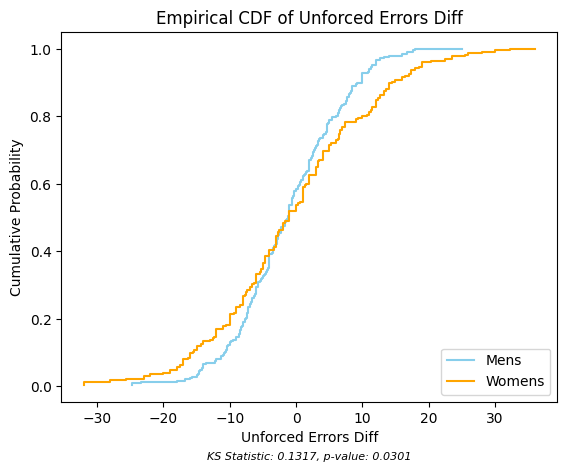

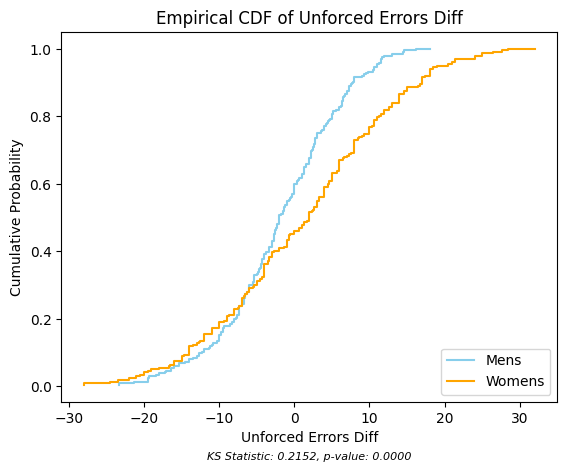

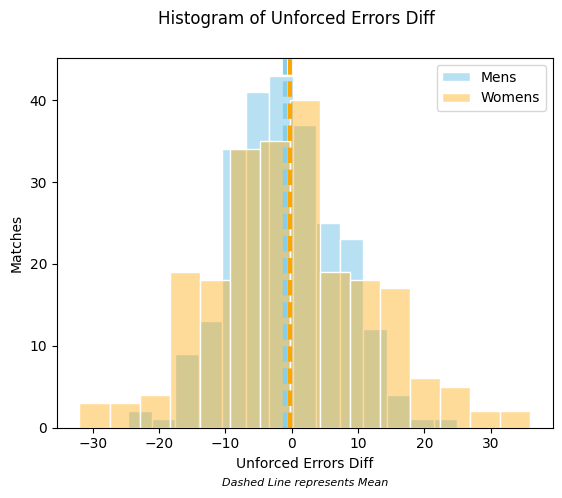

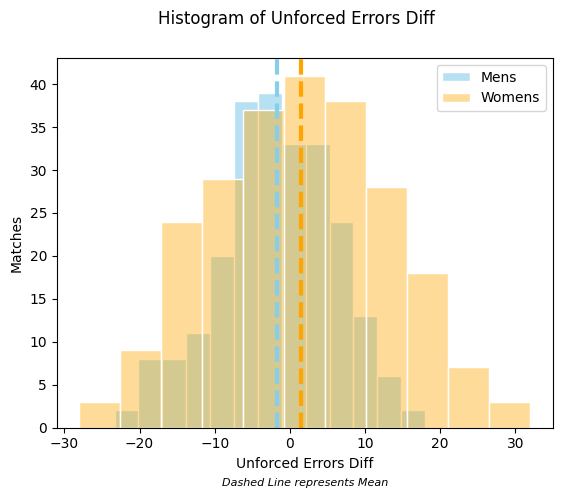

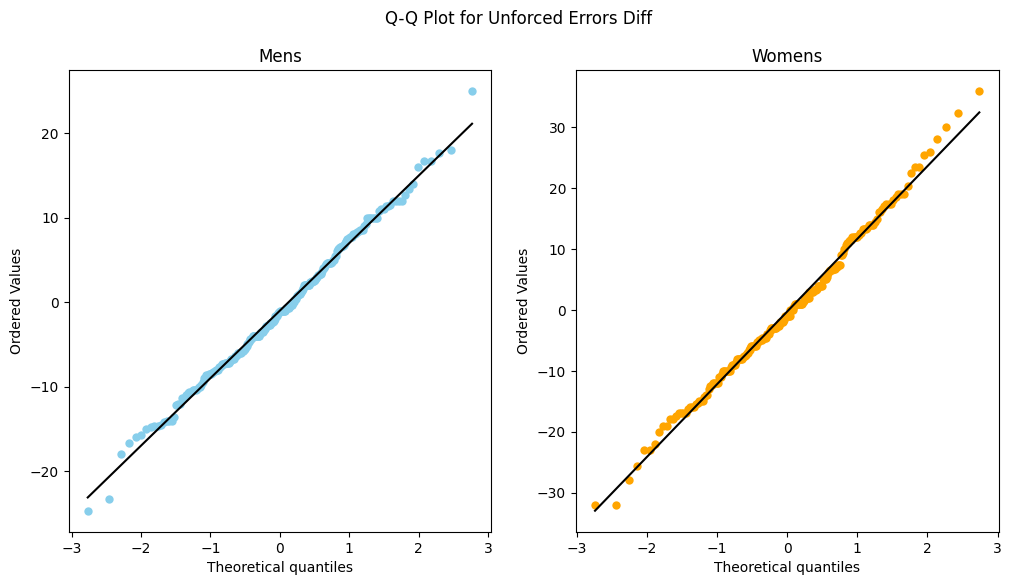

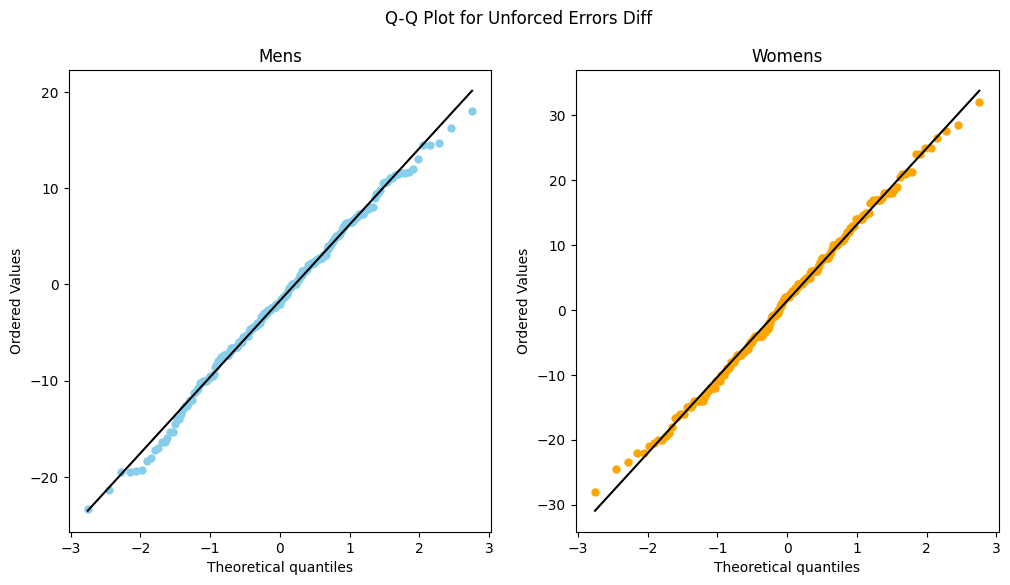

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_morestats.py:3310: RuntimeWarning: invalid value encountered in scalar divide
  W = numer / denom
/var/folders/7_/mtdhgw6s63dc18509m14sztm0000gn/T/ipykernel_60050/3024563390.py:70: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  m_results = stats.describe(m_dist)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1383: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  sk = skew(a, axis, bias=bias)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1384: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellatio

Summary Statistics for Upset:
+-------------+-------+---------+
| Statistic   |   Men |   Women |
+=============+=======+=========+
| Mean        |     0 |       0 |
+-------------+-------+---------+
| Median      |     0 |       0 |
+-------------+-------+---------+
| Variance    |     0 |       0 |
+-------------+-------+---------+
| Skewness    |   nan |     nan |
+-------------+-------+---------+
| Kurtosis    |   nan |     nan |
+-------------+-------+---------+
+-------------------------+-------------+-----------+
| Test                    |   Statistic |   P-value |
+=========================+=============+===========+
| KS-test (Distribution)  |           0 |         1 |
+-------------------------+-------------+-----------+
| T-test (Means)          |         nan |       nan |
+-------------------------+-------------+-----------+
| Mann-Whitney U          |       27675 |         1 |
+-------------------------+-------------+-----------+
| Levene-test (Variances) |         nan | 

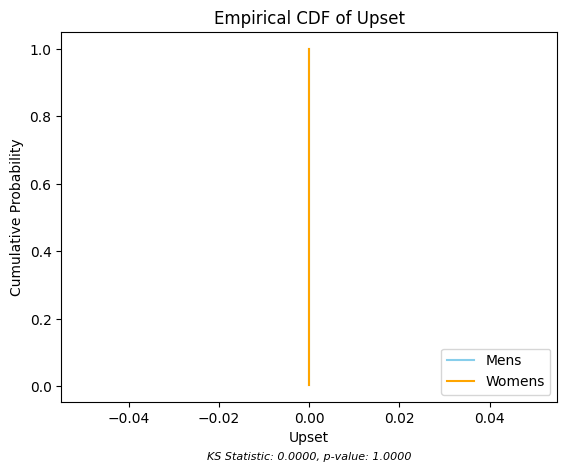

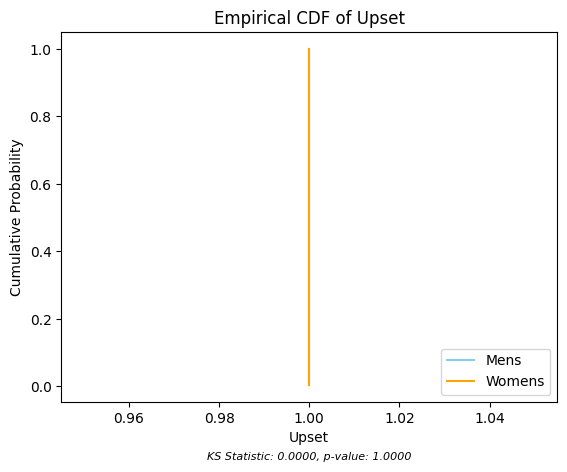

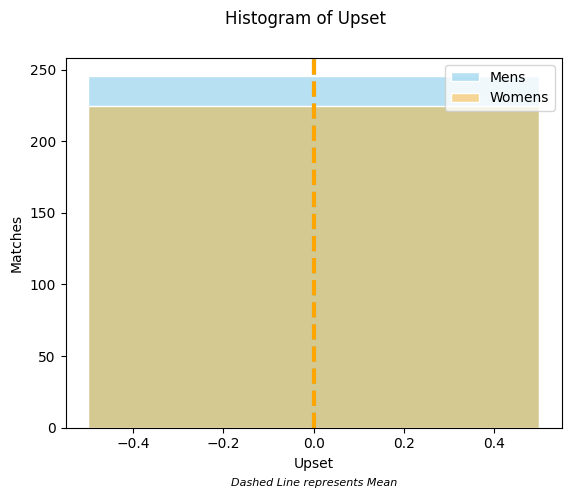

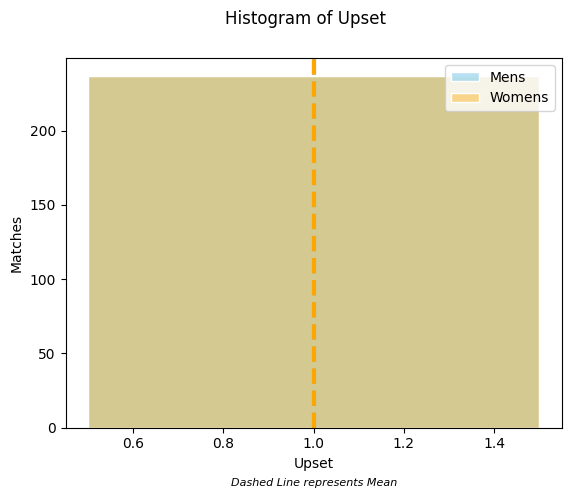

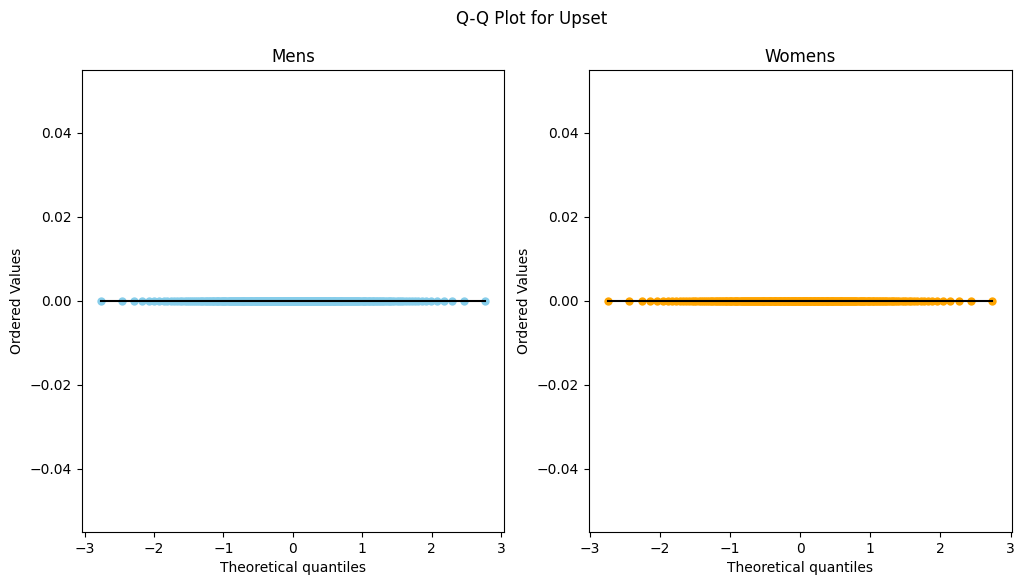

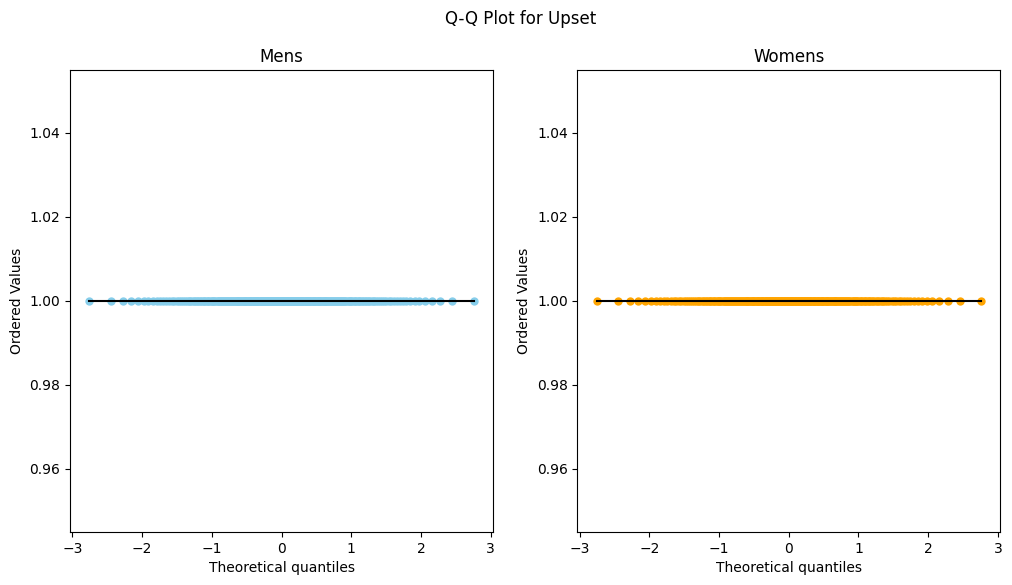

Summary Statistics for Winners Diff:
+-------------+-------------+------------+
| Statistic   |         Men |      Women |
+=============+=============+============+
| Mean        |  1.55718    |   3.26222  |
+-------------+-------------+------------+
| Median      |  1.33333    |   4        |
+-------------+-------------+------------+
| Variance    | 51.5431     | 109.781    |
+-------------+-------------+------------+
| Skewness    | -0.00909722 |  -0.155802 |
+-------------+-------------+------------+
| Kurtosis    |  0.175515   |   0.319838 |
+-------------+-------------+------------+
+-------------------------+--------------+-------------+
| Test                    |    Statistic |     P-value |
+=========================+==============+=============+
| KS-test (Distribution)  |     0.194092 | 0.000231107 |
+-------------------------+--------------+-------------+
| T-test (Means)          |    -2.07485  | 0.0385449   |
+-------------------------+--------------+-------------+
| Man

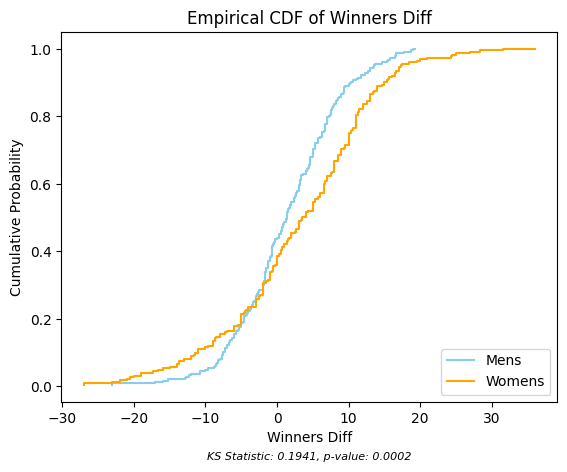

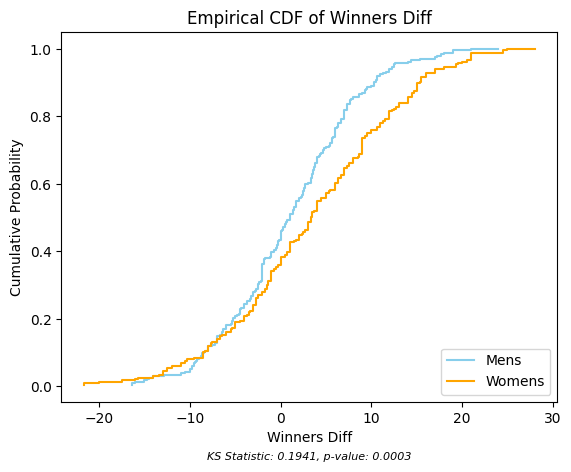

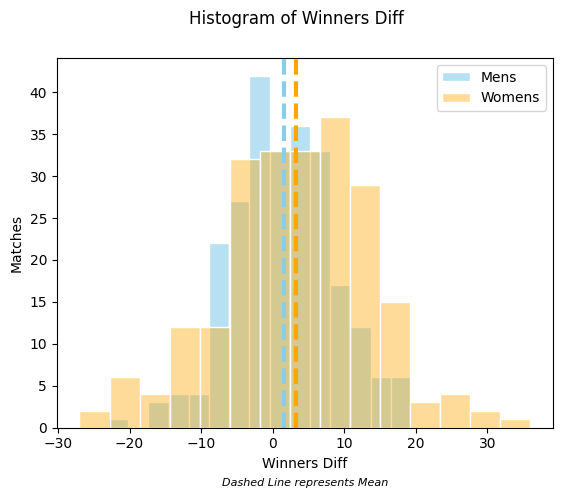

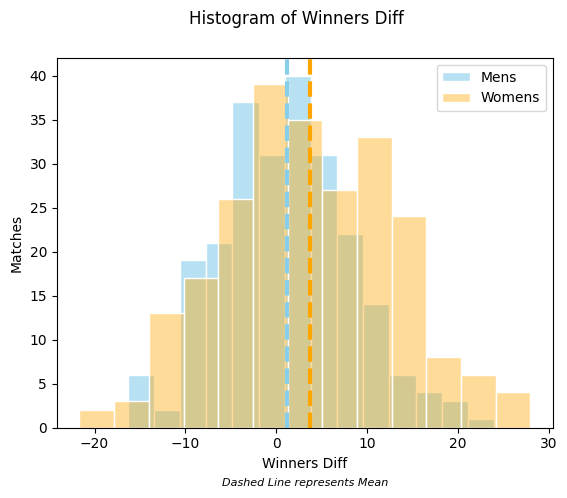

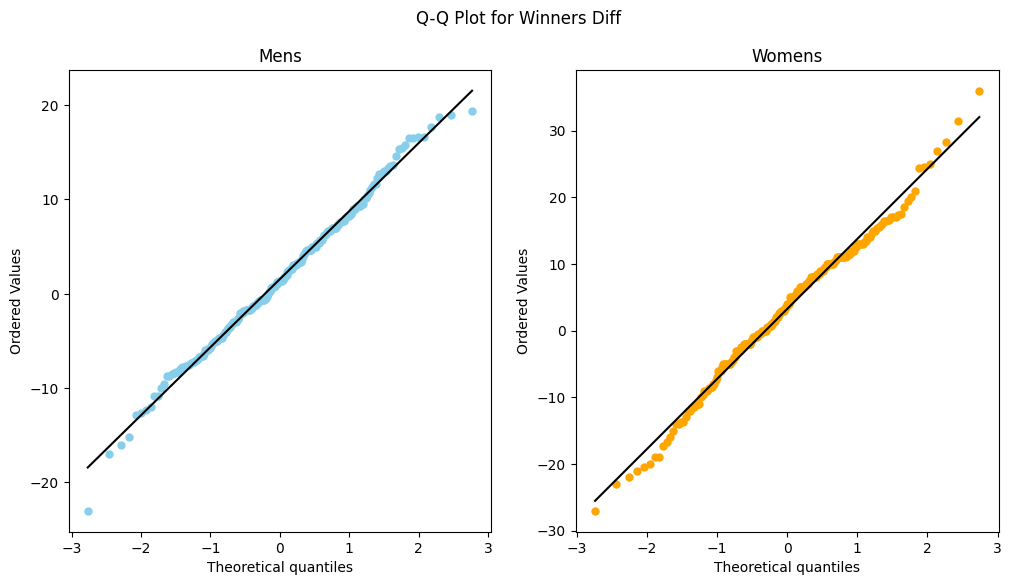

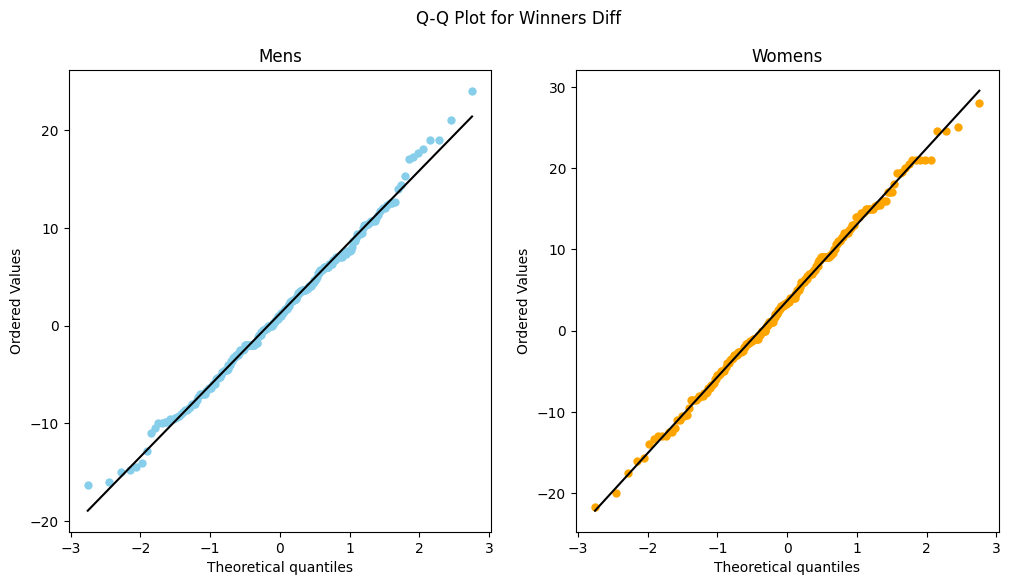

In [164]:
for feature in sorted(expected.columns):
    summarize(expected,feature)
    summarize(upsets,feature)
    plt_ecdf(expected, feature)
    plt_ecdf(upsets, feature)
    plt_dist(expected, feature)
    plt_dist(upsets, feature)
    plt_qq(expected, feature, "Q-Q Plot for "+feature.replace("_"," ").title())
    plt_qq(upsets, feature, "Q-Q Plot for "+feature.replace("_"," ").title())